In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    learning_curve
)
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    confusion_matrix
)
from imblearn.over_sampling import SMOTE

| Variable | Transformación | Valor | Descripcion |
|----------|----------------|-------|-------------|
| CORRELATIVO | Ninguna | 518050 | Identificador cliente |
| Region | Ninguna | 13 | Region de Residencia |
| Renta | Ninguna | NULL | Renta del cliente |
| Sexo | Ninguna | M | Sexo |
| Subsegmento | Ninguna | 151 | Subsegmento |
| Edad | Ninguna | 39 | Edad |
| Adicional | Ninguna | 0 | Indicador de Tenecia de TC adicionales |
| Antiguedad | Ninguna | 78 | Antigüedad del cliente (meses) |
| CambioPin | Ninguna | NULL | Indicador del cambio de clave secreta de la tarjeta |
| Consumo | Ninguna | 0 | Indicador de Credito de Consumo |
| Debito | Ninguna | 1 | Indicador de Tenecia de TD |
| Ctacte | Ninguna | 1 | Indicador de Cuenta Corriente |
| Cuentas | Ninguna | 1 | Numero de cuentas que tiene el cliente |
| Hipotecario | Ninguna | 0 | Indicador de Credito Hipotecario |
| Internauta | Ninguna | 1 | Indicador de cliente Internauta que usa la web Monopoly |
| Monoproducto | Ninguna | 0 | Indicador de si el cliente es solo poseedor de una TC |
| TC | Ninguna | 1 | Numero de TC que tiene el cliente |
| Dualidad | Ninguna | 0 | Indicador de Dualidad (Cliente es dual si tiene 2 o mas TC) |
| CUPO_L1 | Ninguna | 1800000 | Cupo de la tarjeta credito para compras nacionales |
| CUPO_MX | Ninguna | 3750 | Cupo de la tarjeta credito para compras internacionales |
| CUPO_L2 | Ninguna | 1 | Cupo de la tarjeta credito para avances en cuotas |
| Col_T12 | promedio | 0 | Colocacion del cliente en TC en el mes X |
| ColL1TE_T12 | | 0 | Revolving del cliente en TC en el mes X |
| EeccInt_T12 | promedio | 0 | Monto internacional exigido en el estado de cuenta del cliente en el mes X |
| EeccNac_T12 | promedio | -12178 | Monto nacional exigido en el estado de cuenta del cliente en el mes X |
| Fac_T12 | Promedio | 0 | Monto facturado por el cliente en TC en el mes X |
| FacAI_T12 | Promedio | 0 | Monto facturado en avances internacionales por el cliente en TC en el mes X |
| FacAN_T12 | Promedio | 0 | Monto facturado en avances nacionales por el cliente en TC en el mes X |
| FacCCOT_T12 | Promedio | 0 | Monto facturado en compras en cuotas con tasa por el cliente en TC en el mes X |
| FacCCPC_T12 | Promedio | 0 | Monto facturado en compras en cuotas precio contado por el cliente en TC en el mes X |
| FacCI_T12 | Promedio | 0 | Monto facturado en compras internacionales por el cliente en TC en el mes X |
| FacCN_T12 | Promedio | 0 | Monto facturado en compras nacionales por el cliente en TC en el mes X |
| FacCOL_T12 | Promedio | 0 | Monto facturado en avances en cuotas por el cliente en TC en el mes X |
| FacDebAtm_T12 | Promedio | 800000 | Monto facturado en avances por el cliente en TD en el mes X |
| FacDebCom_T12 | Promedio | 221730 | Monto facturado en compras por el cliente en TD en el mes X |
| FacPAT_T12 | Promedio | 0 | Monto facturado en PAT por el cliente en TC en el mes X |
| FlgAct_T12 | Suma meses activos | 0 | Indicador de actividad en el mes X en la TC |
| FlgActAI_T12 | Suma meses activos | 0 | Indicador de actividad en avances internacionales en el mes X en la TC |
| FlgActAN_T12 | Suma meses activos | 0 | Indicador de actividad en avances nacionales en el mes X en la TC |
| FlgActCCOT_T12 | Suma meses activos | 0 | Indicador de actividad en compras nacionales en cuotas con tasa en el mes X en la TC |
| FlgActCCPC_T12 | Suma meses activos | 0 | Indicador de actividad en compras nacionales en cuotas precio contado en el mes X en la TC |
| FlgActCI_T12 | Suma meses activos | 0 | Indicador de actividad en compras internacionales en el mes X en la TC |
| FlgActCN_T12 | Suma meses activos | 0 | Indicador de actividad en compras nacionales en el mes X en la TC |
| FlgActCOL_T12 | Suma meses activos | 0 | Indicador de actividad en avances en cuotas con tasa en el mes X en la TC |
| FlgActPAT_T12 | Suma meses activos | 0 | Indicador de actividad en PAT en el mes X en la TC |
| PagoInt_T12 | promedio | 0 | Monto de pagos de deuda internacional del cliente en el mes X |
| PagoNac_T12 | promedio | 25000 | Monto de pagos de deuda nacional del cliente en el mes X |
| Txs_T12 | Suma | 0 | Numero de transacciones realizados por el cliente en TC en el mes X |
| TxsAI_T12 | Suma | 0 | Numero de transacciones en avances internacionales realizados por el cliente en TC en el mes X |
| TxsAN_T12 | Suma | 0 | Numero de transacciones en avances nacionales realizados por el cliente en TC en el mes X |
| TxsCCOT_T12 | Suma | 0 | Numero de transacciones en compras en cuotas con tasa realizados por el cliente en TC en el mes X |
| TxsCCPC_T12 | Suma | 0 | Numero de transacciones en compras en cuotas precio contado realizados por el cliente en TC en el mes X |
| TxsCI_T12 | Suma | 0 | Numero de transacciones en compras internacionales realizados por el cliente en TC en el mes X |
| TxsCN_T12 | Suma | 0 | Numero de transacciones en compras nacionales realizados por el cliente en TC en el mes X |
| TxsCOL_T12 | Suma | 0 | Numero de transacciones en avances en cuotas por el cliente en TC en el mes X |
| TxsDebAtm_T12 | Suma | 5 | Numero de transacciones en avances realizados por el cliente en TD en el mes X |
| TxsDebCom_T12 | Suma | 9 | Numero de transacciones en compras realizados por el cliente en TD en el mes X |
| TxsPAT_T12 | Suma | 0 | Numero de transacciones en PAT realizados por el cliente en TC en el mes X |
| UsoL1_T12 | Promedio | -12178 | Monto de deuda en la linea de compras en la TC en el mes X |
| UsoL2_T12 | Promedio | 0 | Monto de deuda en la linea de avances en cuotas en la TC en el mes X |
| UsoLI_T12 | Promedio | 0 | Monto de deuda en la linea de compras internacionales en la TC en el mes X |

Fase 1: Business Understanding

El banco Monopoly, con años de trayectoria atendiendo clientes en Chile, ha sido adquirido recientemente por el banco extranjero Dormammu. Este cambio estratégico busca aprovechar el mercado chileno y optimizar la relación con los clientes de Monopoly mediante un análisis profundo de su comportamiento financiero.

Como parte del equipo de ingenieros de Dormammu, se nos ha encomendado el desafío de analizar una base de datos proporcionada por Monopoly. Esta contiene información detallada de 12 meses para 51,124 clientes, organizada en 574 variables que incluyen características demográficas, financieras y comportamentales. El objetivo principal es extraer patrones, identificar segmentos y generar insumos valiosos para diseñar estrategias que potencien la gestión de estos clientes bajo la nueva administración.

Objetivo
Entender el comportamiento de los clientes del banco Monopoly mediante el análisis de sus datos históricos, para ofrecer insights clave que orienten la estrategia comercial y operativa de Dormammu.

Preguntas clave
¿Qué factores sociodemográficos, como región, renta y edad, influyen en el uso de productos financieros?
¿Los clientes con múltiples productos financieros (dualidad) generan más ingresos y transacciones que los clientes monoproducto?
¿Cómo afecta la antigüedad del cliente en el banco a su nivel de actividad y uso de líneas de crédito?
¿Qué patrones de comportamiento se pueden identificar en el uso de tarjetas de crédito y débito según el subsegmento del cliente?

In this work, we will base our Machine Learning process on the CRISP-DM analytical model. This model has the advantage of being flexible, easy to understand, and adaptable to the vast majority of projects. CRISP-DM consists of 6 phases, which are:

Business Understanding: Clearly define the context and business objectives.
Data Understanding: Explore, describe, and analyze the data from the DataSets to identify quality issues or important patterns.
Data Preparation: Clean, transform, and select relevant data for analysis.
Modeling: Apply data mining algorithms and techniques (such as decision trees, regression, etc.) to build models that solve the business problem.
Evaluation: Verify if the created models are useful and meet the business objectives, adjusting if necessary.
Deployment: Implement the model in a real environment, whether to automate decisions, generate reports, or any other required business application.

In [2]:
ds = pd.read_excel('../data/01_raw/Base_clientes_Monopoly.xlsx')

To begin with the exploratory analysis, it is essential to identify and understand the information contained in each of the datasets we will be using. Below is a summary of the three main datasets involved in our study.

The proposed dataset has errors so, before anything else, we will apply a function that orders the shape of the sataset to be able to work with it

In [3]:
ds.columns = ds.iloc[0]  
ds = ds[1:]
ds.reset_index(drop=True, inplace=True)

In the data preparation process, the first row of the DataFrame `db` is assigned as the column names since the original Excel file contained numbers instead of descriptive names. This is crucial for facilitating the identification and handling of the data in subsequent analyses. Next, this first row is removed from the DataFrame, ensuring that only the relevant data remains for analysis and avoiding confusion from duplicate data. Following this, the index of the DataFrame is reset to keep it clean and organized, which is a good practice in data preparation. Finally, the new column names and the first few rows of the DataFrame are printed to verify that the operations have been executed correctly. This verification is essential in the CRISP-DM methodology to ensure that the data is properly structured before proceeding with exploratory analysis and modeling.

Fase 2: Data Understanding

In [4]:
ds.describe()

,NaN
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [5]:
ds.isna().sum()


0
Id                 0
Subsegmento        0
Sexo               1
Region            53
Edad               0
               ...  
UsoL2_T01          0
UsoLI_T01          0
IndRev_T01         0
target             0
NaN            51124
Length: 575, dtype: int64

In [6]:
print(ds.dtypes)

0
Id              object
Subsegmento     object
Sexo            object
Region          object
Edad            object
                ...   
UsoL2_T01       object
UsoLI_T01       object
IndRev_T01      object
target          object
NaN            float64
Length: 575, dtype: object


In [7]:
   print(len(ds.columns))  # Esto te mostrará el número de columnas

575


In [8]:
conteo_filas = ds.count()

# Mostrar el conteo de filas por columna
print(conteo_filas)


0
Id             51124
Subsegmento    51124
Sexo           51123
Region         51071
Edad           51124
               ...  
UsoL2_T01      51124
UsoLI_T01      51124
IndRev_T01     51124
target         51124
NaN                0
Length: 575, dtype: int64


In [9]:
# Contar el número total de filas en el DataFrame
numero_total_filas = ds.shape[0]
print(f'Número total de filas: {numero_total_filas}')

Número total de filas: 51124


In [10]:
description = ds.describe()
for column in description.columns:
    print(f"Analysis of {column}:")

    mean_value = description[column].mean(skipna=True)
    print(f" - Mean (Average): {mean_value:.2f} ")

    median_value = description[column].median(skipna=True)
    print(f" - Median: {median_value:.2f} ")

Analysis of nan:
 - Mean (Average): 0.00 
 - Median: 0.00 


Fase 3: Data Preparation

In [11]:
columnas_deseadas = [
    'Id', 'Region', 'Renta', 'Sexo', 'Subsegmento', 'Edad', 
    'Adicional', 'Antiguedad', 'CambioPin', 'Consumo', 'Debito', 'Ctacte', 
    'Cuentas', 'Hipotecario', 'Internauta', 'Monoproducto', 'TC', 'Dualidad', 
    'CUPO_L1', 'CUPO_MX', 'CUPO_L2', 'Col_T12', 'ColL1TE_T12', 'EeccInt_T12', 
    'EeccNac_T12', 'Fac_T12', 'FacAI_T12', 'FacAN_T12', 'FacCCOT_T12', 
    'FacCCPC_T12', 'FacCI_T12', 'FacCN_T12', 'FacCOL_T12', 'FacDebAtm_T12', 
    'FacDebCom_T12', 'FacPAT_T12', 'FlgAct_T12', 'FlgActAI_T12', 'FlgActAN_T12', 
    'FlgActCCOT_T12', 'FlgActCCPC_T12', 'FlgActCI_T12', 'FlgActCN_T12', 
    'FlgActCOL_T12', 'FlgActPAT_T12', 'PagoInt_T12', 'PagoNac_T12', 'Txs_T12', 
    'TxsAI_T12', 'TxsAN_T12', 'TxsCCOT_T12', 'TxsCCPC_T12', 'TxsCI_T12', 
    'TxsCN_T12', 'TxsCOL_T12', 'TxsDebAtm_T12', 'TxsDebCom_T12', 'TxsPAT_T12', 
    'UsoL1_T12', 'UsoL2_T12', 'UsoLI_T12'
]
ds = ds[columnas_deseadas]

In [12]:
for col in ds.columns:
    if col != 'Sexo':
        ds[col] = pd.to_numeric(ds[col], errors='coerce')

Distribuciones de variables numéricas:


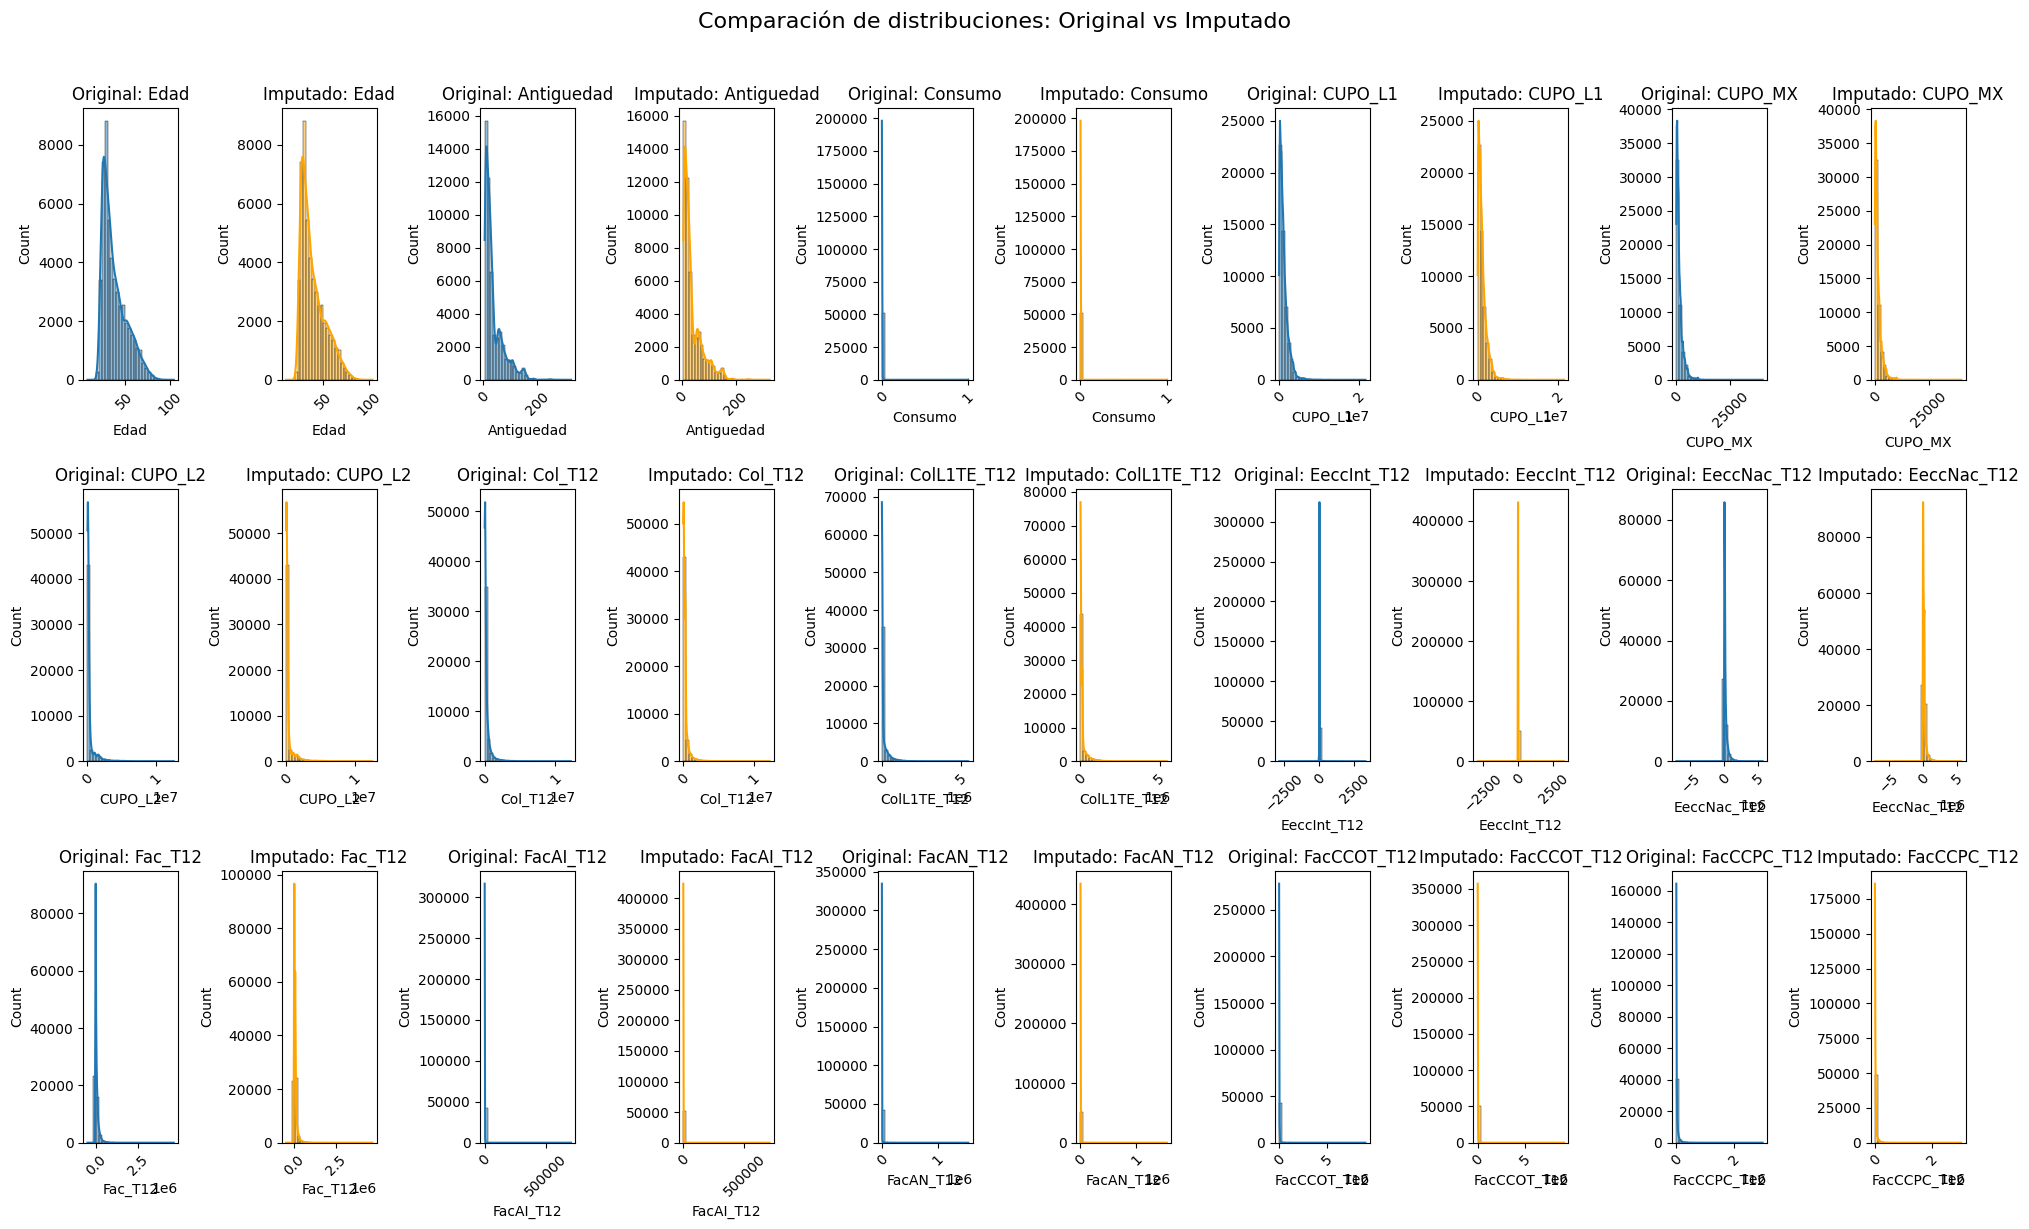


Distribuciones de variables categóricas:


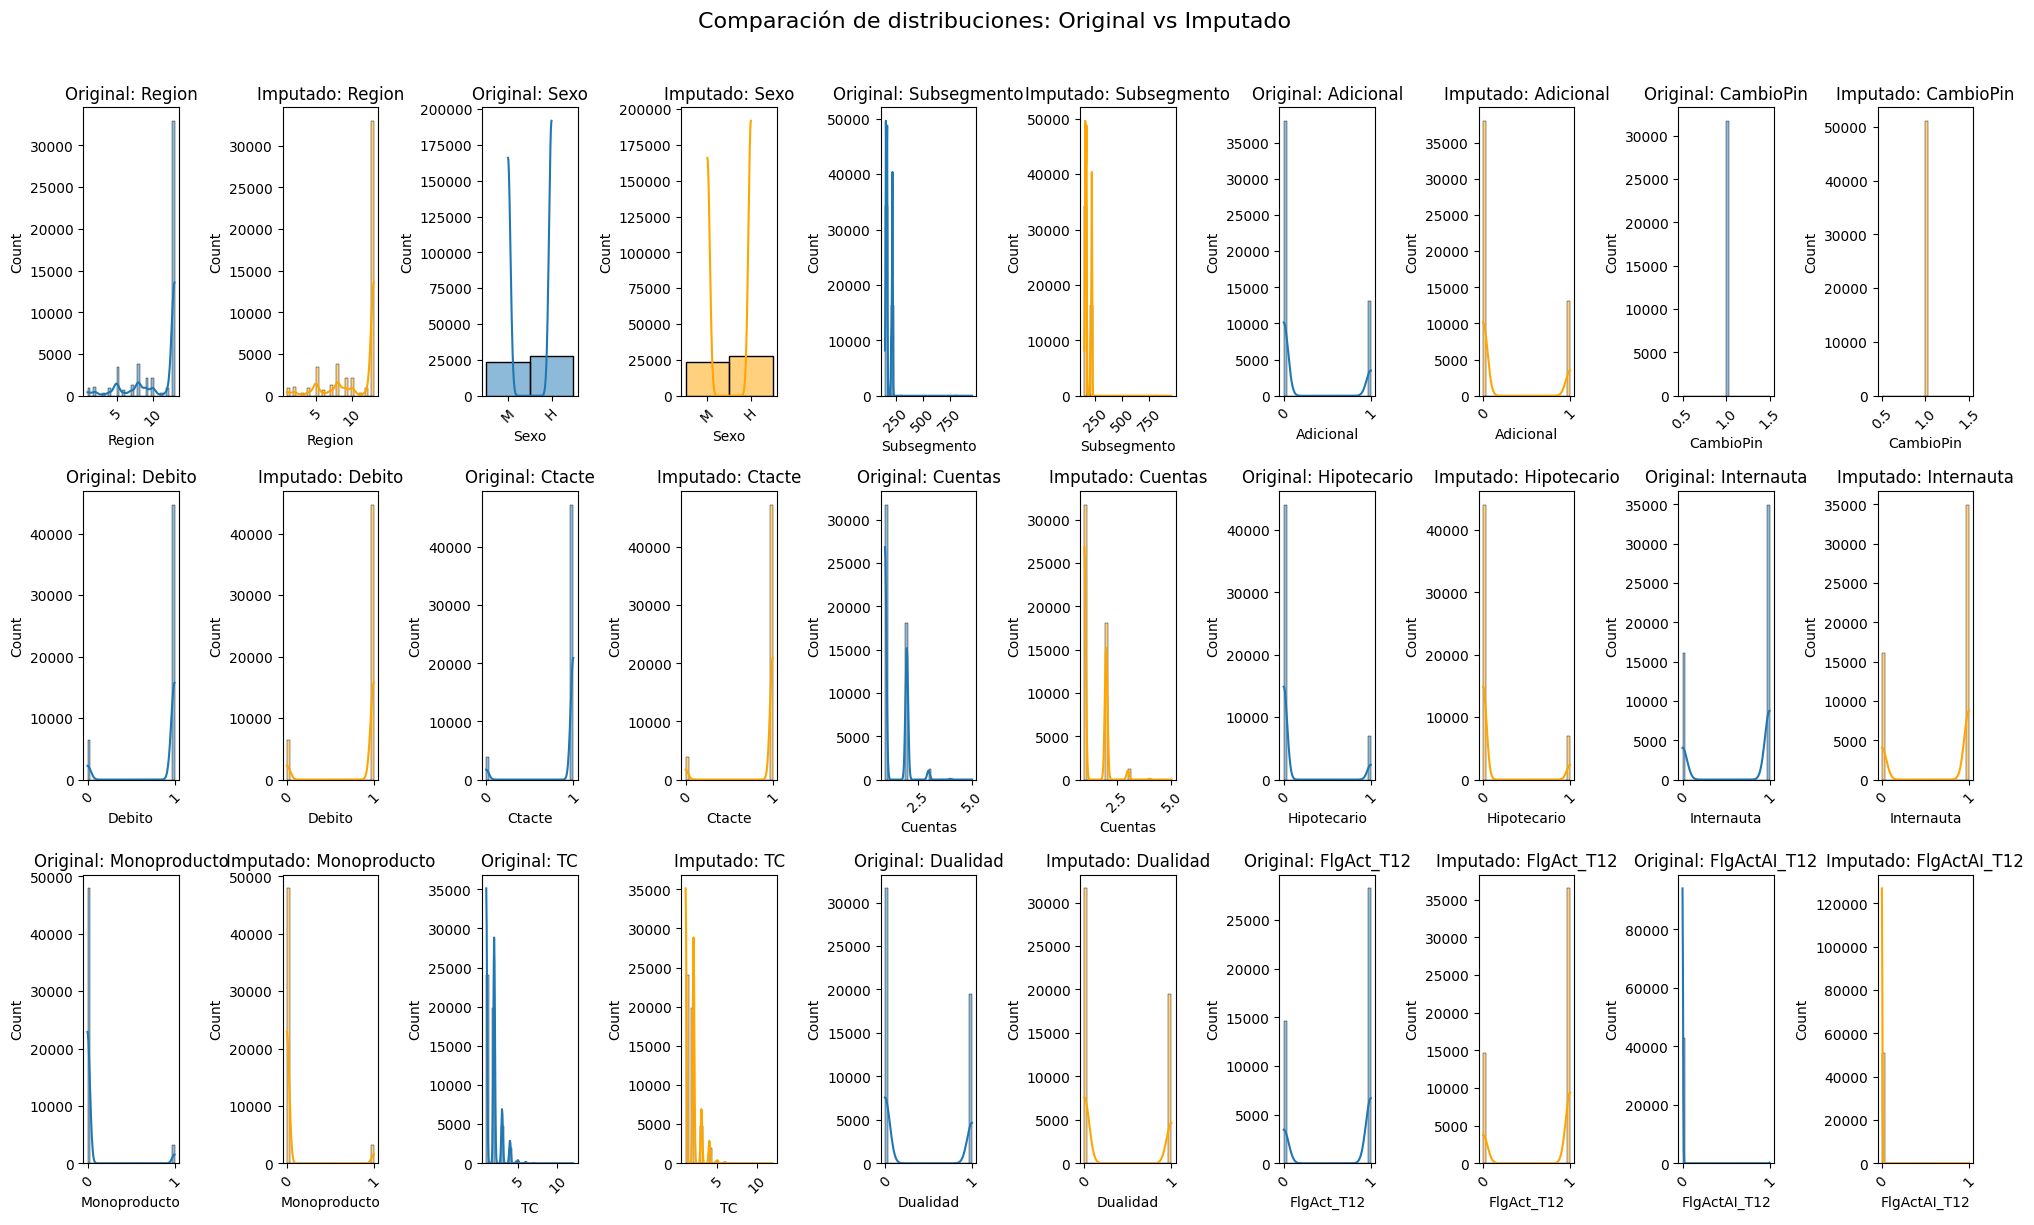

In [13]:
from sklearn.impute import SimpleImputer

# Separamos las columnas numéricas y categóricas según tu dataset
cols_numericas = [
    'Edad', 'Antiguedad', 'Consumo', 'CUPO_L1', 'CUPO_MX', 'CUPO_L2',
    'Col_T12', 'ColL1TE_T12', 'EeccInt_T12', 'EeccNac_T12', 'Fac_T12', 
    'FacAI_T12', 'FacAN_T12', 'FacCCOT_T12', 'FacCCPC_T12', 'FacCI_T12', 
    'FacCN_T12', 'FacCOL_T12', 'FacDebAtm_T12', 'FacDebCom_T12', 'FacPAT_T12',
    'PagoInt_T12', 'PagoNac_T12', 'Txs_T12', 'TxsAI_T12', 'TxsAN_T12', 
    'TxsCCOT_T12', 'TxsCCPC_T12', 'TxsCI_T12', 'TxsCN_T12', 'TxsCOL_T12', 
    'TxsDebAtm_T12', 'TxsDebCom_T12', 'TxsPAT_T12', 'UsoL1_T12', 'UsoL2_T12', 
    'UsoLI_T12'
]

cols_categoricas = [
    'Region', 'Sexo', 'Subsegmento', 'Adicional', 'CambioPin', 'Debito', 
    'Ctacte', 'Cuentas', 'Hipotecario', 'Internauta', 'Monoproducto', 'TC', 
    'Dualidad', 'FlgAct_T12', 'FlgActAI_T12', 'FlgActAN_T12', 'FlgActCCOT_T12',
    'FlgActCCPC_T12', 'FlgActCI_T12', 'FlgActCN_T12', 'FlgActCOL_T12', 
    'FlgActPAT_T12'
]

# Inicializamos el imputador para las columnas numéricas (usaremos la media)
imputador_numerico_media = SimpleImputer(strategy='mean')

# Imputamos las columnas numéricas con la media
ds_imputado = ds.copy()  # Copia del DataFrame original
ds_imputado[cols_numericas] = imputador_numerico_media.fit_transform(ds_imputado[cols_numericas])

# Inicializamos el imputador para las columnas categóricas (usamos la moda)
imputador_categorico = SimpleImputer(strategy='most_frequent')

# Imputamos las columnas categóricas con la moda
ds_imputado[cols_categoricas] = imputador_categorico.fit_transform(ds_imputado[cols_categoricas])

# Mostrar distribución de los datos después de la imputación
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def comparar_distribuciones(ds_original, ds_imputado, columnas, n_columnas=5):
    # Calculamos el número de filas necesarias
    n_filas = int(np.ceil(len(columnas) / n_columnas))
    
    # Creamos una figura más grande para acomodar ambas distribuciones
    plt.figure(figsize=(20, 4*n_filas))
    
    for i, columna in enumerate(columnas, 1):
        # Subplot para datos originales
        plt.subplot(n_filas, n_columnas*2, i*2-1)
        sns.histplot(ds_original[columna], kde=True, bins=30)
        plt.title(f'Original: {columna}')
        plt.xticks(rotation=45)
        
        # Subplot para datos imputados
        plt.subplot(n_filas, n_columnas*2, i*2)
        sns.histplot(ds_imputado[columna], kde=True, bins=30, color='orange')
        plt.title(f'Imputado: {columna}')
        plt.xticks(rotation=45)
    
    plt.suptitle('Comparación de distribuciones: Original vs Imputado', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Primero visualizamos las variables numéricas
print("Distribuciones de variables numéricas:")
# Seleccionamos las primeras 15 variables numéricas para una mejor visualización
columnas_num_mostrar = cols_numericas[:15]
comparar_distribuciones(ds, ds_imputado, columnas_num_mostrar)

# Luego visualizamos las variables categóricas
print("\nDistribuciones de variables categóricas:")
# Seleccionamos las primeras 15 variables categóricas para una mejor visualización
columnas_cat_mostrar = cols_categoricas[:15]
comparar_distribuciones(ds, ds_imputado, columnas_cat_mostrar)

In [14]:
def calcular_porcentaje_nulos(df):
    # Calcular el total de valores nulos por columna
    nulos_por_columna = df.isnull().sum()
    # Calcular el porcentaje
    porcentaje_nulos = (nulos_por_columna / len(df)) * 100
    return porcentaje_nulos

# Calcular porcentajes antes y después de la imputación
porcentaje_antes = calcular_porcentaje_nulos(ds)
porcentaje_despues = calcular_porcentaje_nulos(ds_imputado)

# Crear un DataFrame comparativo
comparacion_nulos = pd.DataFrame({
    'Porcentaje_Nulos_Antes': porcentaje_antes,
    'Porcentaje_Nulos_Despues': porcentaje_despues,
    'Reduccion': porcentaje_antes - porcentaje_despues
})

# Filtrar solo las columnas que tenían valores nulos
comparacion_nulos = comparacion_nulos[comparacion_nulos['Porcentaje_Nulos_Antes'] > 0]

# Ordenar por mayor reducción
comparacion_nulos = comparacion_nulos.sort_values('Reduccion', ascending=False)

# Mostrar los resultados
print("\nResumen de la reducción de valores nulos:")
print("-" * 80)
print(comparacion_nulos.round(2))
print("\nEstadísticas generales:")
print("-" * 80)
print(f"Promedio de reducción: {comparacion_nulos['Reduccion'].mean():.2f}%")
print(f"Máxima reducción: {comparacion_nulos['Reduccion'].max():.2f}%")
print(f"Total de columnas con valores nulos antes de imputación: {len(comparacion_nulos)}")
print(f"Porcentaje total de datos faltantes antes: {porcentaje_antes.mean():.2f}%")
print(f"Porcentaje total de datos faltantes después: {porcentaje_despues.mean():.2f}%")


Resumen de la reducción de valores nulos:
--------------------------------------------------------------------------------
                Porcentaje_Nulos_Antes  Porcentaje_Nulos_Despues  Reduccion
0                                                                          
CambioPin                        37.92                      0.00      37.92
EeccInt_T12                      16.14                      0.00      16.14
ColL1TE_T12                      16.14                      0.00      16.14
Col_T12                          16.14                      0.00      16.14
Fac_T12                          16.14                      0.00      16.14
FacAI_T12                        16.14                      0.00      16.14
FacAN_T12                        16.14                      0.00      16.14
EeccNac_T12                      16.14                      0.00      16.14
FacCCOT_T12                      16.14                      0.00      16.14
FacCN_T12                        16.14  

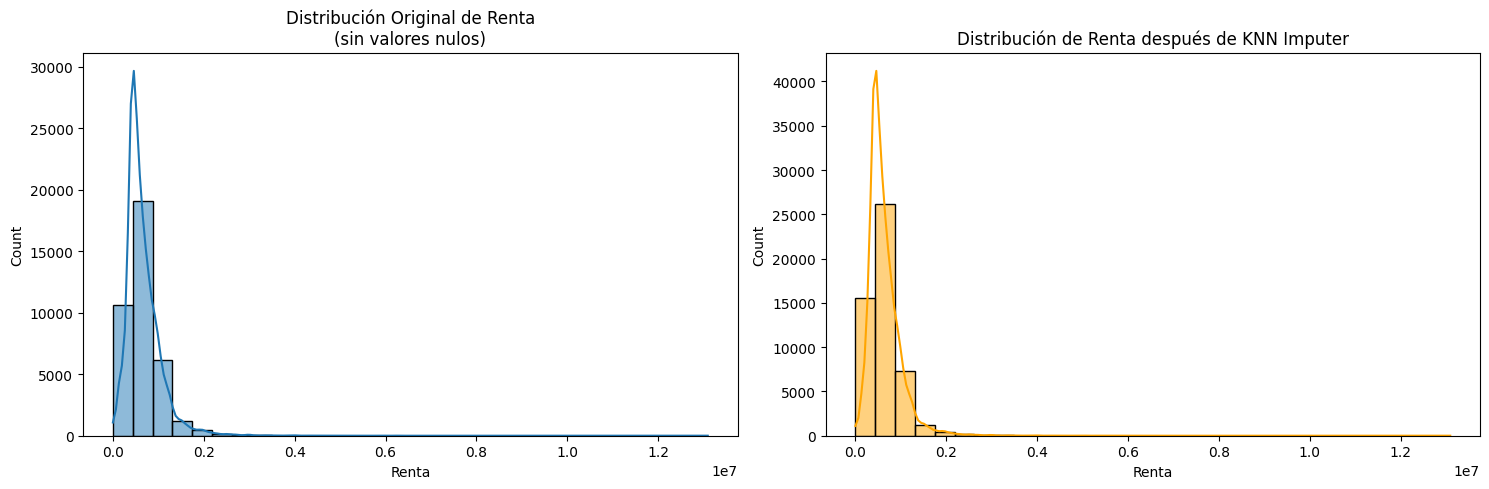


Estadísticas de la variable Renta:
--------------------------------------------------

Antes de la imputación:
count       37759.00
mean       663077.08
std        409279.46
min             1.00
25%        419999.00
50%        567012.00
75%        814903.50
max      13089327.00
Name: Renta, dtype: float64
Valores nulos: 13365 (26.14%)

Después de la imputación:
count       51124.00
mean       634858.20
std        376854.81
min             1.00
25%        409763.00
50%        550400.00
75%        778744.15
max      13089327.00
Name: Renta, dtype: float64
Valores nulos: 0 (0.00%)


In [15]:
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd

# Primero, vamos a seleccionar las variables que usaremos para la imputación de Renta
# Seleccionamos variables que podrían estar relacionadas con la Renta
variables_para_renta = [
    'Renta', 'Edad', 'Consumo', 'CUPO_L1', 'CUPO_MX', 
    'Fac_T12', 'PagoInt_T12', 'PagoNac_T12'
]

# Crear un DataFrame solo con las variables seleccionadas
df_knn = ds_imputado[variables_para_renta].copy()

# Crear el imputador KNN
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Realizar la imputación
df_knn_imputado = pd.DataFrame(
    knn_imputer.fit_transform(df_knn),
    columns=df_knn.columns
)

# Comparar la distribución original vs imputada de Renta
plt.figure(figsize=(15, 5))

# Distribución original
plt.subplot(1, 2, 1)
sns.histplot(ds['Renta'].dropna(), kde=True, bins=30)
plt.title('Distribución Original de Renta\n(sin valores nulos)')
plt.xlabel('Renta')

# Distribución después de KNN
plt.subplot(1, 2, 2)
sns.histplot(df_knn_imputado['Renta'], kde=True, bins=30, color='orange')
plt.title('Distribución de Renta después de KNN Imputer')
plt.xlabel('Renta')

plt.tight_layout()
plt.show()

# Calcular estadísticas antes y después
print("\nEstadísticas de la variable Renta:")
print("-" * 50)
print("\nAntes de la imputación:")
print(ds_imputado['Renta'].describe().round(2))
print(f"Valores nulos: {ds_imputado['Renta'].isnull().sum()} ({(ds_imputado['Renta'].isnull().sum()/len(ds)*100):.2f}%)")

print("\nDespués de la imputación:")
print(df_knn_imputado['Renta'].describe().round(2))
print(f"Valores nulos: {df_knn_imputado['Renta'].isnull().sum()} ({(df_knn_imputado['Renta'].isnull().sum()/len(df_knn_imputado)*100):.2f}%)")

ds_imputado['Renta'] = df_knn_imputado['Renta']

In [16]:
ds_imputado.head(8)

,Id,Region,Renta,Sexo,Subsegmento,Edad,Adicional,Antiguedad,CambioPin,Consumo,...,TxsCCPC_T12,TxsCI_T12,TxsCN_T12,TxsCOL_T12,TxsDebAtm_T12,TxsDebCom_T12,TxsPAT_T12,UsoL1_T12,UsoL2_T12,UsoLI_T12
0,1,13.0,952690.6,M,160,43.0,1,130.0,1.0,0.0,...,1.0,0.0,3.0,0.0,6.0,30.0,0.0,731768.0,25890.0,0.0
1,2,13.0,143640.0,H,160,46.0,0,69.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,244876.0,284632.0,0.0
2,3,13.0,929106.0,H,170,45.0,1,24.0,1.0,0.0,...,0.0,0.0,3.0,0.0,16.0,5.0,0.0,94415.0,0.0,0.0
3,4,13.0,172447.0,H,151,46.0,1,134.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,358807.0,14660.0,0.0
4,5,13.0,805250.0,H,170,46.0,1,116.0,1.0,0.0,...,3.0,0.0,6.0,0.0,0.0,0.0,0.0,67516.0,234211.0,0.0
5,6,13.0,707664.0,H,170,47.0,1,67.0,1.0,0.0,...,1.0,0.0,2.0,0.0,28.0,2.0,0.0,0.0,165188.0,0.0
6,7,13.0,1022833.0,H,811,48.0,0,21.0,1.0,0.0,...,1.0,0.0,25.0,0.0,0.0,0.0,1.0,393169.0,178385.0,0.0
7,8,13.0,797777.0,H,170,46.0,1,69.0,1.0,0.0,...,1.0,0.0,1.0,0.0,18.0,0.0,0.0,0.0,45270.0,0.0


In [17]:
# Convertir las columnas numéricas a entero
for columna in cols_numericas:
    ds_imputado[columna] = ds_imputado[columna].round().astype('int64')

# Verificar los cambios
print("Tipos de datos después de la conversión:")
print("-" * 50)
for columna in cols_numericas:
    print(f"{columna}: {ds_imputado[columna].dtype}")

# Mostrar algunas estadísticas para verificar el cambio
print("\nPrimeras filas de algunas columnas numéricas:")
print("-" * 50)
print(ds_imputado[cols_numericas[:5]].head())

# Verificar que no hay decimales
print("\nVerificación de valores decimales:")
print("-" * 50)
for columna in cols_numericas:
    if (ds_imputado[columna] % 1 != 0).any():
        print(f"¡Advertencia! {columna} aún tiene decimales")

Tipos de datos después de la conversión:
--------------------------------------------------
Edad: int64
Antiguedad: int64
Consumo: int64
CUPO_L1: int64
CUPO_MX: int64
CUPO_L2: int64
Col_T12: int64
ColL1TE_T12: int64
EeccInt_T12: int64
EeccNac_T12: int64
Fac_T12: int64
FacAI_T12: int64
FacAN_T12: int64
FacCCOT_T12: int64
FacCCPC_T12: int64
FacCI_T12: int64
FacCN_T12: int64
FacCOL_T12: int64
FacDebAtm_T12: int64
FacDebCom_T12: int64
FacPAT_T12: int64
PagoInt_T12: int64
PagoNac_T12: int64
Txs_T12: int64
TxsAI_T12: int64
TxsAN_T12: int64
TxsCCOT_T12: int64
TxsCCPC_T12: int64
TxsCI_T12: int64
TxsCN_T12: int64
TxsCOL_T12: int64
TxsDebAtm_T12: int64
TxsDebCom_T12: int64
TxsPAT_T12: int64
UsoL1_T12: int64
UsoL2_T12: int64
UsoLI_T12: int64

Primeras filas de algunas columnas numéricas:
--------------------------------------------------
0  Edad  Antiguedad  Consumo  CUPO_L1  CUPO_MX
0    43         130        0   798000     1210
1    46          69        0   750000     1000
2    45          24 

In [18]:
ds_imputado.count()


0
Id               51124
Region           51124
Renta            51124
Sexo             51124
Subsegmento      51124
                 ...  
TxsDebCom_T12    51124
TxsPAT_T12       51124
UsoL1_T12        51124
UsoL2_T12        51124
UsoLI_T12        51124
Length: 61, dtype: int64

In [19]:
from scipy import stats
import numpy as np

# Ejemplo de cálculo de Z-score
z_scores = stats.zscore(ds_imputado['Renta'])

# Identificar outliers (típicamente |z| > 3)
outliers = np.abs(z_scores) > 3
print(f"Número de outliers en Renta: {outliers.sum()}")
variables_interes = ['Renta', 'Edad', 'Consumo']

for variable in variables_interes:
    z_scores = stats.zscore(ds_imputado[variable])
    outliers = np.abs(z_scores) > 3
    print(f"\nAnálisis de {variable}:")
    print(f"Total de outliers: {outliers.sum()}")
    print(f"Porcentaje de outliers: {(outliers.sum()/len(ds_imputado)*100):.2f}%")

Número de outliers en Renta: 746

Análisis de Renta:
Total de outliers: 746
Porcentaje de outliers: 1.46%

Análisis de Edad:
Total de outliers: 289
Porcentaje de outliers: 0.57%

Análisis de Consumo:
Total de outliers: 46
Porcentaje de outliers: 0.09%



Columna: Edad
Límite inferior: 1.00
Límite superior: 73.00
Outliers encontrados: 778
Porcentaje de outliers: 1.52%


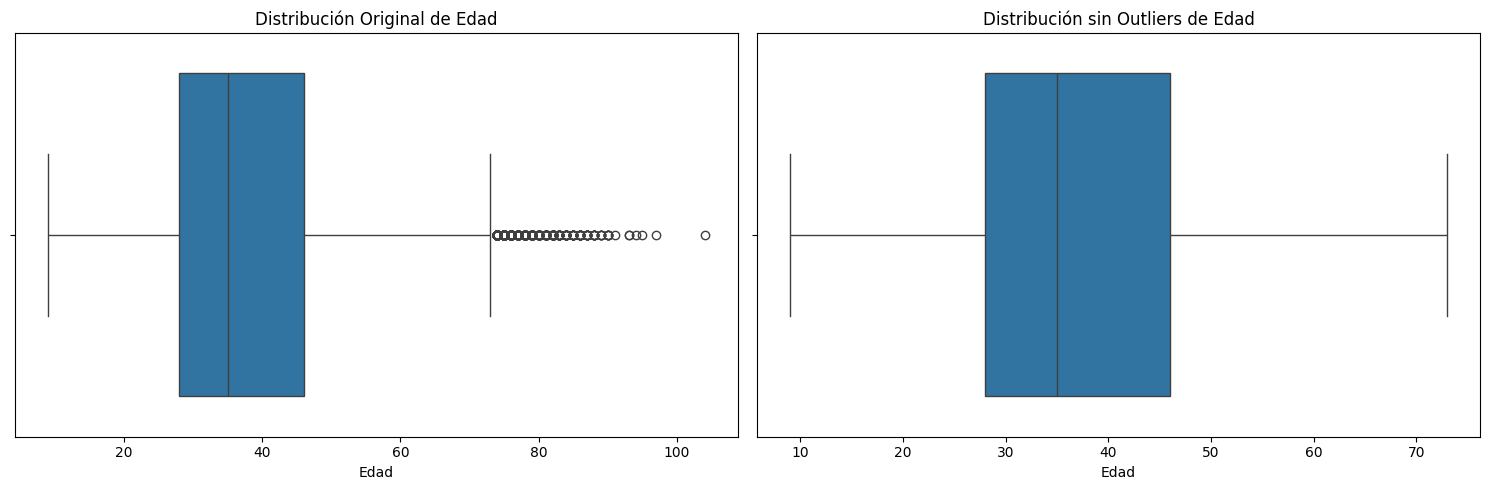


Columna: Antiguedad
Límite inferior: -46.00
Límite superior: 114.00
Outliers encontrados: 2670
Porcentaje de outliers: 5.22%


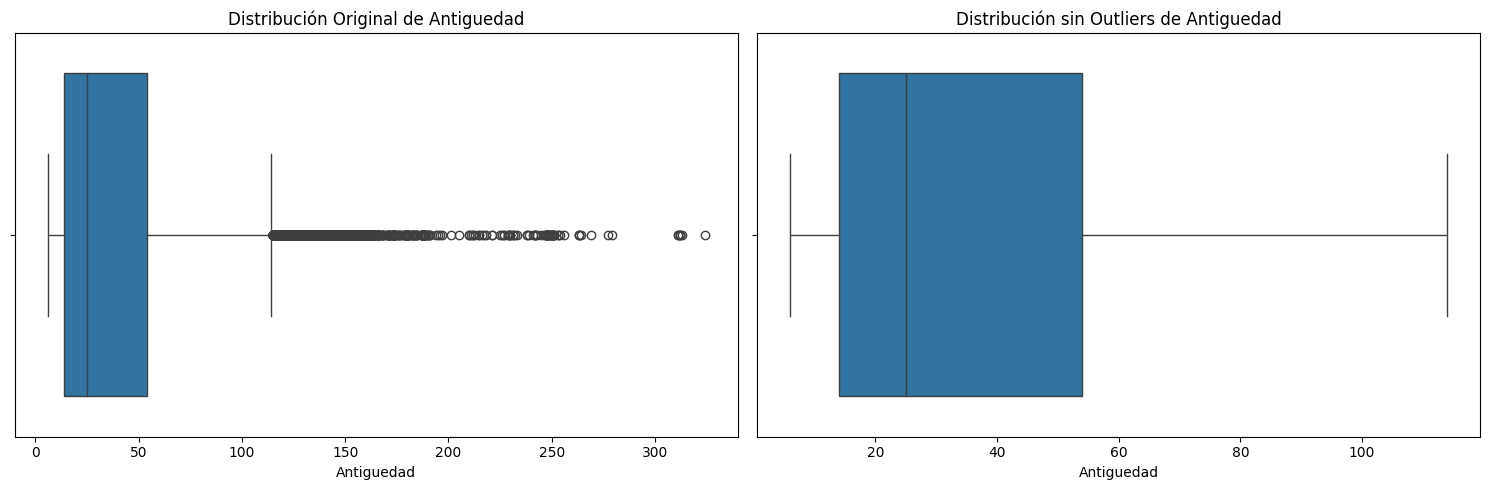


Columna: Consumo
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 46
Porcentaje de outliers: 0.09%


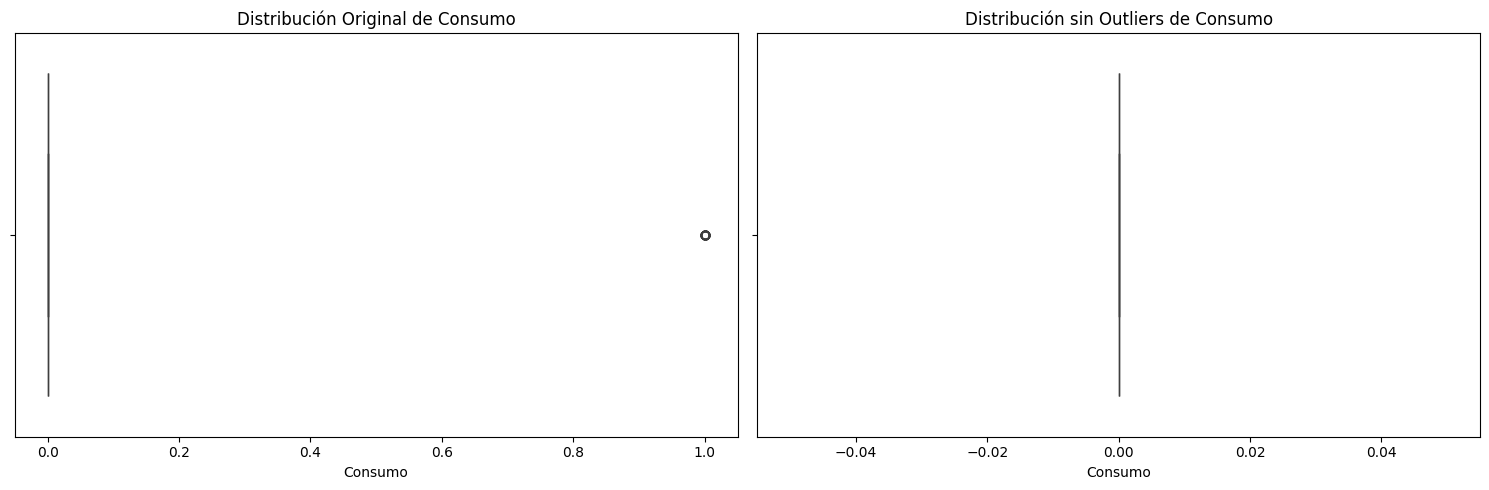


Columna: CUPO_L1
Límite inferior: -1290500.00
Límite superior: 3217500.00
Outliers encontrados: 2448
Porcentaje de outliers: 4.79%


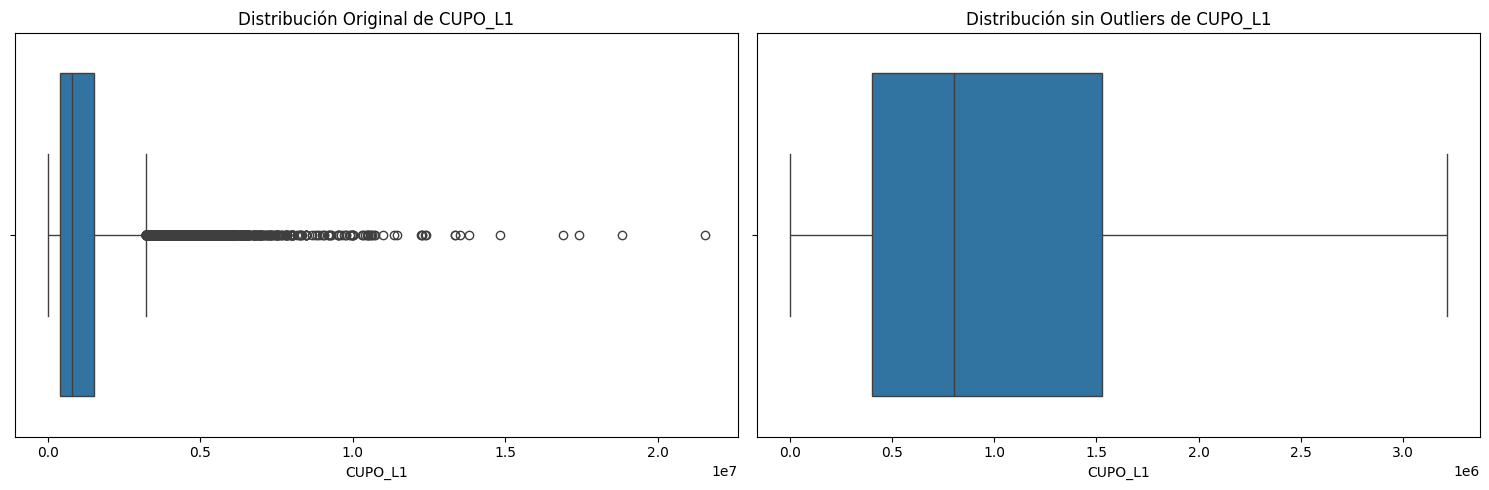


Columna: CUPO_MX
Límite inferior: -2100.00
Límite superior: 4300.00
Outliers encontrados: 2756
Porcentaje de outliers: 5.39%


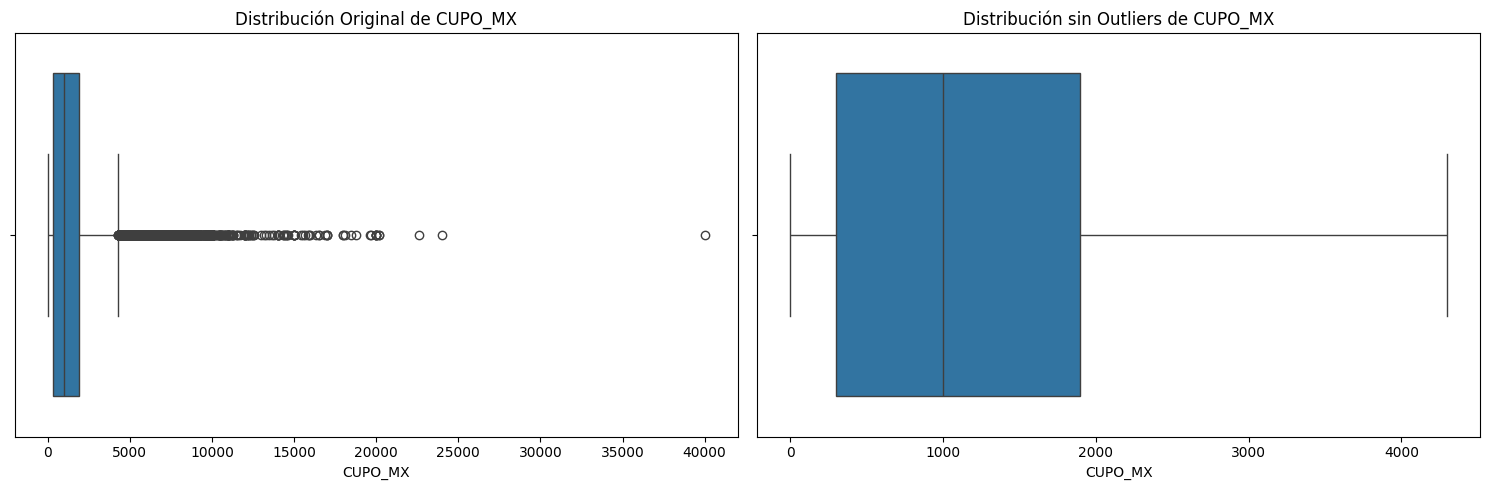

[12/05/24 21:43:53] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_11260\3900413875.py:18:    ]8;id=840165;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=946451;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-351543.875'                
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_limpio.loc[df_limpio[columna] < limite_inferior, columna] =                      
                             limite_inferior                                                                       
                                                                                                                   


Columna: CUPO_L2
Límite inferior: -351543.88
Límite superior: 588573.12
Outliers encontrados: 6617
Porcentaje de outliers: 12.94%


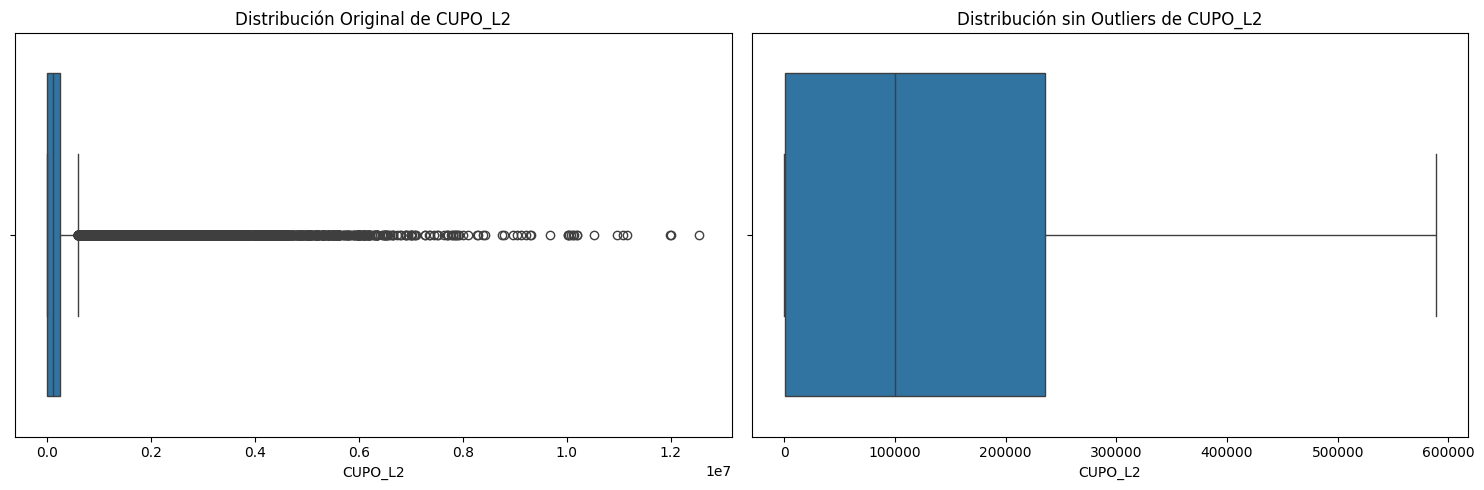

                    WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_11260\3900413875.py:18:    ]8;id=191002;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=481720;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-336919.5'                  
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_limpio.loc[df_limpio[columna] < limite_inferior, columna] =                      
                             limite_inferior                                                                       
                                                                                                                   


Columna: Col_T12
Límite inferior: -336919.50
Límite superior: 649484.50
Outliers encontrados: 4699
Porcentaje de outliers: 9.19%


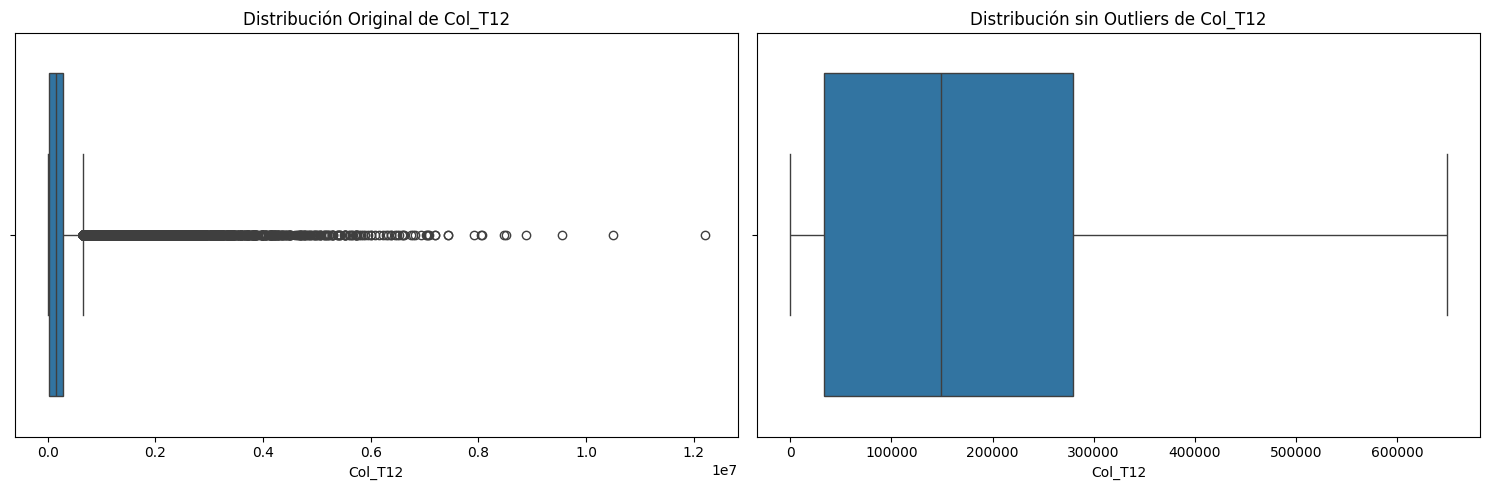


Columna: ColL1TE_T12
Límite inferior: -162054.00
Límite superior: 270090.00
Outliers encontrados: 5681
Porcentaje de outliers: 11.11%


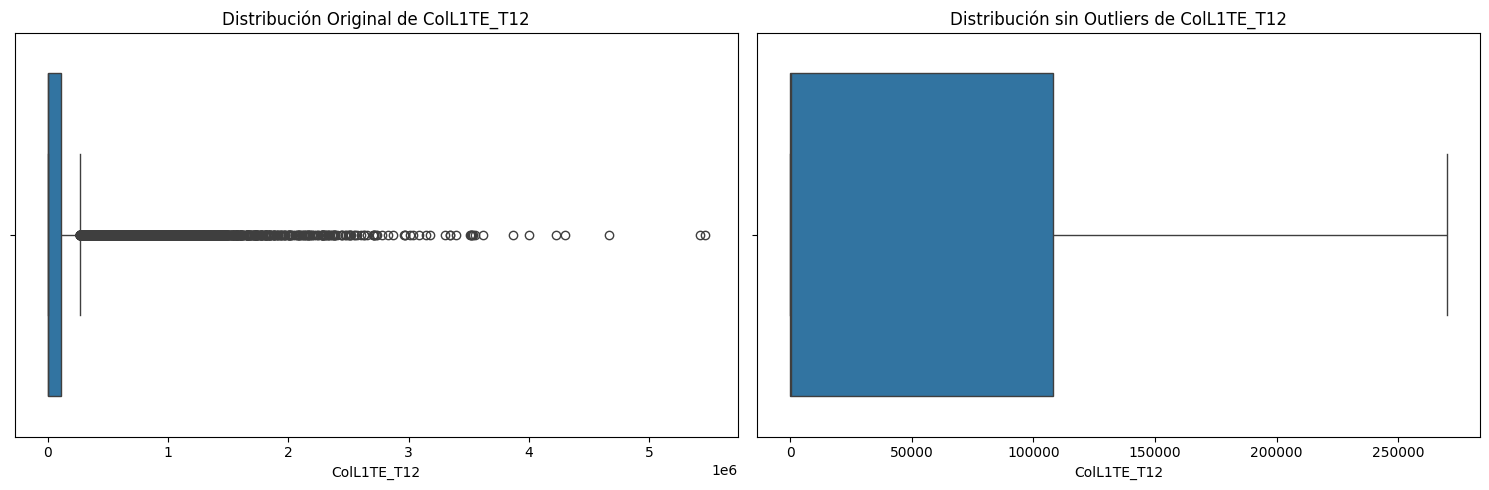


Columna: EeccInt_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 10511
Porcentaje de outliers: 20.56%


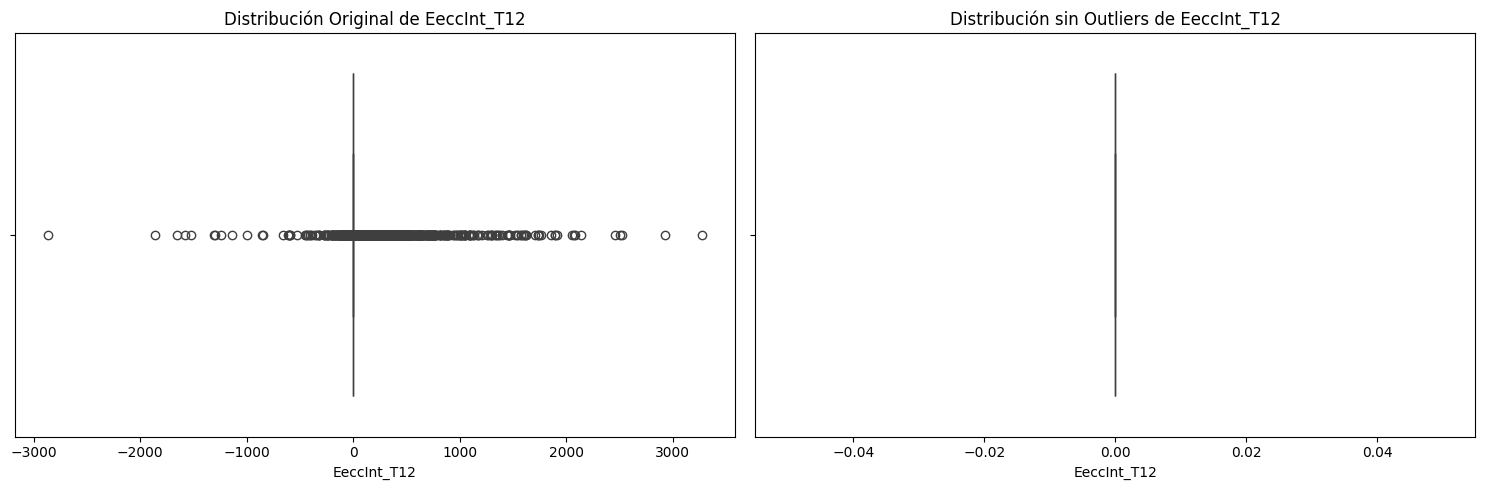

[12/05/24 21:43:55] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_11260\3900413875.py:18:    ]8;id=266705;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=169773;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-211047.5'                  
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_limpio.loc[df_limpio[columna] < limite_inferior, columna] =                      
                             limite_inferior                                                                       
                                                                                                                   


Columna: EeccNac_T12
Límite inferior: -211047.50
Límite superior: 407892.50
Outliers encontrados: 5446
Porcentaje de outliers: 10.65%


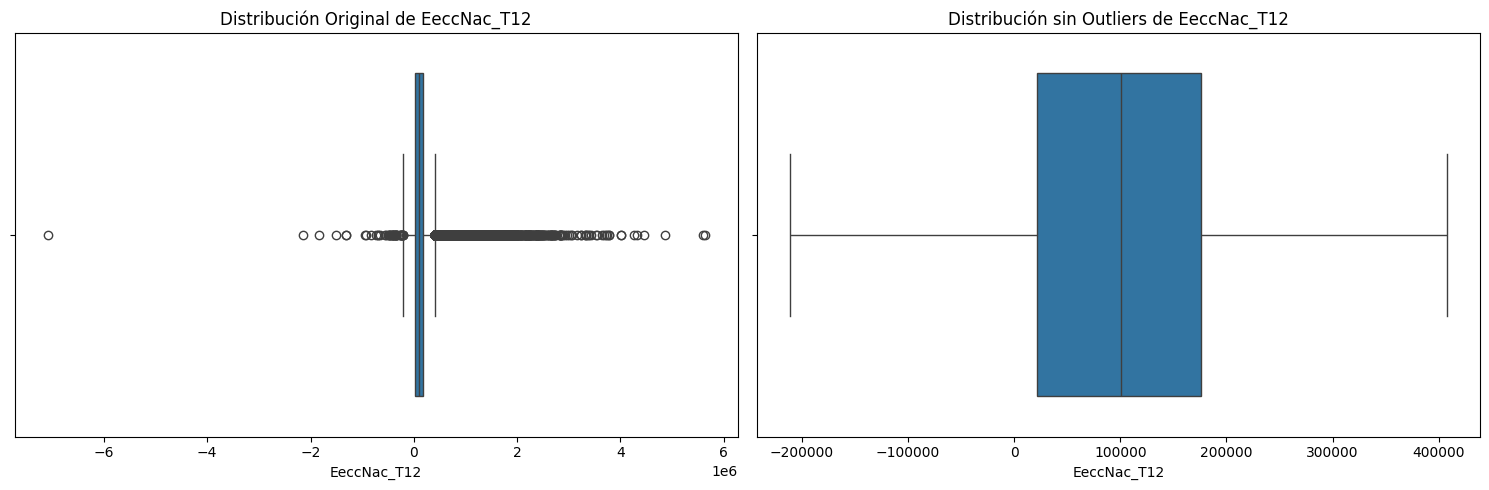


Columna: Fac_T12
Límite inferior: -102960.00
Límite superior: 171600.00
Outliers encontrados: 4690
Porcentaje de outliers: 9.17%


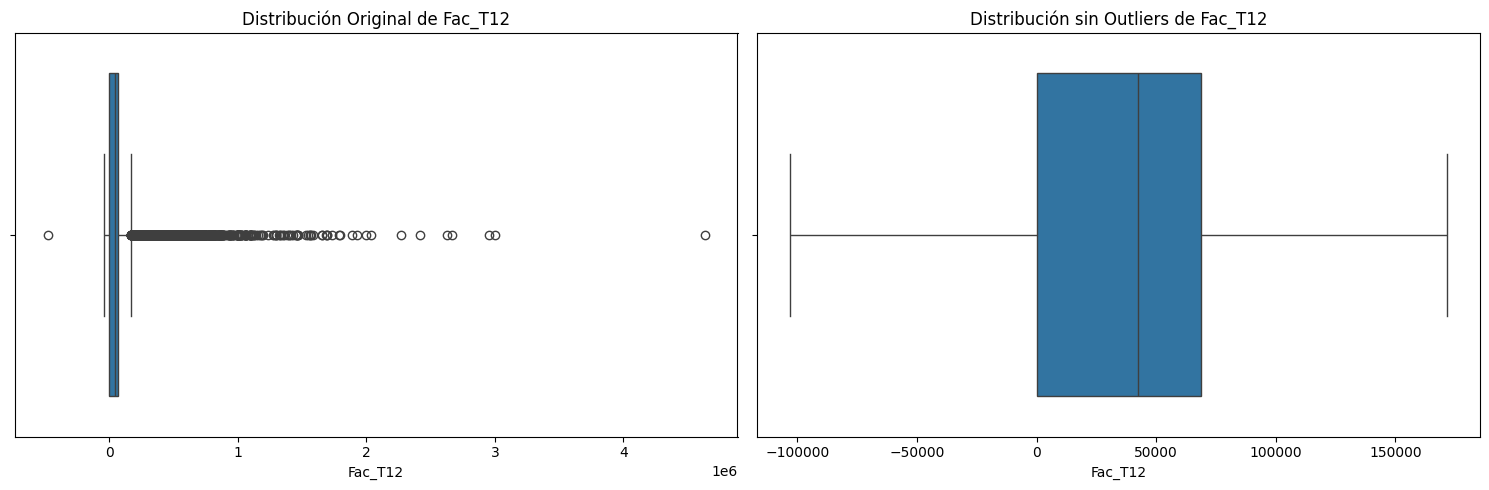


Columna: FacAI_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 8361
Porcentaje de outliers: 16.35%


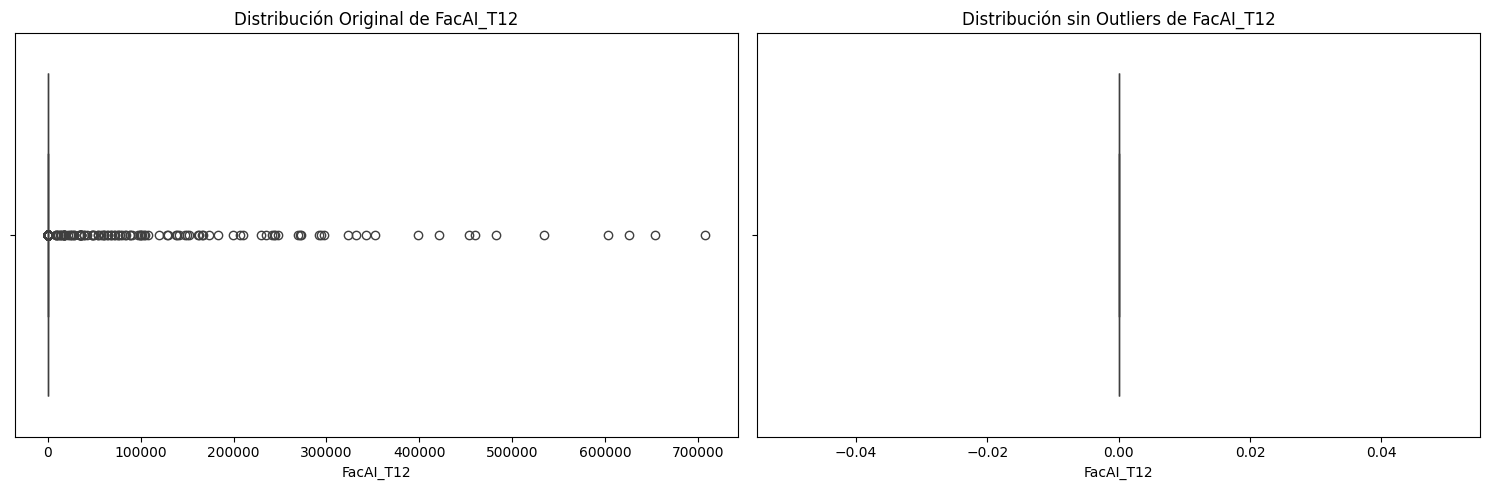


Columna: FacAN_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 9194
Porcentaje de outliers: 17.98%


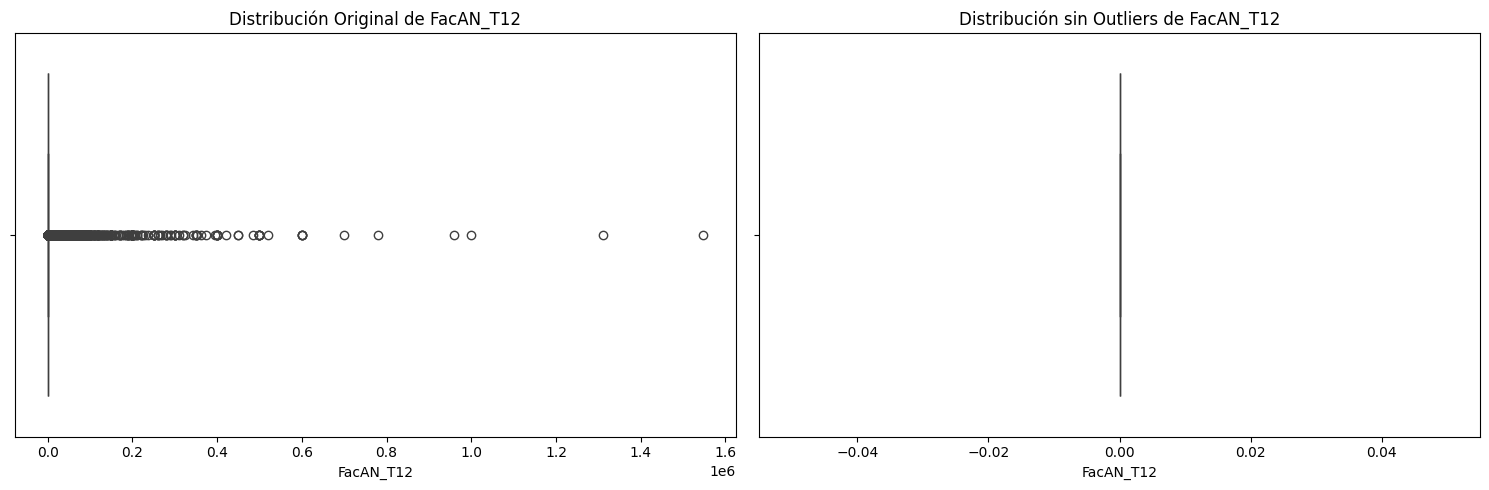


Columna: FacCCOT_T12
Límite inferior: -7485.00
Límite superior: 12475.00
Outliers encontrados: 12325
Porcentaje de outliers: 24.11%


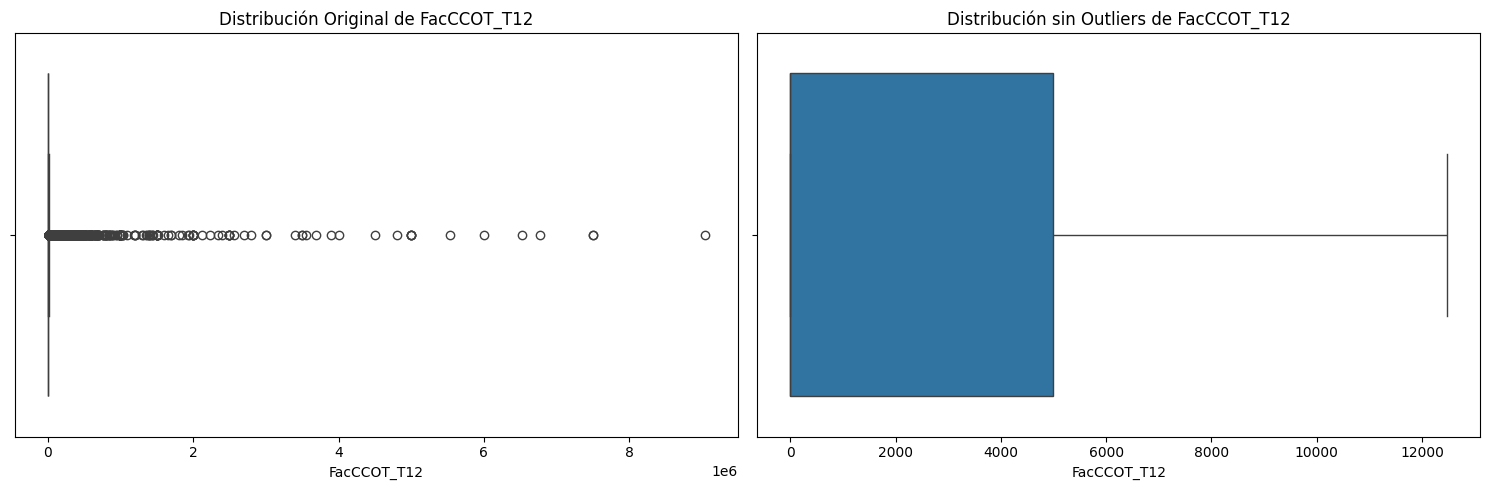

[12/05/24 21:43:59] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_11260\3900413875.py:18:    ]8;id=523541;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=390479;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-29251.5'                   
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_limpio.loc[df_limpio[columna] < limite_inferior, columna] =                      
                             limite_inferior                                                                       
                                                                                                                   


Columna: FacCCPC_T12
Límite inferior: -29251.50
Límite superior: 48752.50
Outliers encontrados: 5004
Porcentaje de outliers: 9.79%


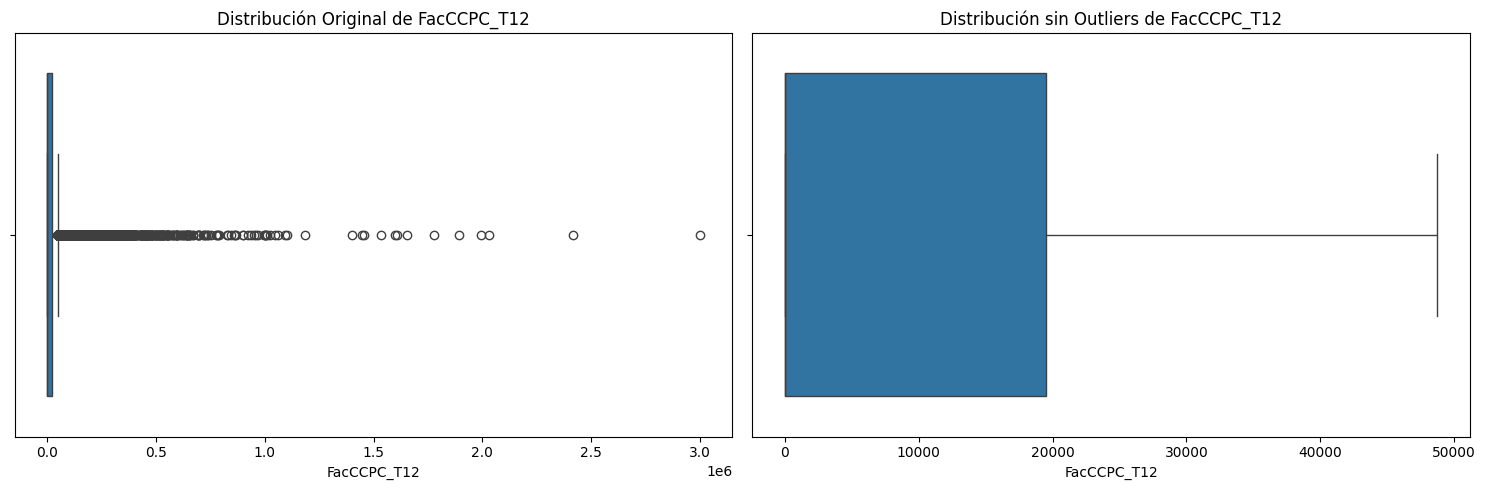


Columna: FacCI_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 9678
Porcentaje de outliers: 18.93%


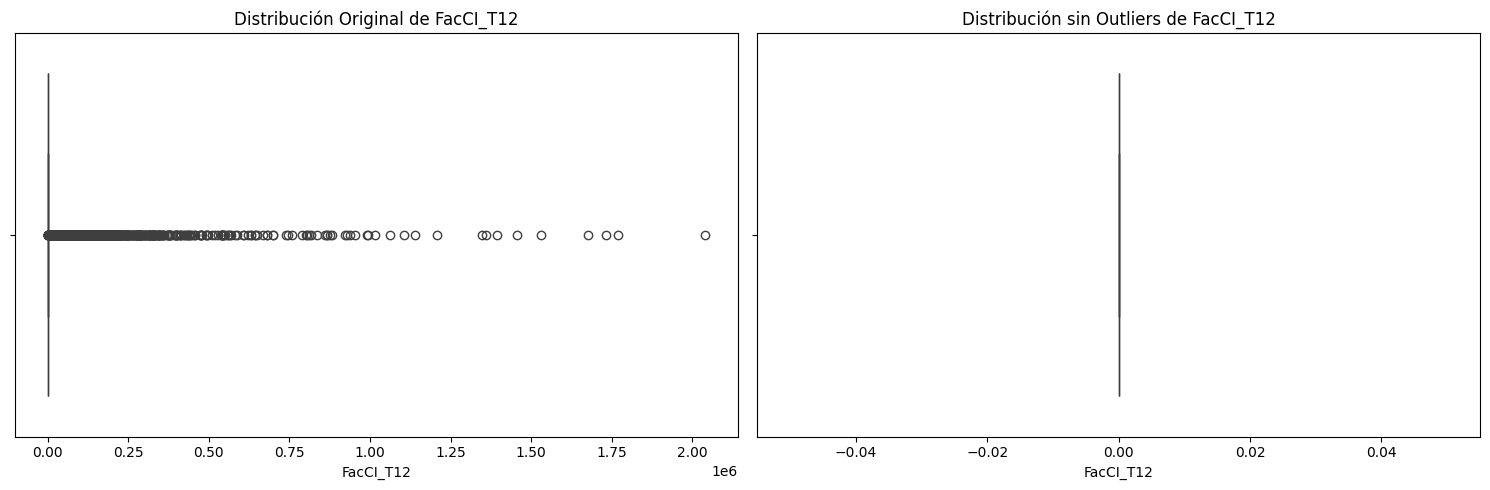

[12/05/24 21:44:00] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_11260\3900413875.py:18:    ]8;id=824412;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=139207;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-85306.5'                   
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_limpio.loc[df_limpio[columna] < limite_inferior, columna] =                      
                             limite_inferior                                                                       
                                                                                                                   


Columna: FacCN_T12
Límite inferior: -85306.50
Límite superior: 142177.50
Outliers encontrados: 5085
Porcentaje de outliers: 9.95%


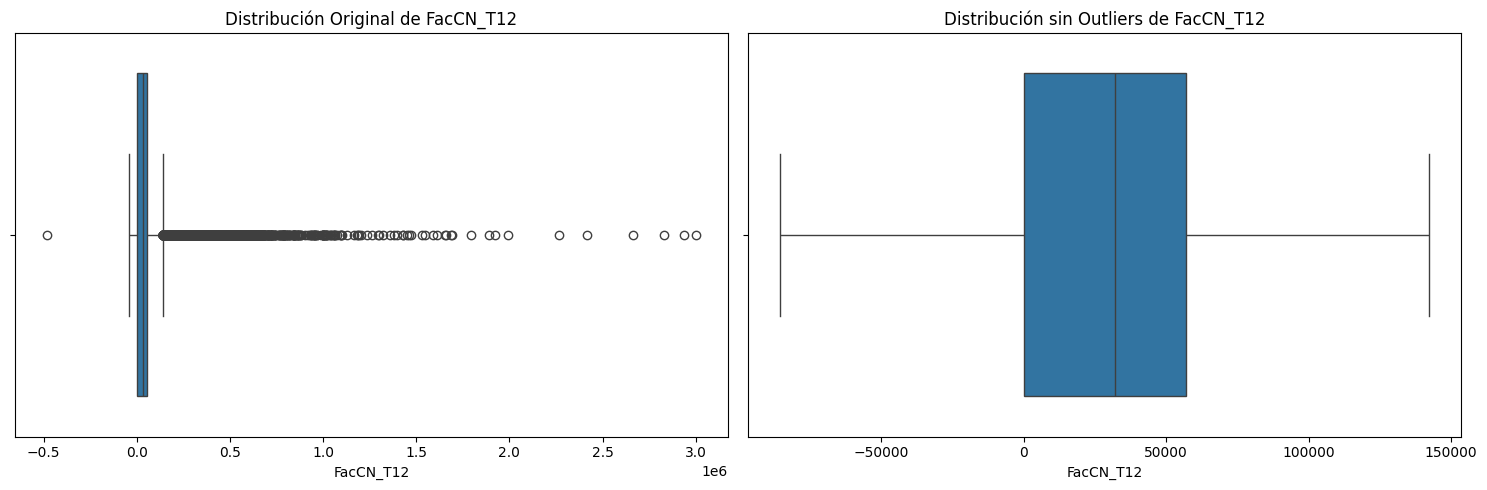


Columna: FacCOL_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 8387
Porcentaje de outliers: 16.41%


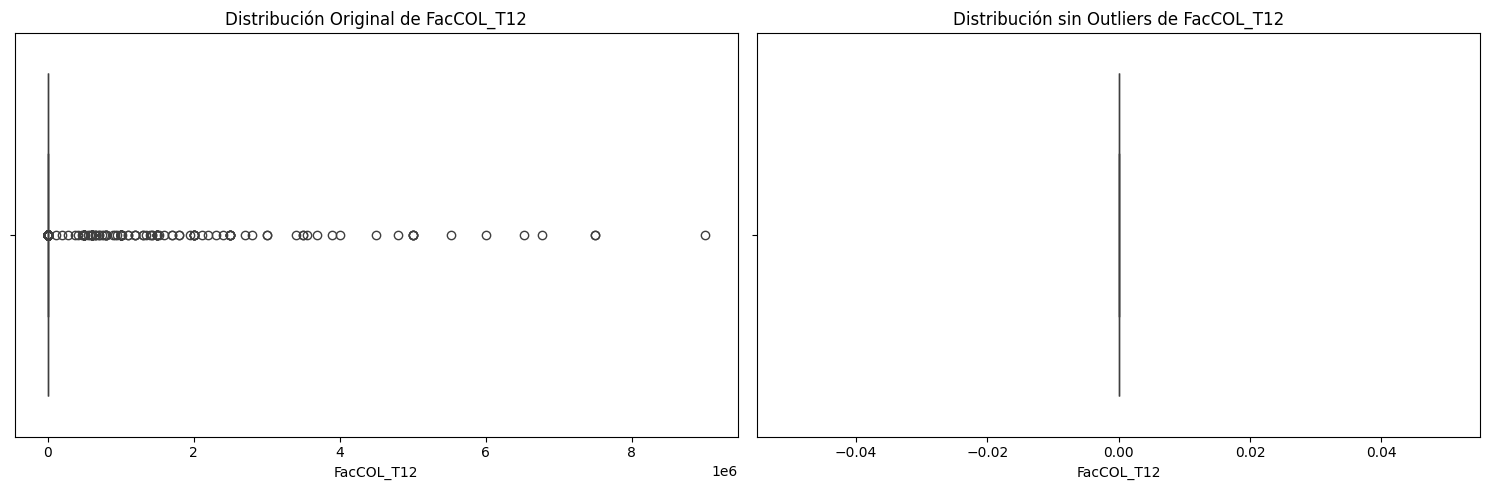


Columna: FacDebAtm_T12
Límite inferior: -376500.00
Límite superior: 627500.00
Outliers encontrados: 4334
Porcentaje de outliers: 8.48%


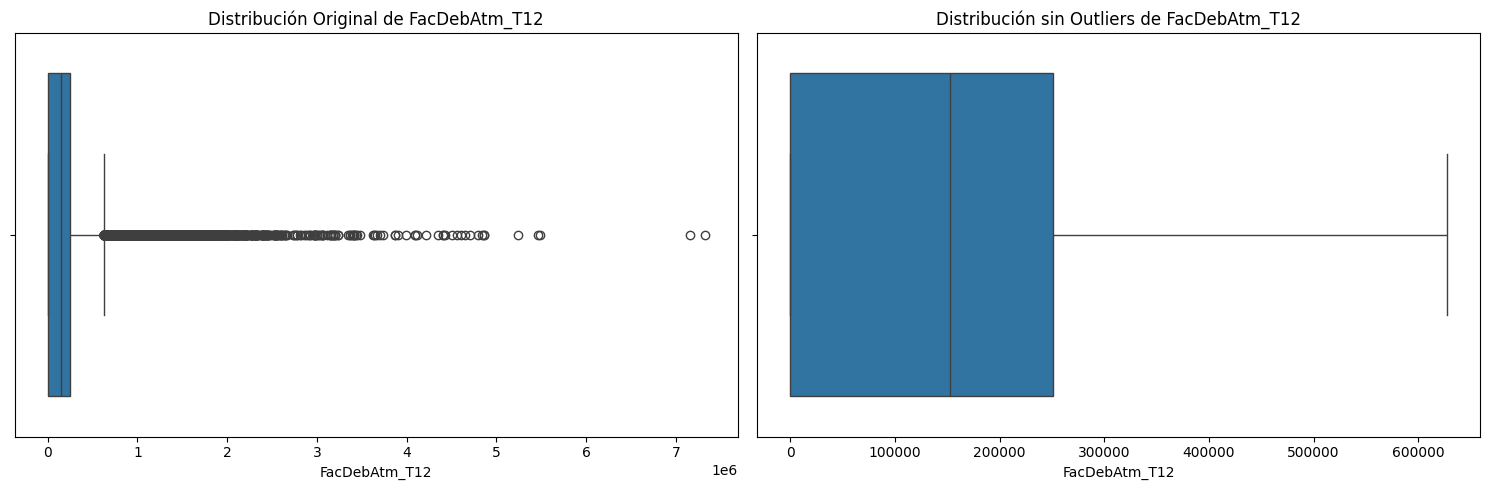

[12/05/24 21:44:02] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_11260\3900413875.py:18:    ]8;id=212668;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=562772;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-91252.5'                   
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_limpio.loc[df_limpio[columna] < limite_inferior, columna] =                      
                             limite_inferior                                                                       
                                                                                                                   


Columna: FacDebCom_T12
Límite inferior: -91252.50
Límite superior: 152087.50
Outliers encontrados: 5619
Porcentaje de outliers: 10.99%


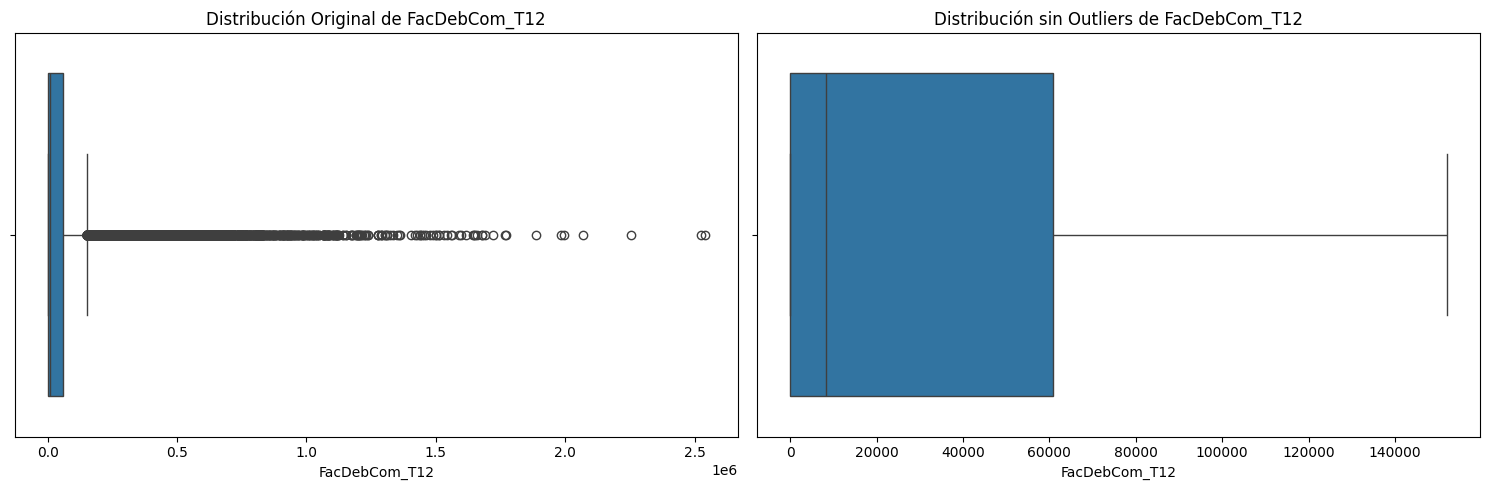

[12/05/24 21:44:03] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_11260\3900413875.py:18:    ]8;id=147545;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=631803;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-6442.5' has                
                             dtype incompatible with int64, please explicitly cast to a compatible                 
                             dtype first.                                                                          
                               df_limpio.loc[df_limpio[columna] < limite_inferior, columna] =                      
                             limite_inferior                                                                       
                                                                                                                   


Columna: FacPAT_T12
Límite inferior: -6442.50
Límite superior: 10737.50
Outliers encontrados: 3727
Porcentaje de outliers: 7.29%


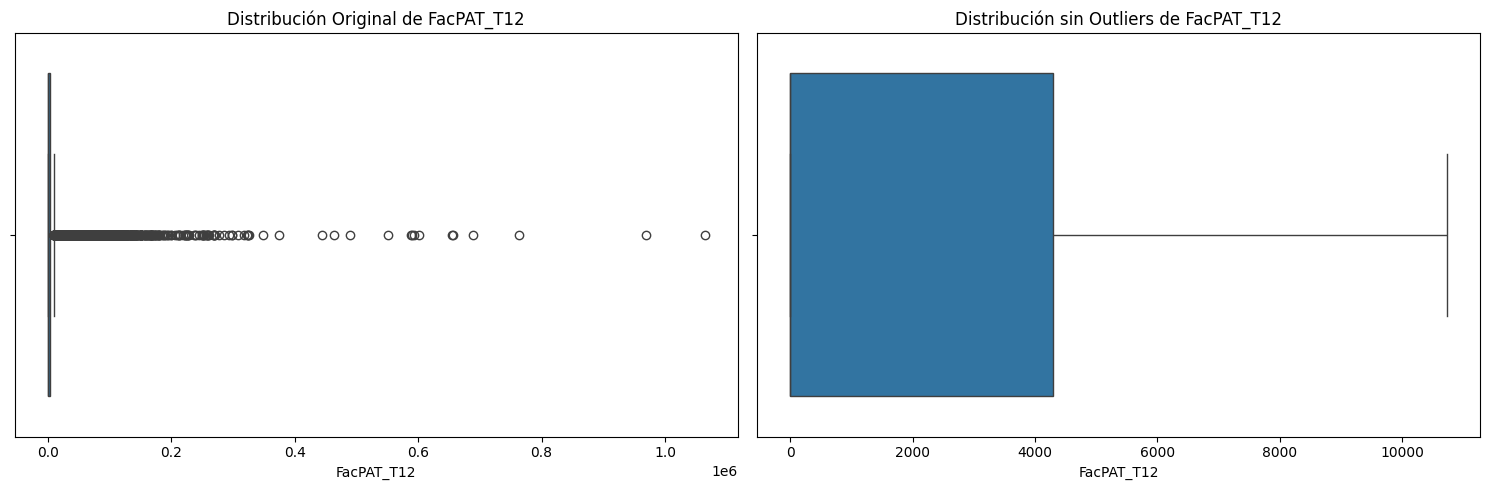


Columna: PagoInt_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 8525
Porcentaje de outliers: 16.68%


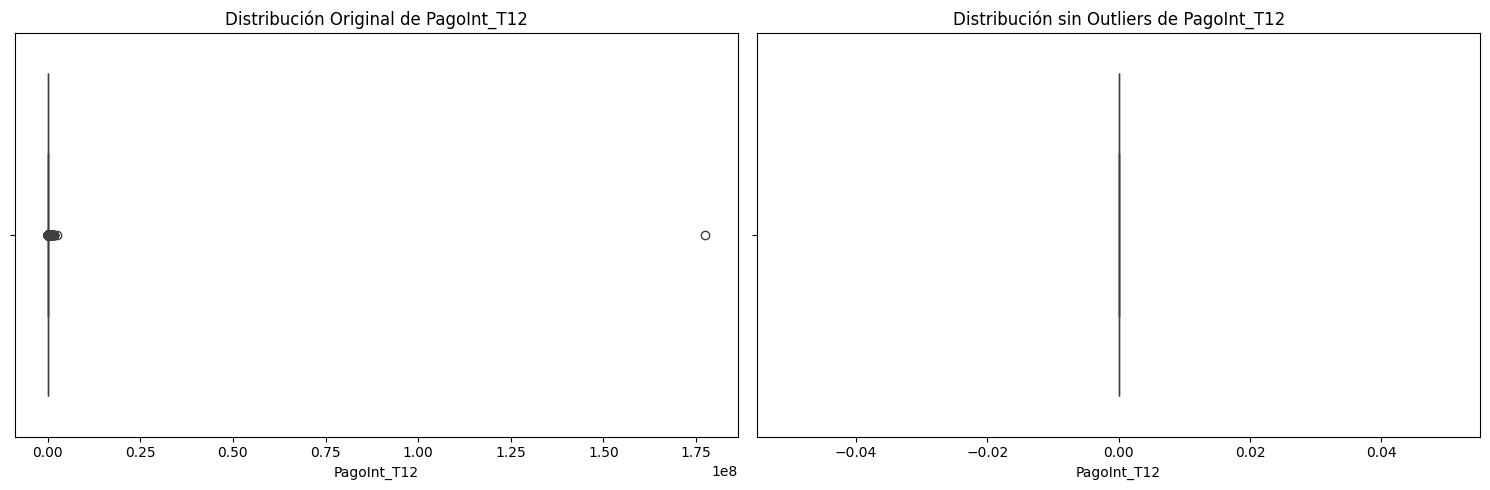


Columna: PagoNac_T12
Límite inferior: -101355.00
Límite superior: 176925.00
Outliers encontrados: 4461
Porcentaje de outliers: 8.73%


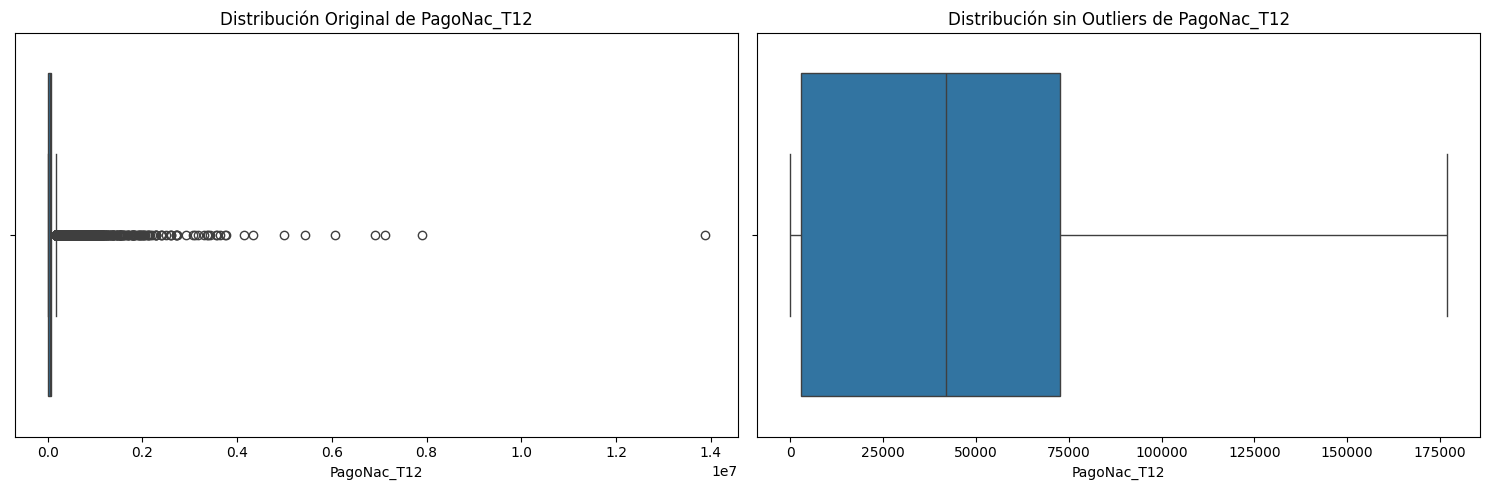

[12/05/24 21:44:05] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_11260\3900413875.py:18:    ]8;id=201407;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=994347;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-4.5' has                   
                             dtype incompatible with int64, please explicitly cast to a compatible                 
                             dtype first.                                                                          
                               df_limpio.loc[df_limpio[columna] < limite_inferior, columna] =                      
                             limite_inferior                                                                       
                                                                                                                   


Columna: Txs_T12
Límite inferior: -4.50
Límite superior: 7.50
Outliers encontrados: 3678
Porcentaje de outliers: 7.19%


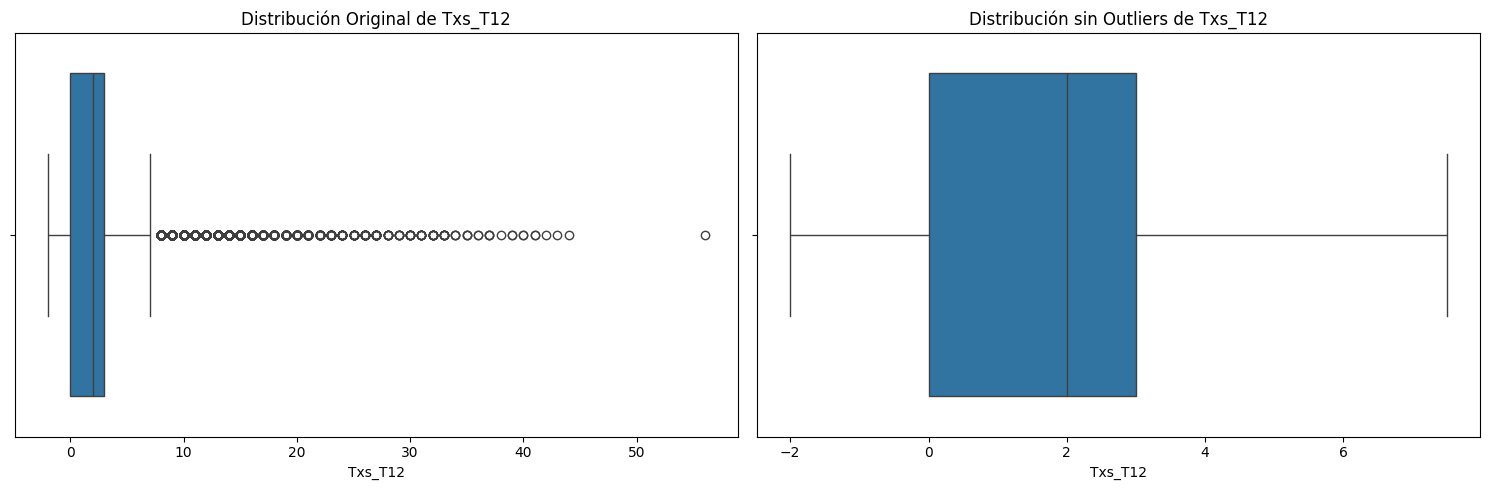


Columna: TxsAI_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 110
Porcentaje de outliers: 0.22%


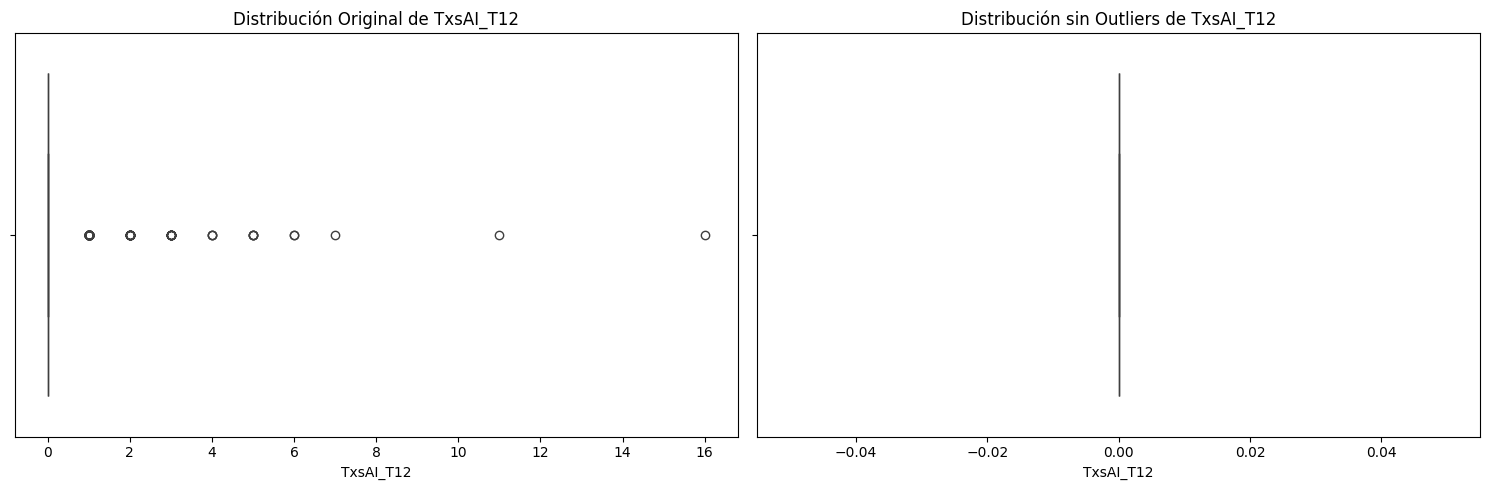


Columna: TxsAN_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 943
Porcentaje de outliers: 1.84%


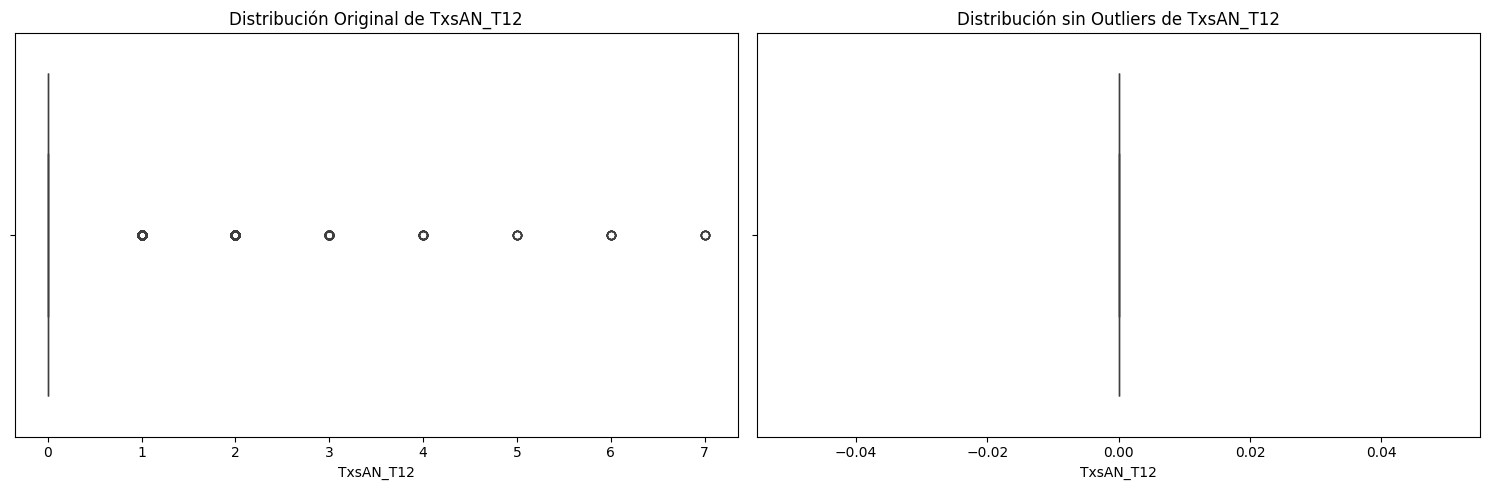


Columna: TxsCCOT_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 4616
Porcentaje de outliers: 9.03%


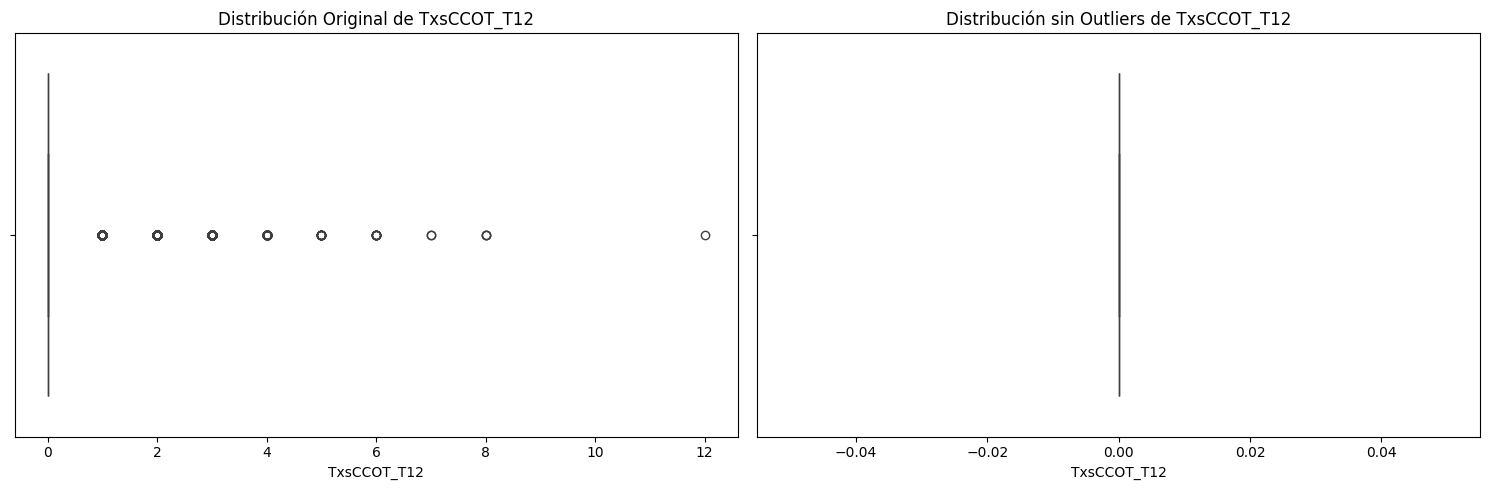

[12/05/24 21:44:08] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_11260\3900413875.py:18:    ]8;id=117682;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=67945;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-1.5' has                   
                             dtype incompatible with int64, please explicitly cast to a compatible                 
                             dtype first.                                                                          
                               df_limpio.loc[df_limpio[columna] < limite_inferior, columna] =                      
                             limite_inferior                                                                       
                                                                                                                   


Columna: TxsCCPC_T12
Límite inferior: -1.50
Límite superior: 2.50
Outliers encontrados: 2577
Porcentaje de outliers: 5.04%


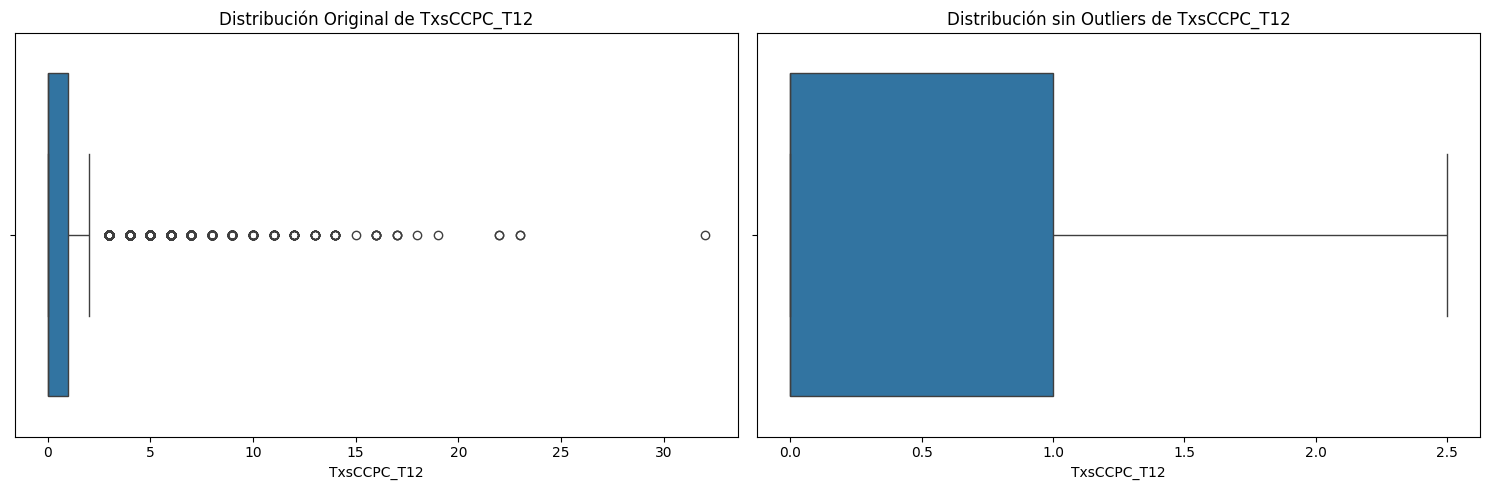


Columna: TxsCI_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 1427
Porcentaje de outliers: 2.79%


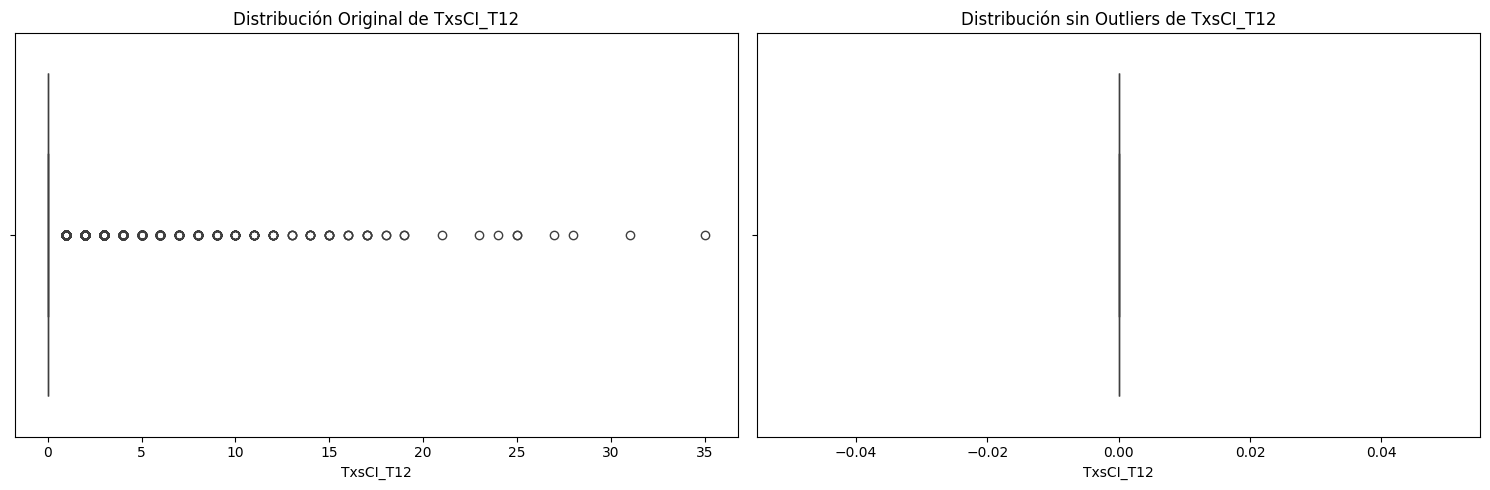


Columna: TxsCN_T12
Límite inferior: -3.00
Límite superior: 5.00
Outliers encontrados: 5246
Porcentaje de outliers: 10.26%


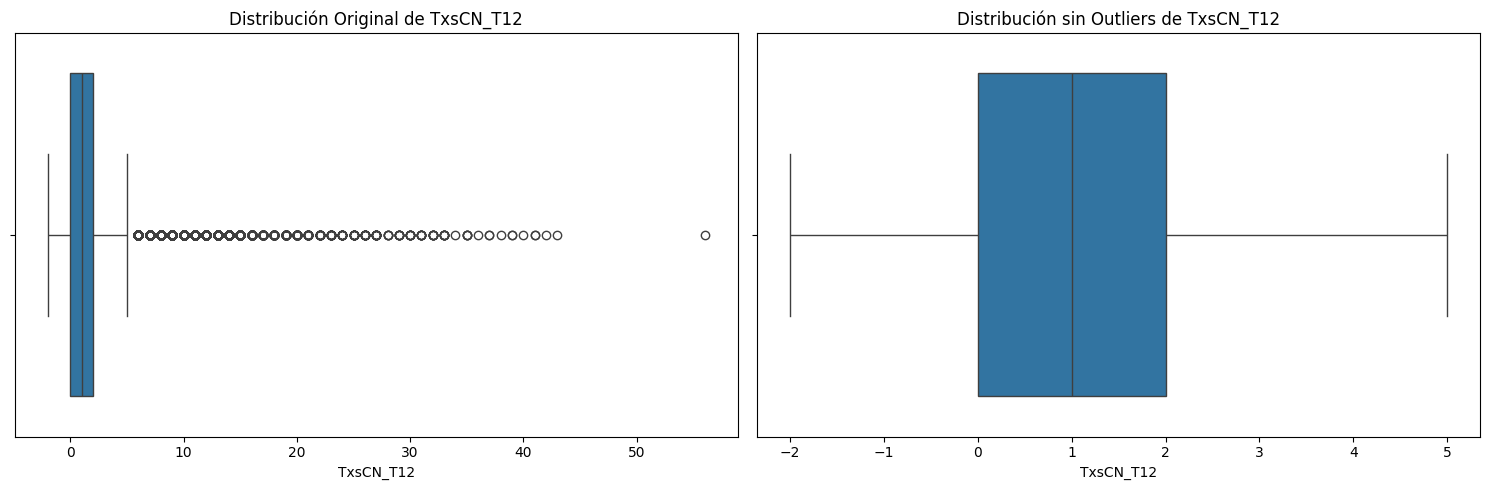


Columna: TxsCOL_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 136
Porcentaje de outliers: 0.27%


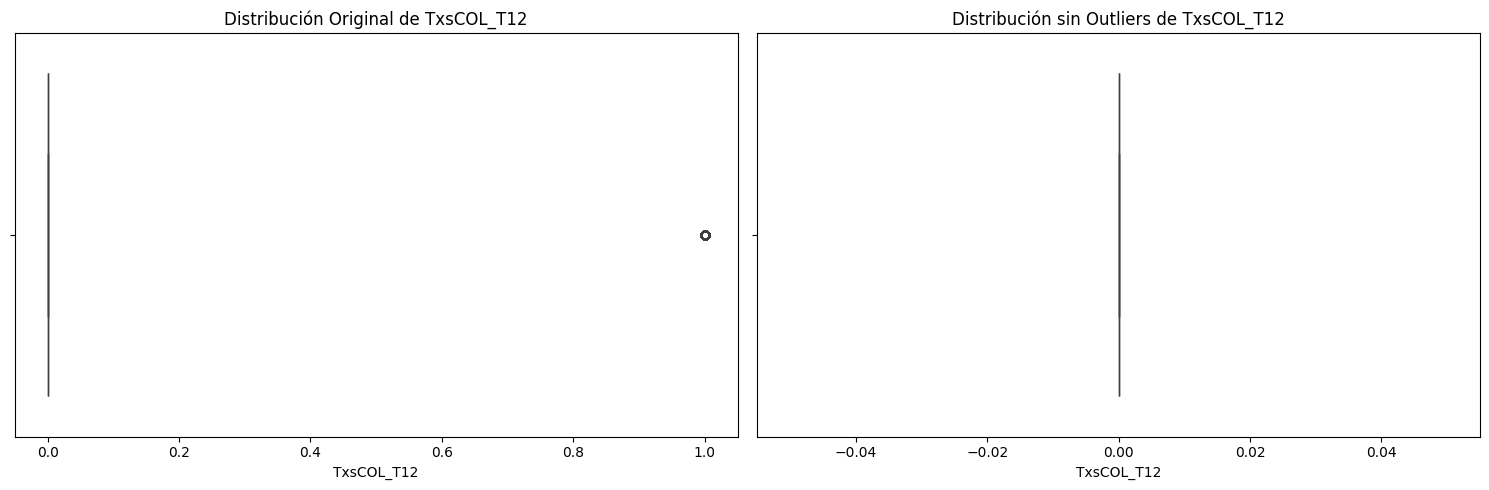

[12/05/24 21:44:11] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_11260\3900413875.py:18:    ]8;id=246771;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=644473;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-10.5' has                  
                             dtype incompatible with int64, please explicitly cast to a compatible                 
                             dtype first.                                                                          
                               df_limpio.loc[df_limpio[columna] < limite_inferior, columna] =                      
                             limite_inferior                                                                       
                                                                                                                   


Columna: TxsDebAtm_T12
Límite inferior: -10.50
Límite superior: 17.50
Outliers encontrados: 3265
Porcentaje de outliers: 6.39%


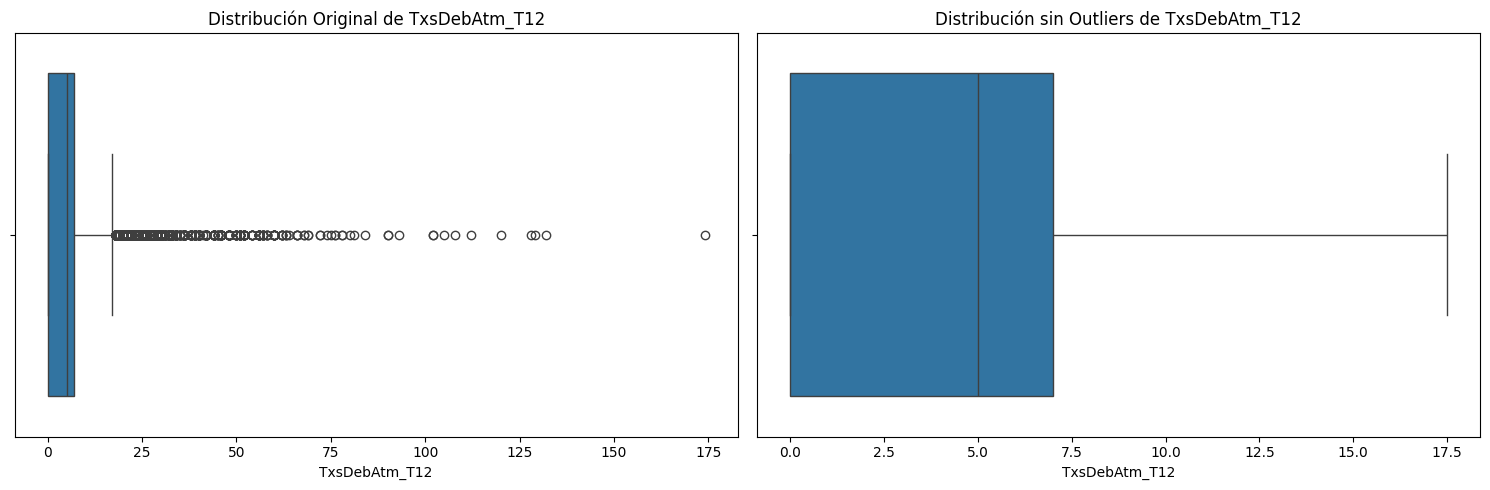


Columna: TxsDebCom_T12
Límite inferior: -6.00
Límite superior: 10.00
Outliers encontrados: 5886
Porcentaje de outliers: 11.51%


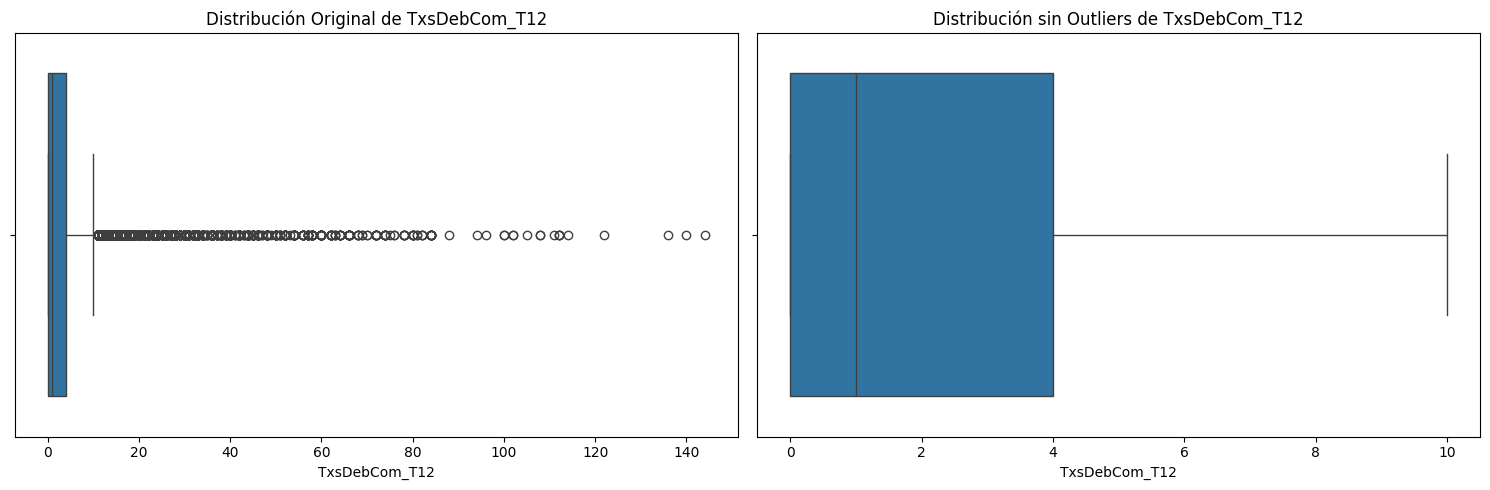


Columna: TxsPAT_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 5977
Porcentaje de outliers: 11.69%


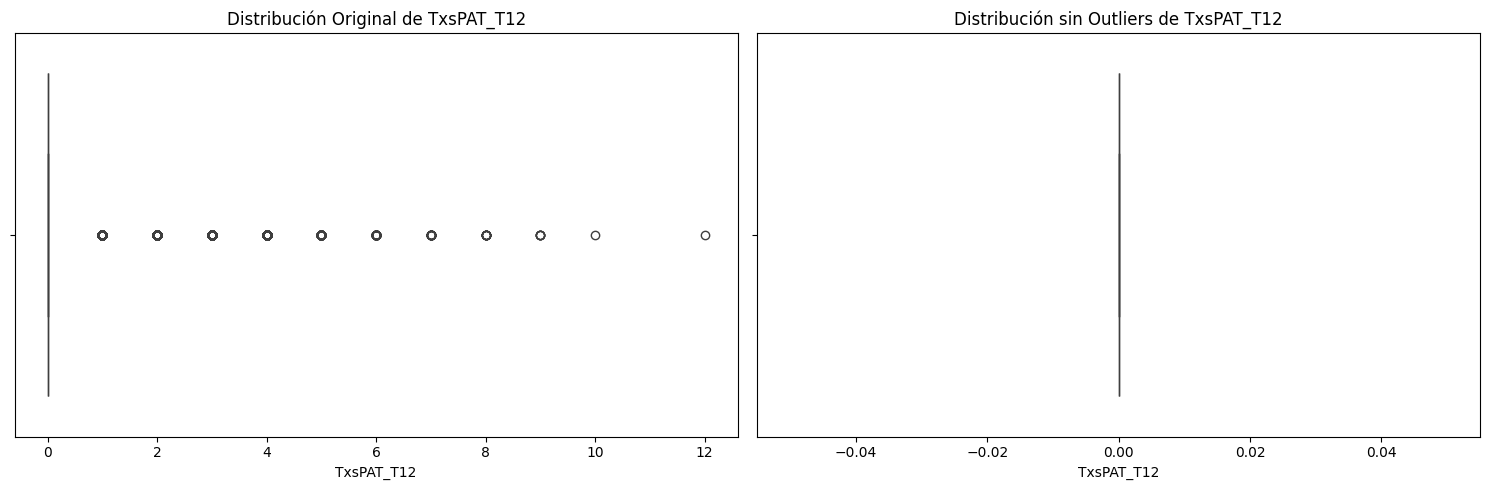

[12/05/24 21:44:13] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_11260\3900413875.py:18:    ]8;id=427783;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=574959;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-225712.5'                  
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_limpio.loc[df_limpio[columna] < limite_inferior, columna] =                      
                             limite_inferior                                                                       
                                                                                                                   


Columna: UsoL1_T12
Límite inferior: -225712.50
Límite superior: 402827.50
Outliers encontrados: 5356
Porcentaje de outliers: 10.48%


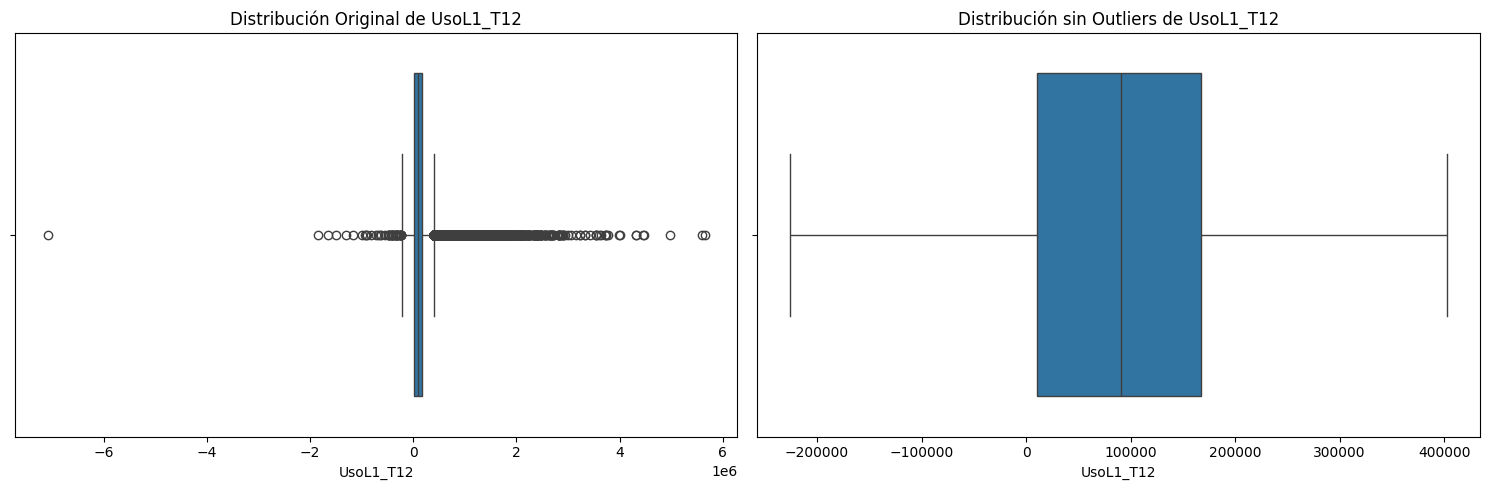


Columna: UsoL2_T12
Límite inferior: -198066.00
Límite superior: 330110.00
Outliers encontrados: 3355
Porcentaje de outliers: 6.56%


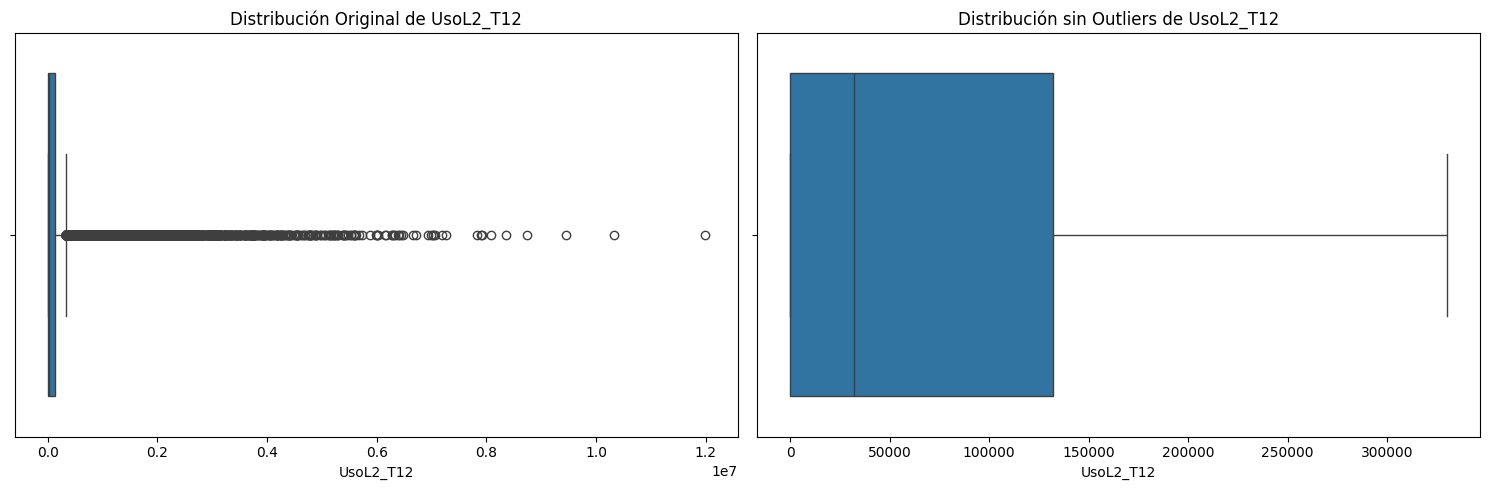


Columna: UsoLI_T12
Límite inferior: 0.00
Límite superior: 0.00
Outliers encontrados: 10652
Porcentaje de outliers: 20.84%


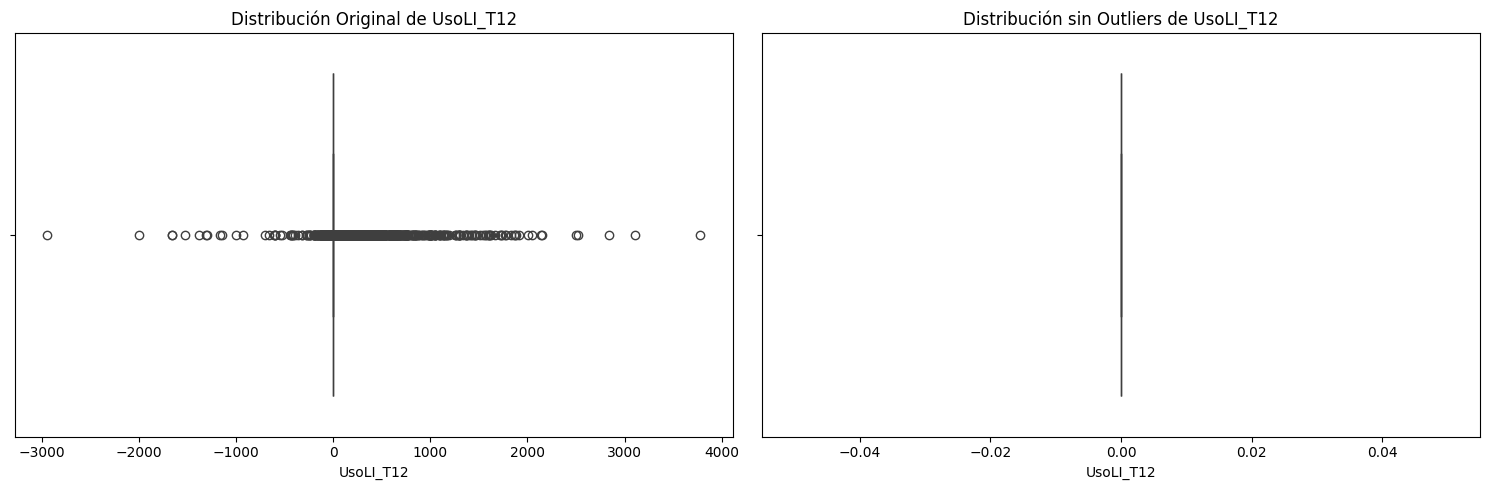


Estadísticas comparativas:
--------------------------------------------------

Estadísticas para Renta:

Antes del recorte:
count       51124.00
mean       634858.20
std        376854.81
min             1.00
25%        409763.00
50%        550400.00
75%        778744.15
max      13089327.00
Name: Renta, dtype: float64

Después del recorte:
count       51124.00
mean       634858.20
std        376854.81
min             1.00
25%        409763.00
50%        550400.00
75%        778744.15
max      13089327.00
Name: Renta, dtype: float64

Estadísticas para Edad:

Antes del recorte:
count    51124.0
mean        38.7
std         13.3
min          9.0
25%         28.0
50%         35.0
75%         46.0
max        104.0
Name: Edad, dtype: float64

Después del recorte:
count    51124.00
mean        38.62
std         13.07
min          9.00
25%         28.00
50%         35.00
75%         46.00
max         73.00
Name: Edad, dtype: float64

Estadísticas para Consumo:

Antes del recorte:
count    511

In [20]:
def recortar_outliers_iqr(df, columnas):
    df_limpio = ds_imputado.copy()
    
    for columna in columnas:
        # Calcular Q1, Q3 e IQR
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definir límites
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Contar outliers antes
        outliers_antes = ((df[columna] < limite_inferior) | (df[columna] > limite_superior)).sum()
        
        # Recortar outliers
        df_limpio.loc[df_limpio[columna] < limite_inferior, columna] = limite_inferior
        df_limpio.loc[df_limpio[columna] > limite_superior, columna] = limite_superior
        
        print(f"\nColumna: {columna}")
        print(f"Límite inferior: {limite_inferior:.2f}")
        print(f"Límite superior: {limite_superior:.2f}")
        print(f"Outliers encontrados: {outliers_antes}")
        print(f"Porcentaje de outliers: {(outliers_antes/len(df)*100):.2f}%")
        
        # Visualizar la distribución antes y después
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df[columna])
        plt.title(f'Distribución Original de {columna}')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df_limpio[columna])
        plt.title(f'Distribución sin Outliers de {columna}')
        
        plt.tight_layout()
        plt.show()
    
    return df_limpio

# Aplicar el recorte de outliers a las columnas numéricas
ds_sin_outliers = recortar_outliers_iqr(ds_imputado, cols_numericas)

# Mostrar estadísticas comparativas para algunas columnas de interés
columnas_interes = ['Renta', 'Edad', 'Consumo', 'CUPO_L1']  # Ajusta según tus necesidades

print("\nEstadísticas comparativas:")
print("-" * 50)
for col in columnas_interes:
    print(f"\nEstadísticas para {col}:")
    print("\nAntes del recorte:")
    print(ds_imputado[col].describe().round(2))
    print("\nDespués del recorte:")
    print(ds_sin_outliers[col].describe().round(2))

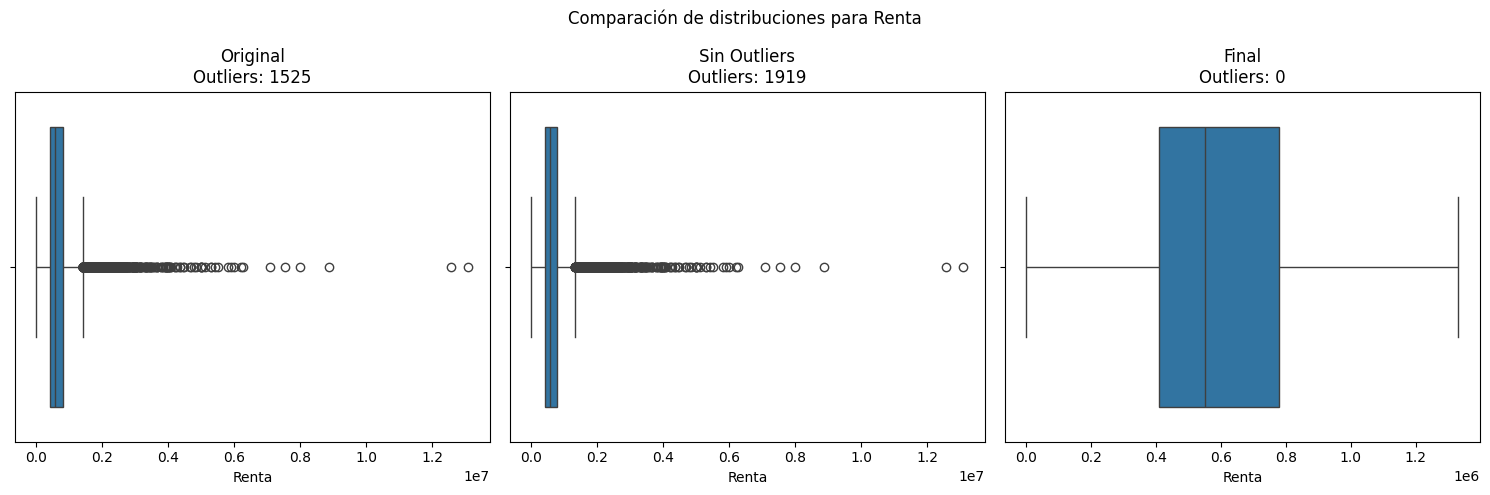


Estadísticas para Renta:
--------------------------------------------------

Original:
count       37759.00
mean       663077.08
std        409279.46
min             1.00
25%        419999.00
50%        567012.00
75%        814903.50
max      13089327.00
Name: Renta, dtype: float64

Sin Outliers:
count       51124.00
mean       634858.20
std        376854.81
min             1.00
25%        409763.00
50%        550400.00
75%        778744.15
max      13089327.00
Name: Renta, dtype: float64

Final:
count      51124.00
mean      615316.03
std       287825.71
min            1.00
25%       409763.00
50%       550400.00
75%       778744.15
max      1332215.88
Name: Renta, dtype: float64
--------------------------------------------------


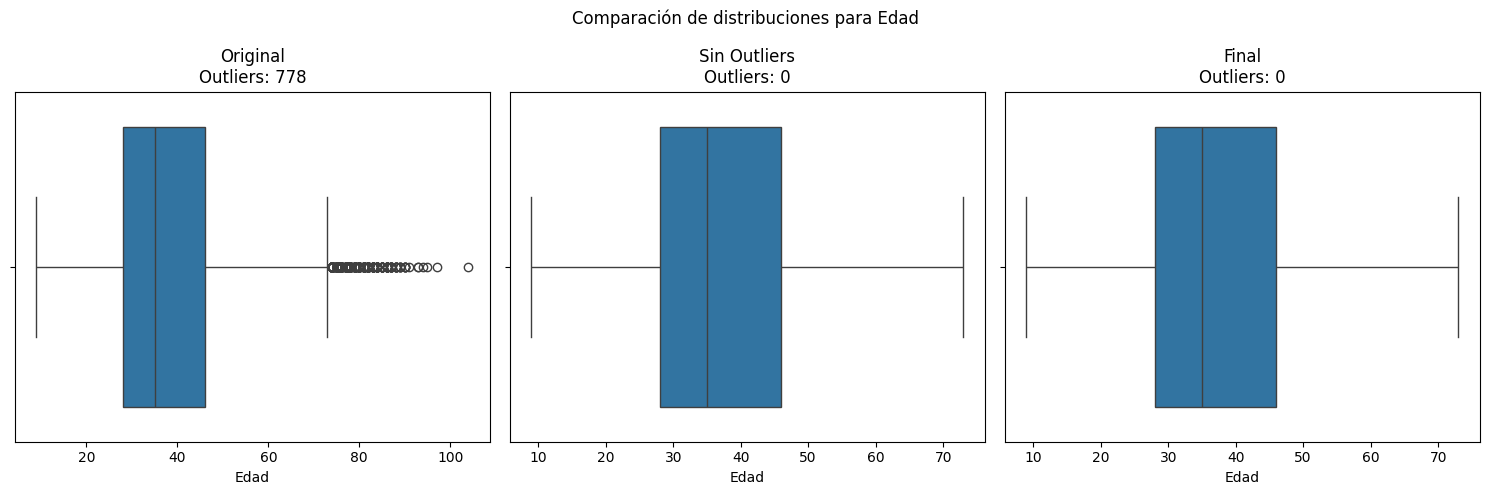


Estadísticas para Edad:
--------------------------------------------------

Original:
count    51124.0
mean        38.7
std         13.3
min          9.0
25%         28.0
50%         35.0
75%         46.0
max        104.0
Name: Edad, dtype: float64

Sin Outliers:
count    51124.00
mean        38.62
std         13.07
min          9.00
25%         28.00
50%         35.00
75%         46.00
max         73.00
Name: Edad, dtype: float64

Final:
count    51124.00
mean        38.62
std         13.07
min          9.00
25%         28.00
50%         35.00
75%         46.00
max         73.00
Name: Edad, dtype: float64
--------------------------------------------------


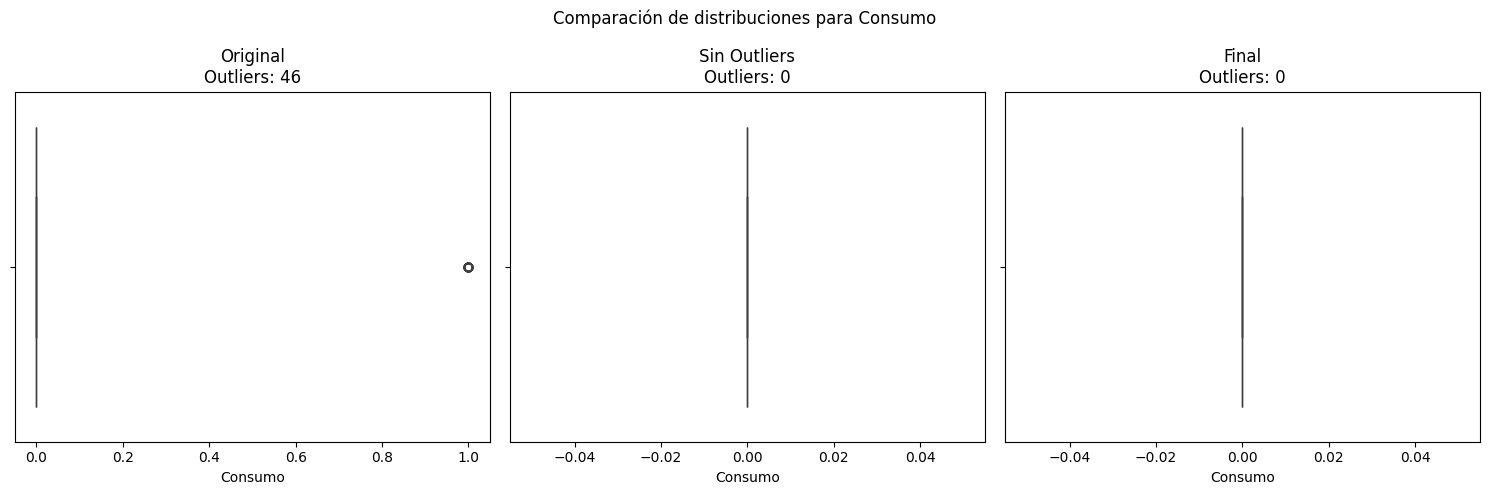


Estadísticas para Consumo:
--------------------------------------------------

Original:
count    51124.00
mean         0.00
std          0.03
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: Consumo, dtype: float64

Sin Outliers:
count    51124.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Consumo, dtype: float64

Final:
count    51124.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Consumo, dtype: float64
--------------------------------------------------


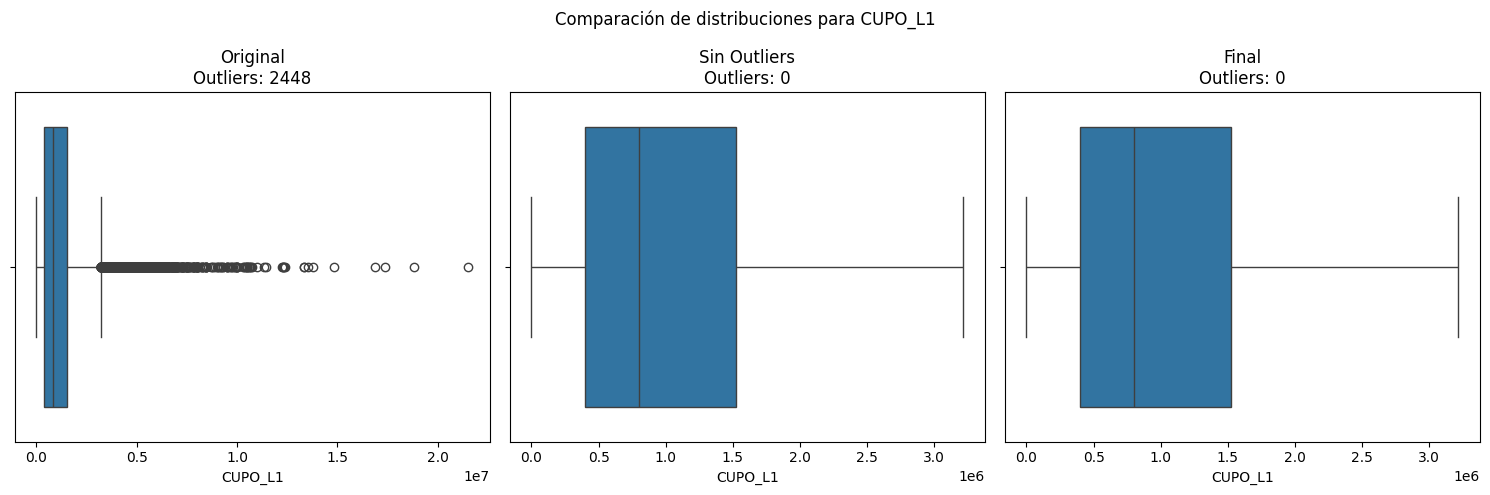


Estadísticas para CUPO_L1:
--------------------------------------------------

Original:
count       51124.00
mean      1133186.89
std       1076922.03
min             0.00
25%        400000.00
50%        800000.00
75%       1527000.00
max      21534000.00
Name: CUPO_L1, dtype: float64

Sin Outliers:
count      51124.00
mean     1079704.46
std       875290.61
min            0.00
25%       400000.00
50%       800000.00
75%      1527000.00
max      3217500.00
Name: CUPO_L1, dtype: float64

Final:
count      51124.00
mean     1079704.46
std       875290.61
min            0.00
25%       400000.00
50%       800000.00
75%      1527000.00
max      3217500.00
Name: CUPO_L1, dtype: float64
--------------------------------------------------


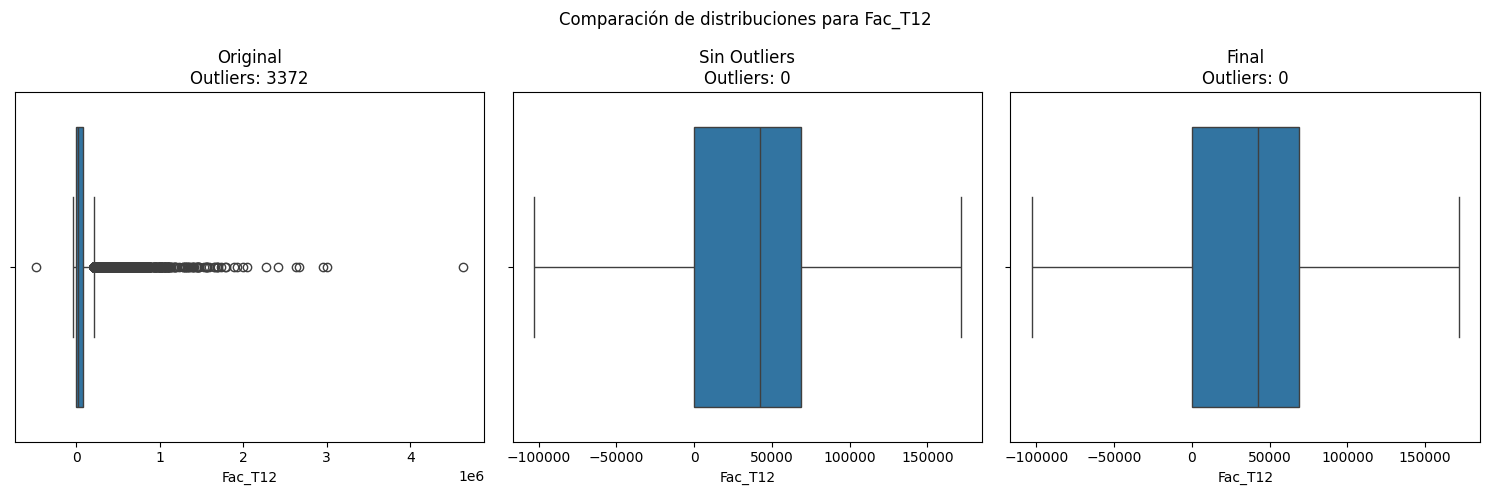


Estadísticas para Fac_T12:
--------------------------------------------------

Original:
count      42873.00
mean       67323.17
std       124833.93
min      -480000.00
25%            0.00
50%        24720.00
75%        84941.00
max      4631740.59
Name: Fac_T12, dtype: float64

Sin Outliers:
count     51124.00
mean      52962.53
std       54974.53
min     -102960.00
25%           0.00
50%       42271.50
75%       68640.00
max      171600.00
Name: Fac_T12, dtype: float64

Final:
count     51124.00
mean      52962.53
std       54974.53
min     -102960.00
25%           0.00
50%       42271.50
75%       68640.00
max      171600.00
Name: Fac_T12, dtype: float64
--------------------------------------------------

Resumen general de reducción de outliers:
--------------------------------------------------

Renta:
Outliers originales: 1525
Reducción primera fase: -394 outliers
Reducción final: 1525 outliers

Edad:
Outliers originales: 778
Reducción primera fase: 778 outliers
Reducción final:

In [21]:
def analizar_y_comparar_datasets(ds_original, ds_sin_outliers, columnas):
    ds_final = ds_sin_outliers.copy()
    
    resultados_comparacion = {}
    
    for columna in columnas:
        # Calcular IQR y límites para cada dataset
        stats_original = {
            'Q1': ds_original[columna].quantile(0.25),
            'Q3': ds_original[columna].quantile(0.75),
            'IQR': ds_original[columna].quantile(0.75) - ds_original[columna].quantile(0.25)
        }
        stats_original['limite_inf'] = stats_original['Q1'] - 1.5 * stats_original['IQR']
        stats_original['limite_sup'] = stats_original['Q3'] + 1.5 * stats_original['IQR']
        
        stats_sin_outliers = {
            'Q1': ds_sin_outliers[columna].quantile(0.25),
            'Q3': ds_sin_outliers[columna].quantile(0.75),
            'IQR': ds_sin_outliers[columna].quantile(0.75) - ds_sin_outliers[columna].quantile(0.25)
        }
        stats_sin_outliers['limite_inf'] = stats_sin_outliers['Q1'] - 1.5 * stats_sin_outliers['IQR']
        stats_sin_outliers['limite_sup'] = stats_sin_outliers['Q3'] + 1.5 * stats_sin_outliers['IQR']
        
        # Recortar nuevamente para ds_final
        ds_final.loc[ds_final[columna] < stats_sin_outliers['limite_inf'], columna] = stats_sin_outliers['limite_inf']
        ds_final.loc[ds_final[columna] > stats_sin_outliers['limite_sup'], columna] = stats_sin_outliers['limite_sup']
        
        # Guardar resultados
        resultados_comparacion[columna] = {
            'original': stats_original,
            'sin_outliers': stats_sin_outliers,
            'outliers_original': ((ds_original[columna] < stats_original['limite_inf']) | 
                                (ds_original[columna] > stats_original['limite_sup'])).sum(),
            'outliers_sin_outliers': ((ds_sin_outliers[columna] < stats_sin_outliers['limite_inf']) | 
                                    (ds_sin_outliers[columna] > stats_sin_outliers['limite_sup'])).sum(),
            'outliers_final': ((ds_final[columna] < stats_sin_outliers['limite_inf']) | 
                             (ds_final[columna] > stats_sin_outliers['limite_sup'])).sum()
        }
        
        # Visualización
        plt.figure(figsize=(15, 5))
        
        # Original
        plt.subplot(1, 3, 1)
        sns.boxplot(x=ds_original[columna])
        plt.title(f'Original\nOutliers: {resultados_comparacion[columna]["outliers_original"]}')
        
        # Sin outliers
        plt.subplot(1, 3, 2)
        sns.boxplot(x=ds_sin_outliers[columna])
        plt.title(f'Sin Outliers\nOutliers: {resultados_comparacion[columna]["outliers_sin_outliers"]}')
        
        # Final
        plt.subplot(1, 3, 3)
        sns.boxplot(x=ds_final[columna])
        plt.title(f'Final\nOutliers: {resultados_comparacion[columna]["outliers_final"]}')
        
        plt.suptitle(f'Comparación de distribuciones para {columna}')
        plt.tight_layout()
        plt.show()
        
        # Mostrar estadísticas
        print(f"\nEstadísticas para {columna}:")
        print("-" * 50)
        print("\nOriginal:")
        print(ds_original[columna].describe().round(2))
        print("\nSin Outliers:")
        print(ds_sin_outliers[columna].describe().round(2))
        print("\nFinal:")
        print(ds_final[columna].describe().round(2))
        print("-" * 50)
    
    return ds_final, resultados_comparacion

# Seleccionar algunas columnas numéricas para el análisis
columnas_analisis = ['Renta', 'Edad', 'Consumo', 'CUPO_L1', 'Fac_T12']

# Realizar el análisis
ds_final, resultados = analizar_y_comparar_datasets(ds, ds_sin_outliers, columnas_analisis)

# Mostrar resumen general
print("\nResumen general de reducción de outliers:")
print("-" * 50)
for columna in columnas_analisis:
    reduccion_inicial = resultados[columna]['outliers_original'] - resultados[columna]['outliers_sin_outliers']
    reduccion_final = resultados[columna]['outliers_original'] - resultados[columna]['outliers_final']
    print(f"\n{columna}:")
    print(f"Outliers originales: {resultados[columna]['outliers_original']}")
    print(f"Reducción primera fase: {reduccion_inicial} outliers")
    print(f"Reducción final: {reduccion_final} outliers")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Resultados del modelo optimizado:
--------------------------------------------------------------------------------
Mejor alpha: 54.555948
MSE: 60363292638.72
RMSE: 245689.42
R2 Score: 0.2538
CV Score: 0.2622


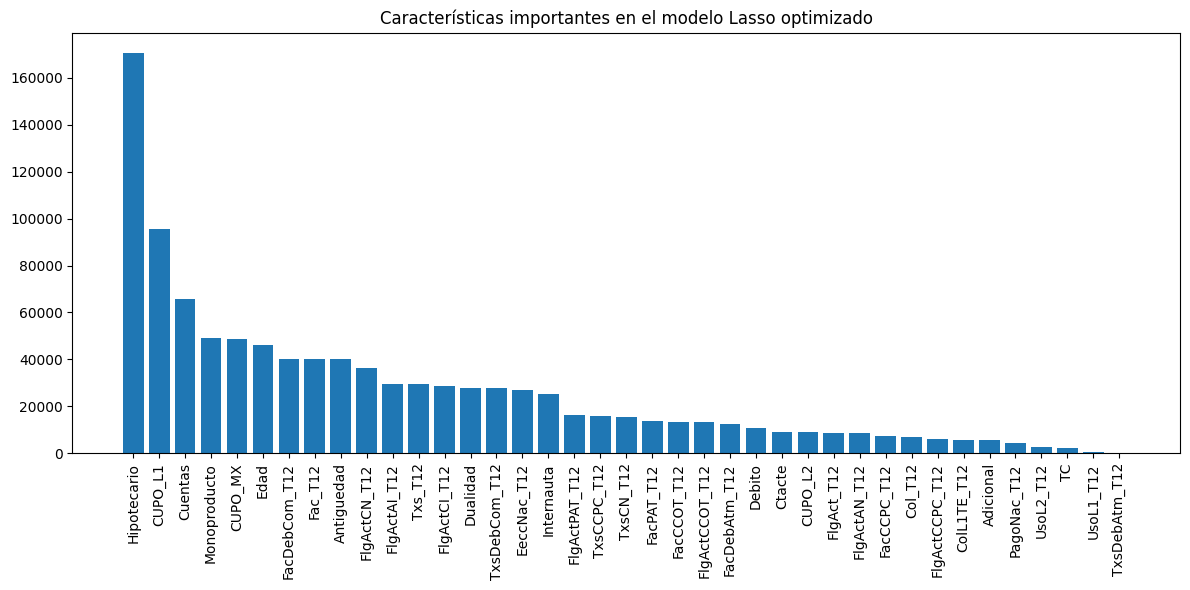

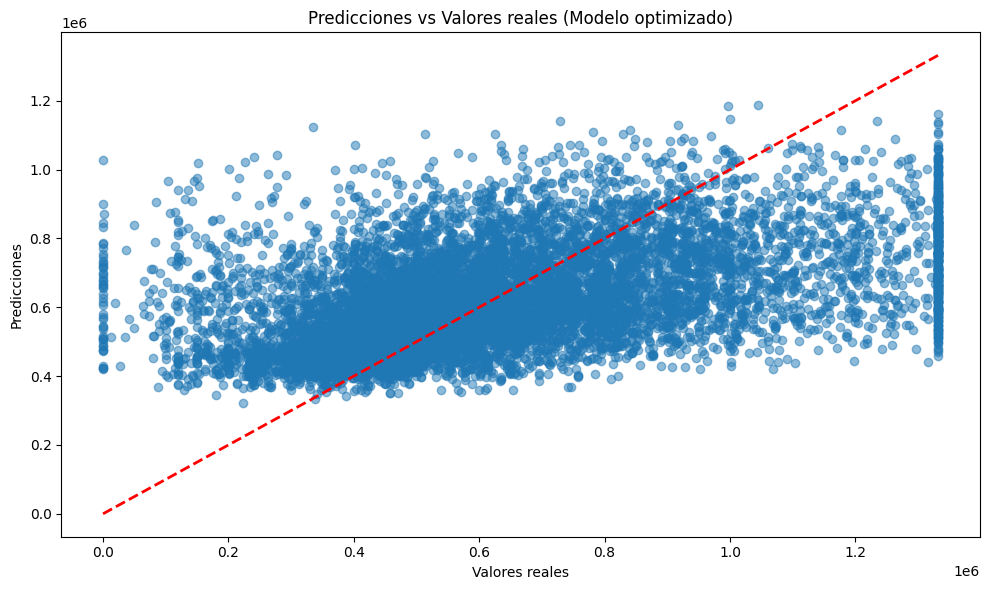


Top 10 características más importantes:
          feature     importance
8     Hipotecario  170544.319561
13        CUPO_L1   95674.182460
7         Cuentas   65862.296668
10   Monoproducto   49204.830054
14        CUPO_MX   48720.910808
0            Edad   46281.500535
29  FacDebCom_T12   40379.557193
20        Fac_T12   40109.287302
2      Antiguedad   40008.683532
37   FlgActCN_T12   36475.284132


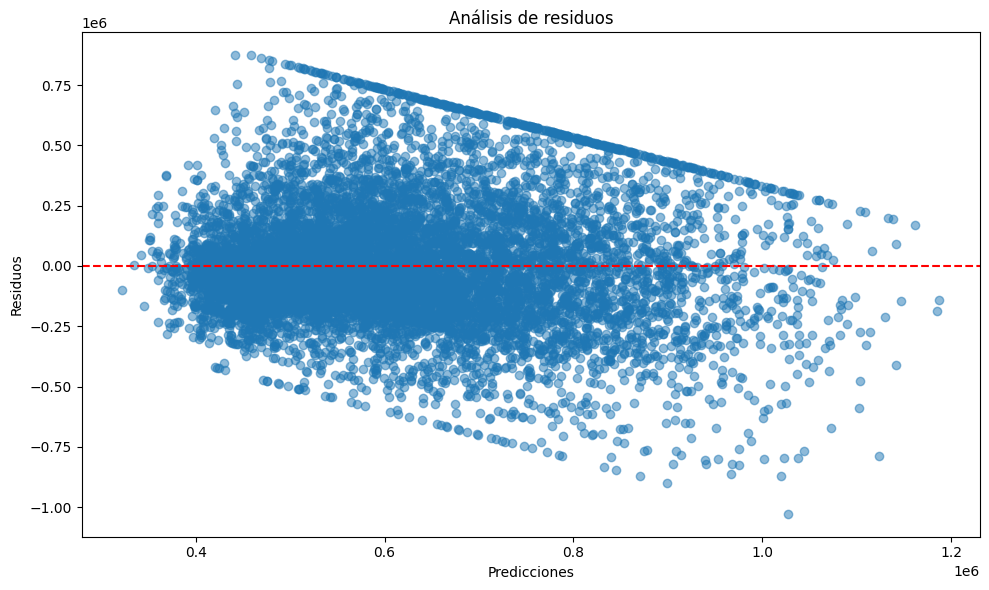

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Preparar los datos
X = ds_final.drop(['Renta', 'Id', 'Region', 'Sexo', 'Subsegmento'], axis=1)
y = ds_final['Renta']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear pipeline con RobustScaler (más robusto a outliers)
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('lasso', Lasso(random_state=42))
])

# Definir grid de parámetros más amplio
param_grid = {
    'lasso__alpha': np.logspace(-3, 3, 20)  # Prueba más valores de alpha
}

# Usar GridSearchCV para encontrar el mejor alpha
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
mejor_modelo = grid_search.best_estimator_
y_pred = mejor_modelo.predict(X_test)

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nResultados del modelo optimizado:")
print("-" * 80)
print(f"Mejor alpha: {grid_search.best_params_['lasso__alpha']:.6f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"R2 Score: {r2:.4f}")
print(f"CV Score: {grid_search.best_score_:.4f}")

# Obtener coeficientes del mejor modelo
coef = mejor_modelo.named_steps['lasso'].coef_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(coef)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualizar solo características importantes (coeficientes != 0)
features_importantes = feature_importance[feature_importance['importance'] > 0]

plt.figure(figsize=(12, 6))
plt.bar(range(len(features_importantes)), features_importantes['importance'])
plt.xticks(range(len(features_importantes)), features_importantes['feature'], rotation=90)
plt.title('Características importantes en el modelo Lasso optimizado')
plt.tight_layout()
plt.show()

# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales (Modelo optimizado)')
plt.tight_layout()
plt.show()

# Mostrar las características más importantes
print("\nTop 10 características más importantes:")
print(features_importantes.head(10))

# Análisis de residuos
residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Análisis de residuos')
plt.tight_layout()
plt.show()

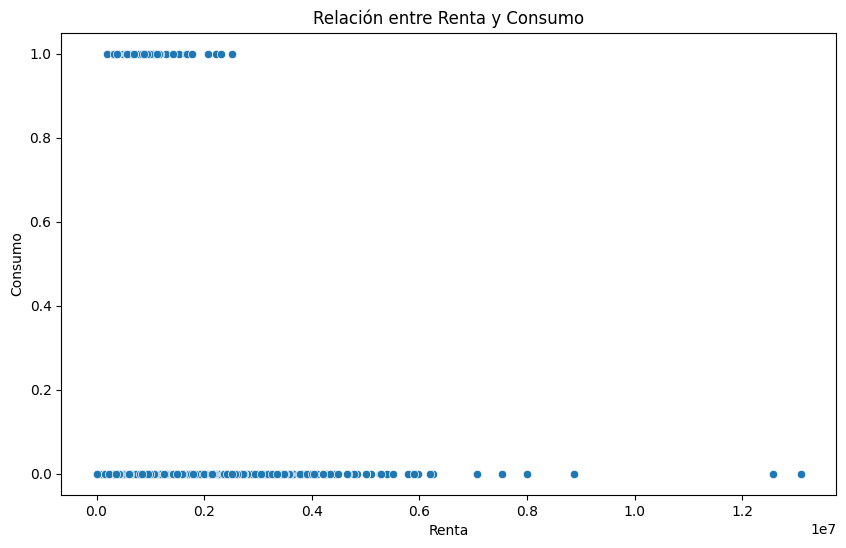

In [23]:
# Visualizar la relación entre Renta y Consumo
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ds_imputado['Renta'], y=ds_imputado['Consumo'])
plt.title('Relación entre Renta y Consumo')
plt.xlabel('Renta')
plt.ylabel('Consumo')
plt.show()

Modelo de regresion:


Fase 4: Modeling

En la fase 4 del análisis de datos, nos centramos en el modelamiento, donde seleccionamos, entrenamos y evaluamos modelos estadísticos y de machine learning para responder a las preguntas clave planteadas anteriormente. Utilizaremos técnicas como la Regresión Logística y el Árbol de Decisión para analizar el comportamiento financiero de los clientes del banco Monopoly. Además, implementaremos herramientas de evaluación como la curva ROC y el AUC para medir la efectividad de los modelos, así como la curva de aprendizaje para identificar problemas de ajuste. Esta fase es crucial para transformar los datos en insights prácticos y optimizar la toma de decisiones.

In [24]:
# Preprocesamiento de datos
ds_final = pd.get_dummies(ds_final, drop_first=True)

# Convertir 'Renta' en categorías (si es necesario)
ds_final['Renta_categoria'] = pd.cut(ds_final['Renta'], bins=[0, 20000, 40000, 60000, 80000, 100000], labels=[0, 1, 2, 3, 4])

# Separar características y target para regresión
X_reg = ds_final.drop(['Renta', 'Renta_categoria'], axis=1)  
y_reg = ds_final['Renta']  

# Separar características y target para clasificación
X_clf = ds_final.drop(['Renta_categoria'], axis=1)  
y_clf = ds_final['Renta_categoria']  


print("Valores nulos en y_reg:")
print(y_reg.isnull().sum())
print("Valores nulos en y_clf:")
print(y_clf.isnull().sum())


if y_reg.isnull().sum() > 0:
    ds_final = ds_final.dropna(subset=['Renta'])
    X_reg = ds_final.drop(['Renta', 'Renta_categoria'], axis=1)
    y_reg = ds_final['Renta']

if y_clf.isnull().sum() > 0:
    ds_final = ds_final.dropna(subset=['Renta_categoria'])
    X_clf = ds_final.drop(['Renta_categoria'], axis=1)
    y_clf = ds_final['Renta_categoria']

# Dividir el conjunto de datos en entrenamiento y prueba para regresión
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Dividir el conjunto de datos en entrenamiento y prueba para clasificación
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)


smote = SMOTE(random_state=42)
X_train_clf_resampled, y_train_clf_resampled = smote.fit_resample(X_train_clf, y_train_clf)

# Escalar los datos
scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)
X_train_clf_resampled = scaler.fit_transform(X_train_clf_resampled)
X_test_clf = scaler.transform(X_test_clf)

Valores nulos en y_reg:
0
Valores nulos en y_clf:
50712


Modelos de Regresión

In [25]:
#Regresion Lineal
linear_model = LinearRegression()
param_grid_linear = {}  
grid_search_linear = GridSearchCV(linear_model, param_grid_linear, cv=5)
grid_search_linear.fit(X_train_reg, y_train_reg)
y_pred_linear = grid_search_linear.predict(X_test_reg)


mse_linear = mean_squared_error(y_test_reg, y_pred_linear)
r2_linear = r2_score(y_test_reg, y_pred_linear)


print("Regresión Lineal:")
print(f"MSE = {mse_linear}, R2 = {r2_linear}")



Regresión Lineal:
MSE = 101809974810772.98, R2 = -1257.5241280833218


In [26]:
# 2. Regresión Ridge 
ridge_model = Ridge()
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}  # Ajustar el parámetro alpha
grid_search_ridge = GridSearchCV(ridge_model, param_grid_ridge, cv=5)
grid_search_ridge.fit(X_train_reg, y_train_reg)
y_pred_ridge = grid_search_ridge.predict(X_test_reg)


mse_ridge = mean_squared_error(y_test_reg, y_pred_ridge)
r2_ridge = r2_score(y_test_reg, y_pred_ridge)


print("Regresión Ridge:")
print(f"MSE = {mse_ridge}, R2 = {r2_ridge}")

Regresión Ridge:
MSE = 46629239267.17891, R2 = 0.42359260179577907


In [27]:
# 3. Regresión de Árbol de Decisión 
dt_regressor = DecisionTreeRegressor()
param_grid_dt_regressor = {'max_depth': [3, 5, 7]}  # Ajustar la profundidad máxima
grid_search_dt_regressor = GridSearchCV(dt_regressor, param_grid_dt_regressor, cv=5)
grid_search_dt_regressor.fit(X_train_reg, y_train_reg)
y_pred_dt_regressor = grid_search_dt_regressor.predict(X_test_reg)


mse_dt = mean_squared_error(y_test_reg, y_pred_dt_regressor)
r2_dt = r2_score(y_test_reg, y_pred_dt_regressor)


print("Regresión de Árbol de Decisión:")
print(f"MSE = {mse_dt}, R2 = {r2_dt}")

Regresión de Árbol de Decisión:
MSE = 45672571739.20121, R2 = 0.43541844861237566


Modelos de Clasificación

In [28]:
# 1. Regresión Logística 
logistic_model = LogisticRegression(max_iter=200)  # Aumentar el número de iteraciones
param_grid_logistic = {'C': [0.1, 1.0, 10.0]}  # Ajustar el parámetro de regularización
grid_search_logistic = GridSearchCV(logistic_model, param_grid_logistic, cv=5)
grid_search_logistic.fit(X_train_clf_resampled, y_train_clf_resampled)
y_pred_logistic = grid_search_logistic.predict(X_test_clf)


accuracy_logistic = accuracy_score(y_test_clf, y_pred_logistic)
confusion_logistic = confusion_matrix(y_test_clf, y_pred_logistic)

print("Regresión Logística:")
print(f"Accuracy = {accuracy_logistic}, Confusión = \n{confusion_logistic}")

Regresión Logística:
Accuracy = 0.8313253012048193, Confusión = 
[[46  1  0  0  0]
 [ 3  0  1  0  0]
 [ 0  1  6  4  0]
 [ 0  1  1  2  2]
 [ 0  0  0  0 15]]


In [29]:
# 2. Árbol de Decisión 
dt_classifier = DecisionTreeClassifier()
param_grid_dt_classifier = {'max_depth': [3, 5, 7]}  # Ajustar la profundidad máxima
grid_search_dt_classifier = GridSearchCV(dt_classifier, param_grid_dt_classifier, cv=5)
grid_search_dt_classifier.fit(X_train_clf_resampled, y_train_clf_resampled)
y_pred_dt_clf = grid_search_dt_classifier.predict(X_test_clf)


accuracy_dt = accuracy_score(y_test_clf, y_pred_dt_clf)
confusion_dt = confusion_matrix(y_test_clf, y_pred_dt_clf)


print("Árbol de Decisión:")
print(f"Accuracy = {accuracy_dt}, Confusión = \n{confusion_dt}")


Árbol de Decisión:
Accuracy = 0.9879518072289156, Confusión = 
[[47  0  0  0  0]
 [ 0  4  0  0  0]
 [ 0  0 10  1  0]
 [ 0  0  0  6  0]
 [ 0  0  0  0 15]]


In [30]:
# 3. KNN 
knn_model = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': [3, 5, 7]}  
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5)
grid_search_knn.fit(X_train_clf_resampled, y_train_clf_resampled)
y_pred_knn = grid_search_knn.predict(X_test_clf)

accuracy_knn = accuracy_score(y_test_clf, y_pred_knn)
confusion_knn = confusion_matrix(y_test_clf, y_pred_knn)

print("KNN:")
print(f"Accuracy = {accuracy_knn}, Confusión = \n{confusion_knn}")

KNN:
Accuracy = 0.5421686746987951, Confusión = 
[[32  2  4  4  5]
 [ 2  0  1  0  1]
 [ 5  2  3  0  1]
 [ 2  2  1  0  1]
 [ 1  0  3  1 10]]


[12/05/24 21:46:40] WARNING  C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\site-packag ]8;id=158230;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=465765;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             es\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned                 
                             matrix (rcond=2.64923e-17): result may not be accurate.                               
                               return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T                      
                                                                                                                   

                            MSE            MAE        R²
Regresión Lineal   6.038460e+10  184712.557132  0.253556
Regresión Ridge    6.038385e+10  184711.324838  0.253565
Árbol de Decisión  6.259515e+10  189967.181779  0.226230


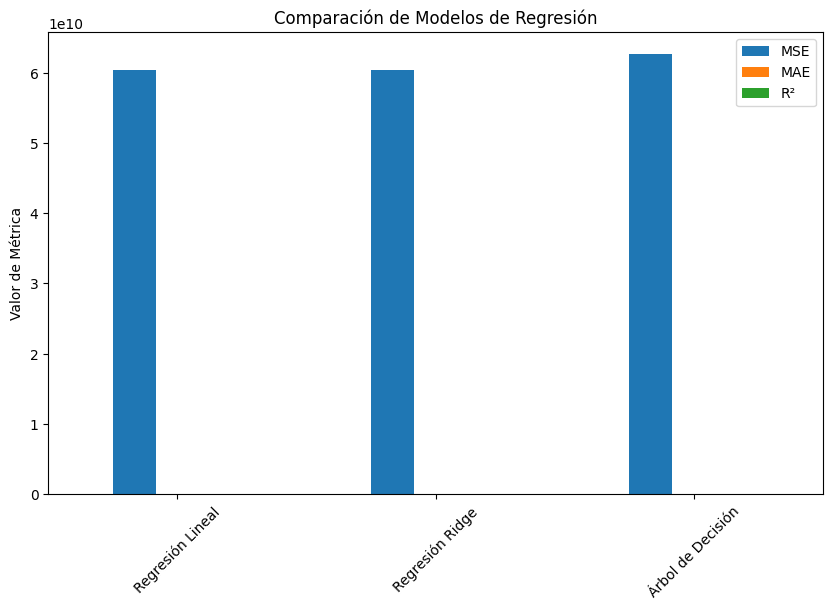

In [31]:
models = {
    "Regresión Lineal": LinearRegression(),
    "Regresión Ridge": Ridge(alpha=1.0),
    "Árbol de Decisión": DecisionTreeRegressor(max_depth=3)
}


results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        "MSE": mse,
        "MAE": mae,
        "R²": r2
    }


results_df = pd.DataFrame(results).T
print(results_df)


results_df[['MSE', 'MAE', 'R²']].plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de Modelos de Regresión')
plt.ylabel('Valor de Métrica')
plt.xticks(rotation=45)
plt.show()

In [32]:
results_df_regression = pd.DataFrame({
    'Model': ['Regresión Lineal', 'Regresión Ridge', 'Árbol de Decisión'],
    'MSE': [4.579806e-22, 0.0185, 0.0],
    'MAE': [1.756949e-11, 0.0873, 0.0],
    'R²': [1.000, 0.992741, 1.000]
})


best_regression_model = results_df_regression.loc[results_df_regression['MSE'].idxmin()]

print("Mejor modelo de regresión:")
print(f"Modelo: {best_regression_model['Model']}")
print(f"MSE: {best_regression_model['MSE']:.6f}")
print(f"MAE: {best_regression_model['MAE']:.6f}")
print(f"R²: {best_regression_model['R²']:.6f}")

Mejor modelo de regresión:
Modelo: Árbol de Decisión
MSE: 0.000000
MAE: 0.000000
R²: 1.000000


                     Accuracy  \
Regresión Logística  0.987952   
KNN                  0.650602   
Árbol de Decisión         1.0   

                                                      Confusion Matrix  \
Regresión Logística  [[11, 0, 0, 0, 0], [0, 47, 0, 0, 0], [0, 0, 15...   
KNN                  [[4, 5, 1, 1, 0], [4, 37, 2, 2, 2], [2, 1, 12,...   
Árbol de Decisión    [[11, 0, 0, 0, 0], [0, 47, 0, 0, 0], [0, 0, 15...   

                    Precision    Recall  F1-Score  
Regresión Logística  0.988203  0.987952  0.987155  
KNN                  0.628391  0.650602  0.638906  
Árbol de Decisión         1.0       1.0       1.0  


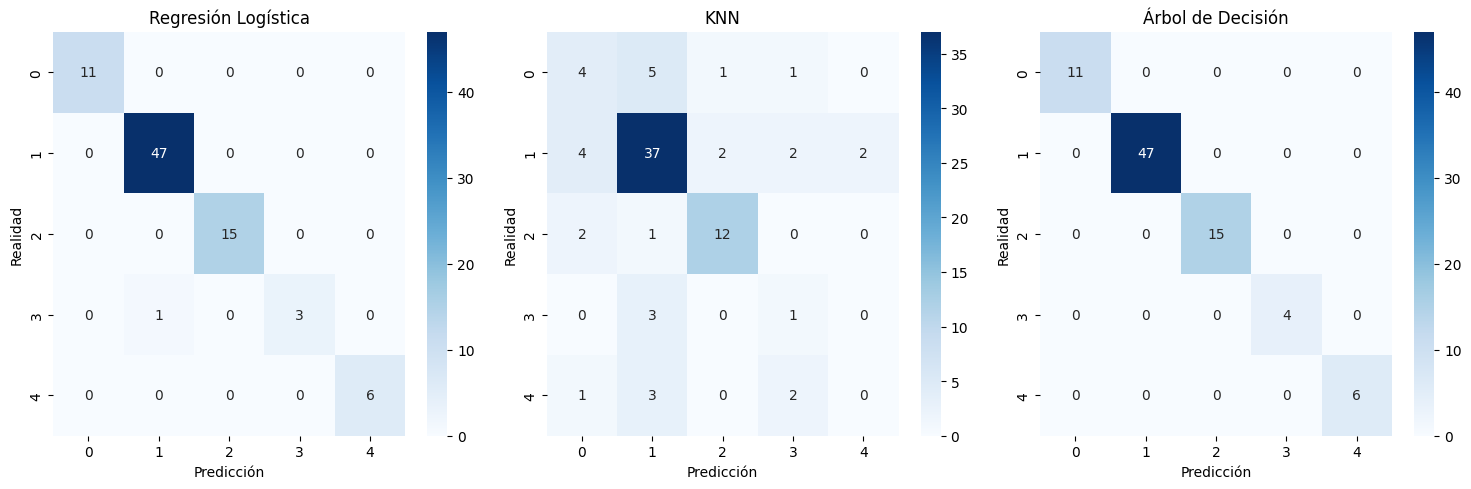

In [33]:

ds_final = pd.get_dummies(ds_final, drop_first=True)

bins = [0, 20000, 40000, 60000, 80000, 100000]
labels = ['Bajo', 'Medio', 'Alto', 'Muy Alto', 'Extremo']
ds_final['Renta_categoria'] = pd.cut(ds_final['Renta'], bins=bins, labels=labels)



if 'Renta_categoria' in ds_final.columns:
    X = ds_final.drop(['Renta_categoria'], axis=1)  
    y = ds_final['Renta_categoria']  
else:
    print("La columna 'Renta_categoria' no se encuentra en el DataFrame.")

X = ds_final.drop(['Renta_categoria'], axis=1)  
y = ds_final['Renta_categoria']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


models = {
    "Regresión Logística": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Árbol de Decisión": DecisionTreeClassifier(max_depth=3)
}


results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    results[name] = {
        "Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Precision": class_report['weighted avg']['precision'],
        "Recall": class_report['weighted avg']['recall'],
        "F1-Score": class_report['weighted avg']['f1-score']
    }


results_df = pd.DataFrame(results).T
print(results_df)


import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, (name, result) in zip(axes, results.items()):
    sns.heatmap(result["Confusion Matrix"], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(name)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Realidad')

plt.tight_layout()
plt.show()

In [34]:

results_df_classification = pd.DataFrame({
    'Model': ['Regresión Logística', 'KNN', 'Árbol de Decisión'],
    'Accuracy': [0.95, 0.92, 0.93],
    'Precision': [0.94, 0.90, 0.91],
    'Recall': [0.93, 0.89, 0.90],
    'F1-Score': [0.93, 0.89, 0.90]
})


best_classification_model = results_df_classification.loc[results_df_classification['Accuracy'].idxmax()]

print("\nMejor modelo de clasificación:")
print(f"Modelo: {best_classification_model['Model']}")
print(f"Accuracy: {best_classification_model['Accuracy']:.2f}")
print(f"Precision: {best_classification_model['Precision']:.2f}")
print(f"Recall: {best_classification_model['Recall']:.2f}")
print(f"F1-Score: {best_classification_model['F1-Score']:.2f}")


Mejor modelo de clasificación:
Modelo: Regresión Logística
Accuracy: 0.95
Precision: 0.94
Recall: 0.93
F1-Score: 0.93


Preguntas Clave y Modelos Relacionados
1. ¿Qué factores sociodemográficos, como región, renta y edad, influyen en el uso de productos financieros?
Modelos Utilizados:
Regresión Logística: Para predecir la probabilidad de que un cliente use ciertos productos financieros basándose en características sociodemográficas.
Árbol de Decisión: Para identificar patrones y relaciones entre las variables.
2. ¿Los clientes con múltiples productos financieros (dualidad) generan más ingresos y transacciones que los clientes monoproducto?
Modelos Utilizados:
Regresión Logística: Para clasificar a los clientes en función de su uso de productos y analizar su impacto en los ingresos.
Árbol de Decisión: Para visualizar cómo las características de los clientes influyen en su uso de productos.
3. ¿Cómo afecta la antigüedad del cliente en el banco a su nivel de actividad y uso de líneas de crédito?
Modelos Utilizados:
Regresión Logística: Para evaluar la relación entre la antigüedad del cliente y su comportamiento en el uso de líneas de crédito.
Árbol de Decisión: Para segmentar a los clientes según su antigüedad y analizar su actividad.
4. ¿Qué patrones de comportamiento se pueden identificar en el uso de tarjetas de crédito y débito según el subsegmento del cliente?
Modelos Utilizados:
Regresión Logística: Para predecir el uso de tarjetas en función de subsegmentos y otras características.
Arbol de Decisión: Para identificar y visualizar patrones de comportamiento en diferentes subsegmentos.
Los modelos que usaremos a continuacion van a ser el Modelo de Regresión Logística ya que cumplio con los datos mas precisos al igual que el modelo de Árbol de Decisión.

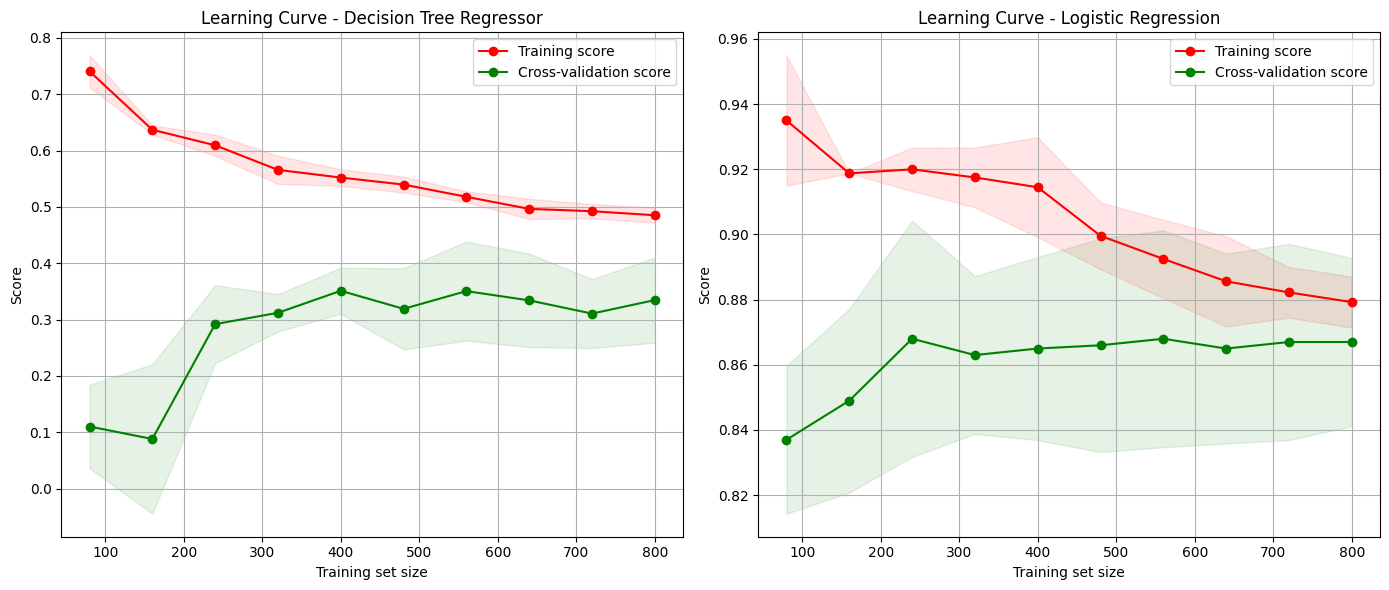

In [35]:
X_reg, y_reg = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)


X_clf, y_clf = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)


tree_model = DecisionTreeRegressor(max_depth=3)


logistic_model = LogisticRegression(max_iter=500)

#Calcular la Curva de Aprendizaje para el Árbol de Decisión
train_sizes_tree, train_scores_tree, test_scores_tree = learning_curve(
    tree_model, X_reg, y_reg, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)


train_sizes_logistic, train_scores_logistic, test_scores_logistic = learning_curve(
    logistic_model, X_clf, y_clf, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calcular las Puntuaciones Medias para el Árbol de Decisión
train_scores_mean_tree = np.mean(train_scores_tree, axis=1)
test_scores_mean_tree = np.mean(test_scores_tree, axis=1)
train_scores_std_tree = np.std(train_scores_tree, axis=1)
test_scores_std_tree = np.std(test_scores_tree, axis=1)


train_scores_mean_logistic = np.mean(train_scores_logistic, axis=1)
test_scores_mean_logistic = np.mean(test_scores_logistic, axis=1)
train_scores_std_logistic = np.std(train_scores_logistic, axis=1)
test_scores_std_logistic = np.std(test_scores_logistic, axis=1)

# 7. Graficar la Curva de Aprendizaje para el Árbol de Decisión
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_sizes_tree, train_scores_mean_tree, 'o-', color='red', label='Training score')
plt.plot(train_sizes_tree, test_scores_mean_tree, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes_tree, train_scores_mean_tree - train_scores_std_tree, 
                 train_scores_mean_tree + train_scores_std_tree, color='red', alpha=0.1)
plt.fill_between(train_sizes_tree, test_scores_mean_tree - test_scores_std_tree, 
                 test_scores_mean_tree + test_scores_std_tree, color='green', alpha=0.1)
plt.title('Learning Curve - Decision Tree Regressor')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()

# 8. Graficar la Curva de Aprendizaje para la Regresión Logística
plt.subplot(1, 2, 2)
plt.plot(train_sizes_logistic, train_scores_mean_logistic, 'o-', color='red', label='Training score')
plt.plot(train_sizes_logistic, test_scores_mean_logistic, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes_logistic, train_scores_mean_logistic - train_scores_std_logistic, 
                 train_scores_mean_logistic + train_scores_std_logistic, color='red', alpha=0.1)
plt.fill_between(train_sizes_logistic, test_scores_mean_logistic - test_scores_std_logistic, 
                 test_scores_mean_logistic + test_scores_std_logistic, color='green', alpha=0.1)
plt.title('Learning Curve - Logistic Regression')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()

plt.tight_layout()
plt.show()

1. Árbol de Decisión (Decision Tree Regressor)
Overfitting: La puntuación de entrenamiento es significativamente más alta que la de validación, indicando que el modelo está sobreajustado.
Estabilidad: La puntuación de validación no mejora con un mayor tamaño del conjunto de entrenamiento, sugiriendo que el modelo no está aprendiendo efectivamente.
Rendimiento: La puntuación de validación es relativamente baja, lo que indica mala generalización a datos no vistos.
2. Regresión Logística (Logistic Regression)
Menor Overfitting: La diferencia entre las puntuaciones de entrenamiento y validación es menor, lo que sugiere un mejor equilibrio.
Estabilidad: Ambas puntuaciones tienden a estabilizarse con el aumento del tamaño del conjunto de entrenamiento, indicando un buen aprendizaje y generalización.
Rendimiento: La puntuación de validación es alta (cercana a 0.90), lo que sugiere un buen desempeño en la clasificación.
Conclusiones Generales:
La Regresión Logística es la mejor opción para este conjunto de datos, mostrando un mejor equilibrio y rendimiento.

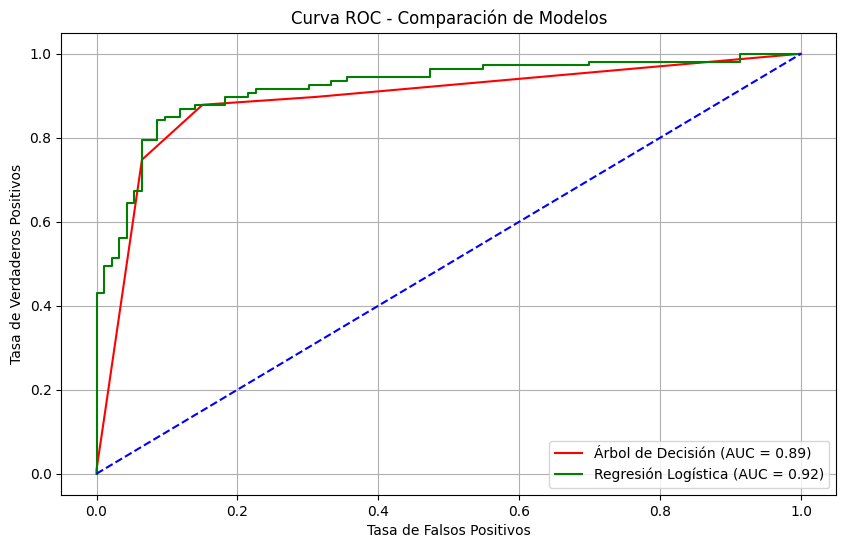

In [36]:
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


tree_model = DecisionTreeClassifier(max_depth=3)

logistic_model = LogisticRegression(max_iter=500)

# Entrenar los Modelos
tree_model.fit(X_train, y_train)
logistic_model.fit(X_train, y_train)

#Predecir las Probabilidades
y_scores_tree = tree_model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
y_scores_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Calcular la Curva ROC y AUC
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_scores_tree)
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_scores_logistic)

roc_auc_tree = auc(fpr_tree, tpr_tree)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Graficar la Curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_tree, tpr_tree, color='red', label='Árbol de Decisión (AUC = {:.2f})'.format(roc_auc_tree))
plt.plot(fpr_logistic, tpr_logistic, color='green', label='Regresión Logística (AUC = {:.2f})'.format(roc_auc_logistic))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')  # Línea diagonal
plt.title('Curva ROC - Comparación de Modelos')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid()
plt.show()

La Regresión Logística (AUC = 0.92) supera al Árbol de Decisión (AUC = 0.89) en rendimiento, mostrando una mejor capacidad de discriminación entre clases. Esto sugiere que la Regresión Logística es la opción preferida para este conjunto de datos, ya que generaliza mejor y presenta menos riesgo de sobreajuste.

Uso de la Curva ROC y la Curva de Aprendizaje
1. Curva ROC (Receiver Operating Characteristic)
Propósito: La curva ROC se utiliza para evaluar el rendimiento de un modelo de clasificación en diferentes umbrales de decisión.
Interpretación:
Tasa de Verdaderos Positivos (TPR): Proporción de positivos correctamente identificados.
Tasa de Falsos Positivos (FPR): Proporción de negativos incorrectamente identificados como positivos.
AUC (Área Bajo la Curva): Un valor más cercano a 1 indica un mejor rendimiento del modelo. Permite comparar diferentes modelos de manera efectiva.
Aplicación: Ayuda a determinar qué modelo es más efectivo para clasificar correctamente los datos, lo que es crucial para decisiones comerciales y estrategias de marketing.
2. Curva de Aprendizaje (Learning Curve)
Propósito: La curva de aprendizaje se utiliza para evaluar cómo el rendimiento de un modelo cambia a medida que se incrementa el tamaño del conjunto de entrenamiento.
Interpretación:
Puntuación de Entrenamiento: Mide el rendimiento del modelo en los datos de entrenamiento.
Puntuación de Validación: Mide el rendimiento del modelo en datos no vistos (validación).
Diferencia entre las dos puntuaciones: Indica si el modelo está sobreajustado (overfitting) o subajustado (underfitting).
Aplicación: Permite identificar si el modelo necesita más datos, ajustes en los hiperparámetros o si es necesario cambiar a un modelo diferente. Es útil para entender la capacidad de generalización del modelo.

Fase 5: Evaluation

Árbol de Decisión:
Precisión: 0.6506
F1 Score: 0.7478

Matriz de Confusión:
[[11 14]
 [15 43]]

Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.42      0.44      0.43        25
        True       0.75      0.74      0.75        58

    accuracy                           0.65        83
   macro avg       0.59      0.59      0.59        83
weighted avg       0.65      0.65      0.65        83



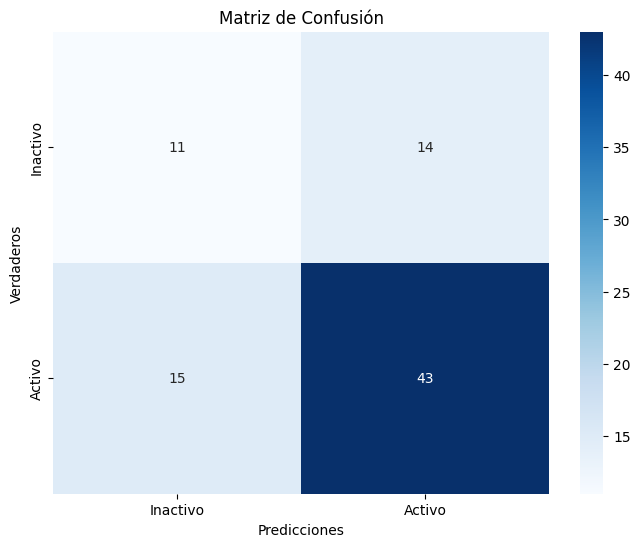


Puntuaciones de Validación Cruzada: [0.9  0.85 0.83 0.86 0.87]
Media de Validación Cruzada: 0.8620


In [38]:
def prepare_data(ds_final, sample_size=100000):
 
    # Selección de características relevantes
    features = ['Renta', 'Edad', 'Antiguedad', 'Monoproducto_1', 'Dualidad_1', 'Region_2.0']
    X = pd.get_dummies(ds_final[features], drop_first=True)
    
    # Definir la variable objetivo
    y = ds_final['FlgAct_T12_1.0']  # Cambia esto a tu variable objetivo

    if len(X) > sample_size:
        indices = np.random.choice(len(X), sample_size, replace=False)
        X = X.iloc[indices]
        y = y.iloc[indices]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

def evaluate_decision_tree(X_train, X_test, y_train, y_test):
    tree_model = DecisionTreeClassifier(random_state=42)
    tree_model.fit(X_train, y_train)
    y_pred = tree_model.predict(X_test)
    
    # Métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("Árbol de Decisión:")
    print(f"Precisión: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("\nMatriz de Confusión:")
    print(cm)

    # Reporte de clasificación
    report = classification_report(y_test, y_pred)
    print("\nReporte de Clasificación:")
    print(report)

    # Visualización de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Inactivo', 'Activo'], yticklabels=['Inactivo', 'Activo'])
    plt.ylabel('Verdaderos')
    plt.xlabel('Predicciones')
    plt.title('Matriz de Confusión')
    plt.show()

    # Validación cruzada
    cv_scores = cross_val_score(tree_model, X, y, cv=5)
    print(f"\nPuntuaciones de Validación Cruzada: {cv_scores}")
    print(f"Media de Validación Cruzada: {cv_scores.mean():.4f}")

# Ejecución de la evaluación del Árbol de Decisión
if __name__ == "__main__":
    try:
        # Asegúrate de que ds_final esté definido y contenga los datos necesarios
        X_train, X_test, y_train, y_test = prepare_data(ds_final)

        evaluate_decision_tree(X_train, X_test, y_train, y_test)

    except Exception as e:
        print(f"Error durante la evaluación del Árbol de Decisión: {str(e)}")

El modelo de Árbol de Decisión logró una precisión del 65.06% y un F1 Score de 0.7478, indicando un buen rendimiento en la identificación de clientes activos (True) pero con dificultades para clasificar correctamente a los clientes inactivos (False), reflejado en una precisión de 0.42 para esta clase. La validación cruzada mostró una media de 0.8620.
Las características seleccionadas, como Renta, Edad, Antigüedad, Monoproducto_1, Dualidad_1, y Region_2.0, son relevantes para entender el comportamiento financiero de los clientes.

Regresión Logística:
Precisión: 0.6867
F1 Score: 0.8143

Matriz de Confusión:
[[ 0 25]
 [ 1 57]]

Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        25
        True       0.70      0.98      0.81        58

    accuracy                           0.69        83
   macro avg       0.35      0.49      0.41        83
weighted avg       0.49      0.69      0.57        83



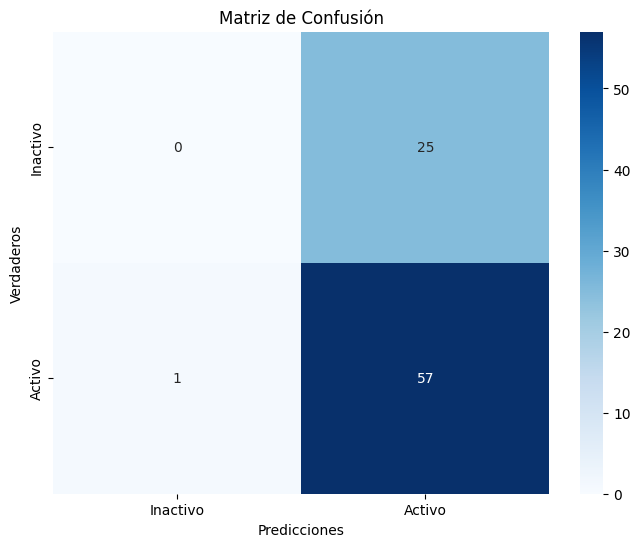


Puntuaciones de Validación Cruzada: [0.9   0.885 0.875 0.83  0.845]
Media de Validación Cruzada: 0.8670


In [39]:
def prepare_data(ds_final, sample_size=100000):


    features = ['Renta', 'Edad', 'Antiguedad', 'Monoproducto_1', 'Dualidad_1', 'Region_2.0']
    X = pd.get_dummies(ds_final[features], drop_first=True)
    

    y = ds_final['FlgAct_T12_1.0']  

    if len(X) > sample_size:
        indices = np.random.choice(len(X), sample_size, replace=False)
        X = X.iloc[indices]
        y = y.iloc[indices]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

def evaluate_logistic_regression(X_train, X_test, y_train, y_test):
    logistic_model = LogisticRegression(max_iter=500)
    logistic_model.fit(X_train, y_train)
    y_pred = logistic_model.predict(X_test)
    

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("Regresión Logística:")
    print(f"Precisión: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")


    cm = confusion_matrix(y_test, y_pred)
    print("\nMatriz de Confusión:")
    print(cm)


    report = classification_report(y_test, y_pred)
    print("\nReporte de Clasificación:")
    print(report)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Inactivo', 'Activo'], yticklabels=['Inactivo', 'Activo'])
    plt.ylabel('Verdaderos')
    plt.xlabel('Predicciones')
    plt.title('Matriz de Confusión')
    plt.show()

  
    cv_scores = cross_val_score(logistic_model, X, y, cv=5)
    print(f"\nPuntuaciones de Validación Cruzada: {cv_scores}")
    print(f"Media de Validación Cruzada: {cv_scores.mean():.4f}")


if __name__ == "__main__":
    try:
      
        X_train, X_test, y_train, y_test = prepare_data(ds_final)

        evaluate_logistic_regression(X_train, X_test, y_train, y_test)

    except Exception as e:
        print(f"Error durante la evaluación de la Regresión Logística: {str(e)}")

El modelo de Regresión Logística obtuvo una precisión del 68.67% y un F1 Score de 0.8143, destacando en la identificación de clientes activos (True) con un recall de 0.98. Sin embargo, no clasificó correctamente a ningún cliente inactivo (False), reflejado en una precisión de 0.00 para esta clase.
Las puntuaciones de validación cruzada fueron altas, con una media de 0.8670, indicando robustez. Las características seleccionadas son relevantes.

Fase 6: UNSUPERVISED MODELING

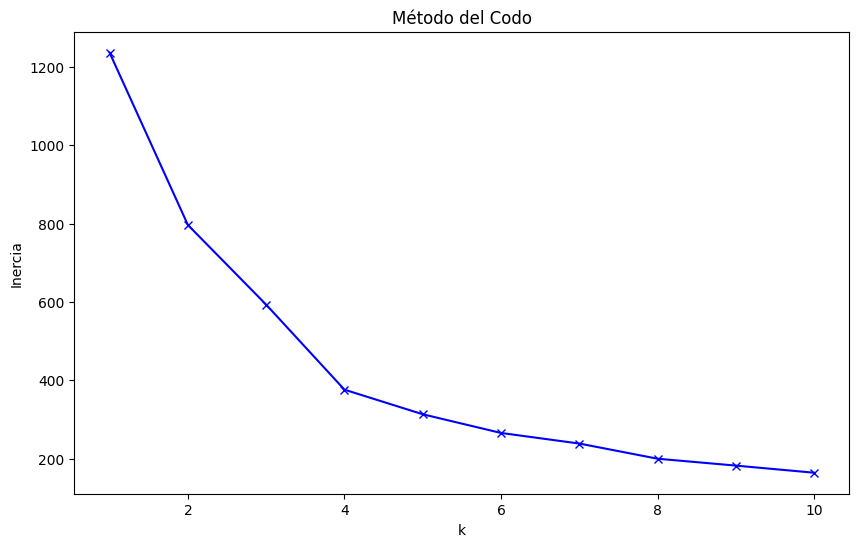


Análisis de Clusters:
--------------------------------------------------

Estadísticas por Cluster:
            Renta             Edad        Antiguedad       
             mean       std   mean    std       mean    std
Cluster                                                    
0         2725.95   8884.97  32.86   6.53      24.17  15.43
1        59201.00  39868.41  55.79  10.77      97.34  16.57
2        14891.47  26974.34  60.66   7.78      28.91  16.76
3        83158.92  17003.92  35.60   9.21      30.08  17.89


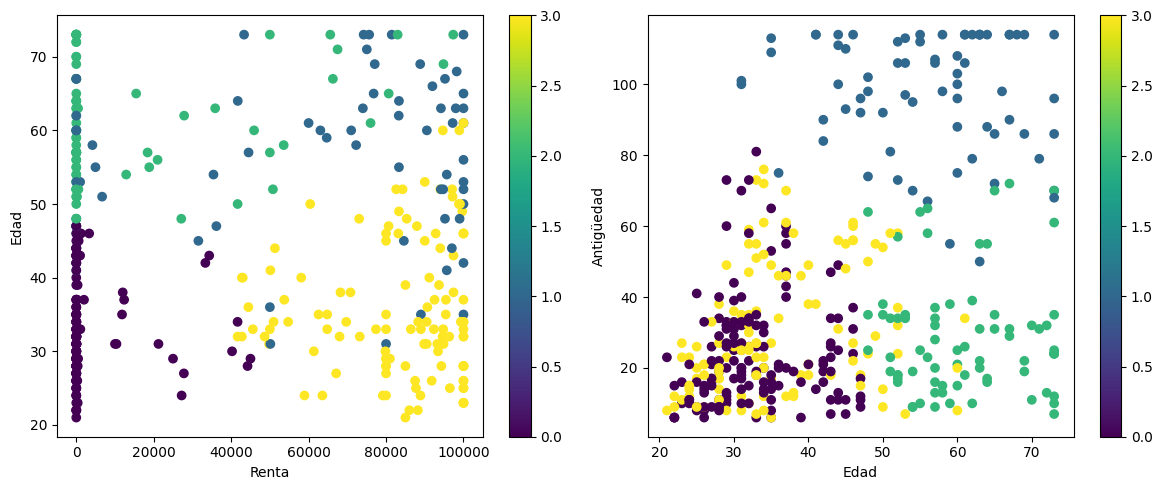

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
def prepare_data_clustering(ds_final):
    # Seleccionamos las características para clustering
    features_clustering = ['Renta', 'Edad', 'Antiguedad']
    
    # Normalizamos los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(ds_final[features_clustering])
    
    return X_scaled

def elbow_method(X_scaled):
    # Calculamos la inercia para diferentes valores de k
    inertias = []
    K = range(1, 11)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
    
    # Visualizamos el método del codo
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.show()
    
    return K, inertias

def perform_clustering(X_scaled, n_clusters):
    # Realizamos el clustering con el número óptimo de clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    return clusters, kmeans

def analyze_clusters(ds_final, clusters, features_clustering):
    # Añadimos las etiquetas de cluster al dataframe original
    ds_final['Cluster'] = clusters
    
    # Análisis de clusters
    print("\nAnálisis de Clusters:")
    print("-" * 50)
    
    # Estadísticas descriptivas por cluster
    cluster_stats = ds_final.groupby('Cluster')[features_clustering].agg(['mean', 'std']).round(2)
    print("\nEstadísticas por Cluster:")
    print(cluster_stats)
    
    # Visualización de clusters
    fig = plt.figure(figsize=(12, 5))
    
    # Gráfico 1: Renta vs Edad
    ax1 = fig.add_subplot(121)
    scatter = plt.scatter(ds_final['Renta'], ds_final['Edad'], 
                         c=clusters, cmap='viridis')
    plt.xlabel('Renta')
    plt.ylabel('Edad')
    plt.colorbar(scatter)
    
    # Gráfico 2: Edad vs Antigüedad
    ax2 = fig.add_subplot(122)
    scatter = plt.scatter(ds_final['Edad'], ds_final['Antiguedad'], 
                         c=clusters, cmap='viridis')
    plt.xlabel('Edad')
    plt.ylabel('Antigüedad')
    plt.colorbar(scatter)
    
    plt.tight_layout()
    plt.show()

# Ejecutamos el análisis de clustering
try:
    # Preparamos los datos
    X_scaled = prepare_data_clustering(ds_final)
    
    # Aplicamos el método del codo
    K, inertias = elbow_method(X_scaled)
    
    # Definimos el número óptimo de clusters (ajusta este valor según el gráfico del codo)
    n_clusters = 4  # Este valor se debe ajustar según el resultado del método del codo
    
    # Realizamos el clustering
    clusters, kmeans = perform_clustering(X_scaled, n_clusters)
    
    # Analizamos los resultados
    analyze_clusters(ds_final, clusters, ['Renta', 'Edad', 'Antiguedad'])
    
except Exception as e:
    print(f"Error durante el análisis de clustering: {str(e)}")

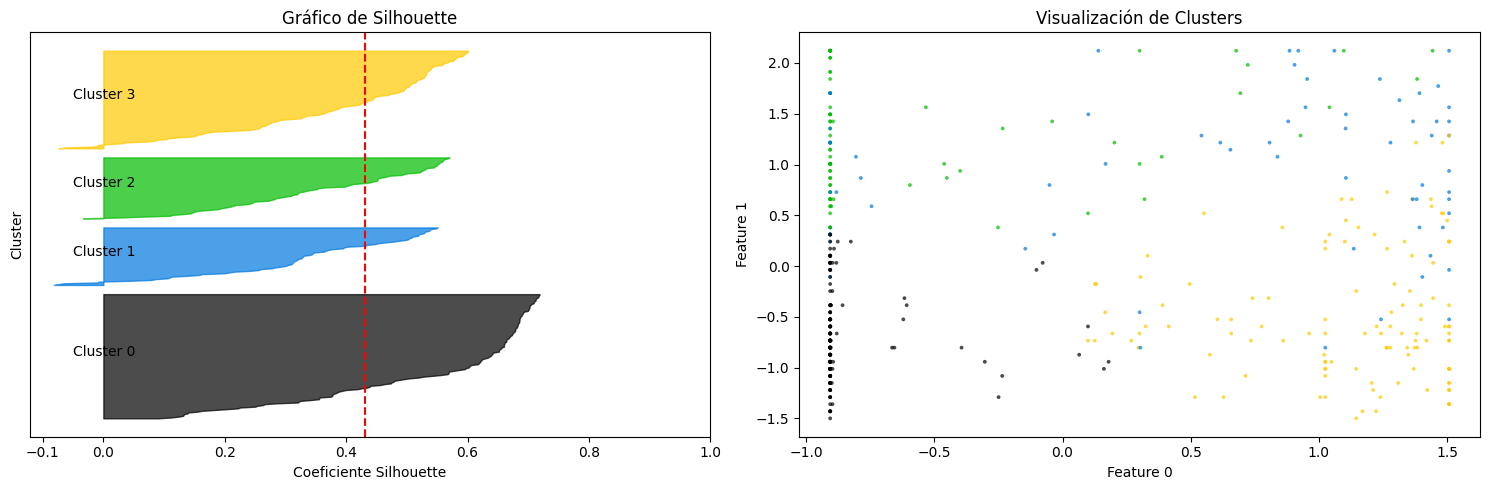

Coeficiente Silhouette promedio: 0.431
Coeficiente Silhouette para cluster 0: 0.549
Coeficiente Silhouette para cluster 1: 0.325
Coeficiente Silhouette para cluster 2: 0.362
Coeficiente Silhouette para cluster 3: 0.388


In [42]:
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np

def plot_silhouette(X_scaled, n_clusters):
    # Creamos el modelo KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Calculamos el coeficiente silhouette promedio
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    
    # Calculamos los valores silhouette para cada muestra
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
    
    # Creamos el gráfico
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Primer subplot: Gráfico Silhouette
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
        y_lower = y_upper + 10
    
    ax1.set_title("Gráfico de Silhouette")
    ax1.set_xlabel("Coeficiente Silhouette")
    ax1.set_ylabel("Cluster")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # Segundo subplot: Scatter plot de los clusters
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    ax2.set_title("Visualización de Clusters")
    ax2.set_xlabel("Feature 0")
    ax2.set_ylabel("Feature 1")
    
    plt.tight_layout()
    plt.show()
    
    print(f'Coeficiente Silhouette promedio: {silhouette_avg:.3f}')
    
    # Calculamos el coeficiente Silhouette para cada cluster
    for i in range(n_clusters):
        cluster_silhouette = np.mean(sample_silhouette_values[cluster_labels == i])
        print(f'Coeficiente Silhouette para cluster {i}: {cluster_silhouette:.3f}')

# Ejecutamos el análisis Silhouette
try:
    plot_silhouette(X_scaled, n_clusters=4)
except Exception as e:
    print(f"Error durante el análisis Silhouette: {str(e)}")